In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

from keras.layers import Dense, Activation, Convolution2D,\
    MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout

from keras.layers.convolutional import ZeroPadding2D
from keras.models import Sequential
from keras.optimizers import SGD, Adam

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72


Using TensorFlow backend.


Below are the functions to generate a disk, a rectangle and a triangle with an optional noise
parameter. These 3 functions call the generate a drawing within their core.


In [3]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [3]:
# Pass im[0] to return the image with noise and im[1] for the image without noise
im = generate_a_rectangle(10, True)
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In the functions below, we generate datasets containing images either of \
triangles, rectangles or disks on a random basis.


In [4]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)[0]
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)[0]
        else:
            triangle = generate_a_triangle(noise, free_location)
            [X[i], V] = [triangle[0][0]]+triangle[1:]
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]


def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0][0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        triangle = generate_a_triangle(noise, True)
        [X[i], Y[i]] = [triangle[0][0]] + triangle[1:]
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [5]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE, IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor='r', 
                          linewidth=5, alpha=0.5)
    ax.add_patch(tri)

    plt.show()


def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


Part 2 - Simple Classification

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10


20


30
40

50


60


70
80


90


100


110


120
130


140
150


160
170


180
190


200
210


220
230


240


250
260


270
280


290


Below we create a simple sequential model with 2 Dense layers and 
one activation layer with ReLu parameter. Then we compile the model using
the Stochastic Descent Gradient as optimizer and Mean Squared Error for 
the loss. While doing tests I realised the default values of the optimiser 
weren't producing satisfying results so we define manually the parameters of sgd

In [8]:
sgd = SGD(lr=0.001, clipnorm=1.)

In [9]:
nb_classes = 3

#Y_train_categorical = np_utils.to_categorical(Y_train)
model = Sequential()
model.add(Dense(20, input_shape=(X_train.shape[1],), 
                activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['acc'])


In [11]:
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6859 - acc: 0.3125

300/300 [==============================] - 0s 124us/step - loss: 0.6733 - acc: 0.3267


Epoch 2/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5626 - acc: 0.4375

300/300 [==============================] - 0s 150us/step - loss: 0.6730 - acc: 0.3267


Epoch 3/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7181 - acc: 0.2812

300/300 [==============================] - 0s 126us/step - loss: 0.6730 - acc: 0.3267


Epoch 4/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6556 - acc: 0.3438

300/300 [==============================] - 0s 104us/step - loss: 0.6730 - acc: 0.3267


Epoch 5/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.8090 - acc: 0.1875



300/300 [==============================] - 0s 109us/step - loss: 0.6733 - acc: 0.3267


Epoch 6/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5645 - acc: 0.4375



300/300 [==============================] - 0s 127us/step - loss: 0.6730 - acc: 0.3267


Epoch 7/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5915 - acc: 0.4062

300/300 [==============================] - 0s 112us/step - loss: 0.6732 - acc: 0.3267


Epoch 8/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.7671 - acc: 0.2188



300/300 [==============================] - 0s 119us/step - loss: 0.6730 - acc: 0.3267


Epoch 9/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7092 - acc: 0.2812



288/300 [===========================>..] - ETA: 0s - loss: 0.6664 - acc: 0.3333

300/300 [==============================] - 0s 215us/step - loss: 0.6728 - acc: 0.3267


Epoch 10/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5991 - acc: 0.4062

300/300 [==============================] - 0s 109us/step - loss: 0.6728 - acc: 0.3267


Epoch 11/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.4382 - acc: 0.5625



300/300 [==============================] - 0s 104us/step - loss: 0.6728 - acc: 0.3267


Epoch 12/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.6004 - acc: 0.4062



300/300 [==============================] - 0s 107us/step - loss: 0.6728 - acc: 0.3267


Epoch 13/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5928 - acc: 0.4062

300/300 [==============================] - 0s 147us/step - loss: 0.6729 - acc: 0.3267


Epoch 14/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6139 - acc: 0.3750

300/300 [==============================] - 0s 107us/step - loss: 0.6733 - acc: 0.3267


Epoch 15/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.7178 - acc: 0.2812

300/300 [==============================] - 0s 109us/step - loss: 0.6730 - acc: 0.3267


Epoch 16/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7544 - acc: 0.2500



300/300 [==============================] - 0s 134us/step - loss: 0.6730 - acc: 0.3267


Epoch 17/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.8060 - acc: 0.1875

300/300 [==============================] - 0s 160us/step - loss: 0.6733 - acc: 0.3267


Epoch 18/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6842 - acc: 0.3125



256/300 [========================>.....] - ETA: 0s - loss: 0.6741 - acc: 0.3242



300/300 [==============================] - 0s 212us/step - loss: 0.6729 - acc: 0.3267


Epoch 19/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7513 - acc: 0.2500

300/300 [==============================] - 0s 132us/step - loss: 0.6733 - acc: 0.3267


Epoch 20/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6553 - acc: 0.3438

300/300 [==============================] - 0s 116us/step - loss: 0.6732 - acc: 0.3267


Epoch 21/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6008 - acc: 0.4062



300/300 [==============================] - 0s 139us/step - loss: 0.6731 - acc: 0.3267


Epoch 22/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6776 - acc: 0.3125

300/300 [==============================] - 0s 121us/step - loss: 0.6728 - acc: 0.3267


Epoch 23/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.6409 - acc: 0.3438

300/300 [==============================] - 0s 131us/step - loss: 0.6731 - acc: 0.3267


Epoch 24/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6336 - acc: 0.3750



300/300 [==============================] - 0s 149us/step - loss: 0.6729 - acc: 0.3267


Epoch 25/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6243 - acc: 0.3438

300/300 [==============================] - 0s 119us/step - loss: 0.6736 - acc: 0.3267


Epoch 26/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7592 - acc: 0.2500



300/300 [==============================] - 0s 180us/step - loss: 0.6732 - acc: 0.3267


Epoch 27/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6224 - acc: 0.3750

300/300 [==============================] - 0s 141us/step - loss: 0.6727 - acc: 0.3267


Epoch 28/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6315 - acc: 0.3750

300/300 [==============================] - 0s 127us/step - loss: 0.6732 - acc: 0.3267


Epoch 29/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7117 - acc: 0.2812



300/300 [==============================] - 0s 122us/step - loss: 0.6728 - acc: 0.3267


Epoch 30/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5657 - acc: 0.4375

300/300 [==============================] - 0s 147us/step - loss: 0.6727 - acc: 0.3267


Epoch 31/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6522 - acc: 0.3438



300/300 [==============================] - 0s 165us/step - loss: 0.6729 - acc: 0.3267


Epoch 32/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.5031 - acc: 0.5000



300/300 [==============================] - 0s 126us/step - loss: 0.6728 - acc: 0.3267


Epoch 33/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6531 - acc: 0.3438

300/300 [==============================] - 0s 111us/step - loss: 0.6728 - acc: 0.3267


Epoch 34/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7830 - acc: 0.2188



300/300 [==============================] - 0s 109us/step - loss: 0.6730 - acc: 0.3267


Epoch 35/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7208 - acc: 0.2812



300/300 [==============================] - 0s 112us/step - loss: 0.6729 - acc: 0.3267


Epoch 36/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7266 - acc: 0.2812



300/300 [==============================] - 0s 137us/step - loss: 0.6730 - acc: 0.3267


Epoch 37/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.8233 - acc: 0.1875



300/300 [==============================] - 0s 109us/step - loss: 0.6731 - acc: 0.3267


Epoch 38/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6776 - acc: 0.3125



300/300 [==============================] - 0s 121us/step - loss: 0.6729 - acc: 0.3267


Epoch 39/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6444 - acc: 0.3438



300/300 [==============================] - 0s 111us/step - loss: 0.6732 - acc: 0.3267


Epoch 40/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6155 - acc: 0.3750



300/300 [==============================] - 0s 107us/step - loss: 0.6729 - acc: 0.3267


Epoch 41/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6003 - acc: 0.4062

300/300 [==============================]

 - 0s 112us/step - loss: 0.6732 - acc: 0.3267


Epoch 42/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.7546 - acc: 0.2500



300/300 [==============================] - 0s 109us/step - loss: 0.6729 - acc: 0.3267


Epoch 43/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5700 - acc: 0.4375

300/300 [==============================] - 0s 109us/step - loss: 0.6729 - acc: 0.3267


Epoch 44/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5338 - acc: 0.4688



300/300 [==============================] - 0s 107us/step - loss: 0.6730 - acc: 0.3267


Epoch 45/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6919 - acc: 0.3125

300/300 [==============================] - 0s 119us/step - loss: 0.6729 - acc: 0.3267


Epoch 46/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.6481 - acc: 0.3438



300/300 [==============================] - 0s 109us/step - loss: 0.6730 - acc: 0.3267


Epoch 47/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5532 - acc: 0.4375



192/300 [==================>...........] - ETA: 0s - loss: 0.6598 - acc: 0.3385

300/300 [==============================] - 0s 227us/step - loss: 0.6728 - acc: 0.3267


Epoch 48/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6463 - acc: 0.3438



300/300 [==============================] - 0s 137us/step - loss: 0.6730 - acc: 0.3267


Epoch 49/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6852 - acc: 0.3125



300/300 [==============================] - 0s 116us/step - loss: 0.6728 - acc: 0.3267


Epoch 50/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6578 - acc: 0.3438

300/300 [==============================] - 0s 103us/step - loss: 0.6729 - acc: 0.3267


The model performs the correct prediction on the test example. However the
accuracy is very low.


In [ ]:
X_test = generate_a_disk()[0]
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

Now let's try with a different optimizer: Adam

In [12]:
nb_classes = 3

Y_train_categorical = np_utils.to_categorical(Y_train)
#Build new model for adam optimizer
modelad = Sequential()
modelad.add(Dense(nb_classes, input_shape=(X_train.shape[1],), activation='softmax'))

modelad.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = modelad.fit(X_train,Y_train_categorical, epochs=50,batch_size=32)

Epoch 1/50
 32/300 [==>...........................] - ETA: 1s - loss: 1.9357 - acc: 0.2188

300/300 [==============================] - 0s 527us/step - loss: 2.3100 - acc: 0.3267


Epoch 2/50
 32/300 [==>...........................] - ETA: 0s - loss: 1.2605 - acc: 0.4375



300/300 [==============================] - 0s 106us/step - loss: 1.0290 - acc: 0.5500


Epoch 3/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.4345 - acc: 0.9062

300/300 [==============================] - 0s 124us/step - loss: 0.6859 - acc: 0.7533


Epoch 4/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5063 - acc: 0.8125

300/300 [==============================] - 0s 119us/step - loss: 0.4942 - acc: 0.7933


Epoch 5/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.5040 - acc: 0.7188

300/300 [==============================] - 0s 112us/step - loss: 0.4114 - acc: 0.8500


Epoch 6/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.6736 - acc: 0.5312



300/300 [==============================] - 0s 122us/step - loss: 0.3852 - acc: 0.8267


Epoch 7/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.3194 - acc: 0.9688



300/300 [==============================] - 0s 112us/step - loss: 0.3208 - acc: 0.8767


Epoch 8/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.2749 - acc: 0.9688

300/300 [==============================] - 0s 114us/step - loss: 0.2574 - acc: 0.9467


Epoch 9/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.1847 - acc: 0.9688

300/300 [==============================] - 0s 96us/step - loss: 0.2391 - acc: 0.9167


Epoch 10/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.1636 - acc: 0.9688

300/300 [==============================] - 0s 88us/step - loss: 0.3178 - acc: 0.8433


Epoch 11/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.2138 - acc: 0.9375

300/300 [==============================] - 0s 94us/step - loss: 0.2415 - acc: 0.8967


Epoch 12/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1313 - acc: 1.0000



300/300 [==============================] - 0s 94us/step - loss: 0.2094 - acc: 0.9333


Epoch 13/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.2199 - acc: 0.8438



300/300 [==============================] - 0s 99us/step - loss: 0.2032 - acc: 0.9133


Epoch 14/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1540 - acc: 1.0000



300/300 [==============================] - 0s 88us/step - loss: 0.1559 - acc: 0.9833


Epoch 15/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1101 - acc: 1.0000



300/300 [==============================] - 0s 88us/step - loss: 0.1291 - acc: 0.9867


Epoch 16/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1514 - acc: 1.0000



300/300 [==============================] - 0s 96us/step - loss: 0.1237 - acc: 0.9900


Epoch 17/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0552 - acc: 1.0000



300/300 [==============================] - 0s 107us/step - loss: 0.1475 - acc: 0.9467


Epoch 18/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1892 - acc: 0.9062



300/300 [==============================] - 0s 94us/step - loss: 0.1716 - acc: 0.9233


Epoch 19/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.2192 - acc: 0.8750

300/300 [==============================] - 0s 94us/step - loss: 0.1686 - acc: 0.9333


Epoch 20/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.2128 - acc: 0.9062

300/300 [==============================] - 0s 94us/step - loss: 0.1334 - acc: 0.9500


Epoch 21/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.0727 - acc: 1.0000

300/300 [==============================] - 0s 101us/step - loss: 0.0968 - acc: 0.9833


Epoch 22/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1120 - acc: 1.0000



300/300 [==============================] - 0s 111us/step - loss: 0.0839 - acc: 0.9967


Epoch 23/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0822 - acc: 1.0000



300/300 [==============================] - 0s 91us/step - loss: 0.0848 - acc: 0.9967


Epoch 24/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.1276 - acc: 0.9375



300/300 [==============================] - 0s 96us/step - loss: 0.0846 - acc: 0.9933


Epoch 25/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0971 - acc: 1.0000



300/300 [==============================] - 0s 101us/step - loss: 0.0694 - acc: 1.0000


Epoch 26/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0684 - acc: 1.0000



300/300 [==============================] - 0s 91us/step - loss: 0.0671 - acc: 1.0000


Epoch 27/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0565 - acc: 1.0000



300/300 [==============================] - 0s 98us/step - loss: 0.0629 - acc: 1.0000


Epoch 28/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0605 - acc: 1.0000

300/300 [==============================] - 0s 88us/step - loss: 0.0562 - acc: 1.0000


Epoch 29/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0409 - acc: 1.0000



300/300 [==============================] - 0s 104us/step - loss: 0.0536 - acc: 1.0000


Epoch 30/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0577 - acc: 1.0000



300/300 [==============================] - 0s 88us/step - loss: 0.0524 - acc: 1.0000


Epoch 31/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0443 - acc: 1.0000

300/300 [==============================] - 0s 94us/step - loss: 0.0501 - acc: 1.0000


Epoch 32/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.0809 - acc: 1.0000

300/300 [==============================] - 0s 94us/step - loss: 0.0576 - acc: 1.0000


Epoch 33/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.0508 - acc: 1.0000



300/300 [==============================] - 0s 91us/step - loss: 0.0503 - acc: 1.0000


Epoch 34/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0345 - acc: 1.0000



300/300 [==============================] - 0s 104us/step - loss: 0.0428 - acc: 1.0000


Epoch 35/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0447 - acc: 1.0000

300/300 [==============================] - 0s 91us/step - loss: 0.0464 - acc: 1.0000


Epoch 36/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0357 - acc: 1.0000



300/300 [==============================] - 0s 93us/step - loss: 0.0482 - acc: 1.0000


Epoch 37/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0506 - acc: 1.0000



300/300 [==============================] - 0s 98us/step - loss: 0.0419 - acc: 1.0000


Epoch 38/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0266 - acc: 1.0000



300/300 [==============================] - 0s 94us/step - loss: 0.0415 - acc: 1.0000


Epoch 39/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0424 - acc: 1.0000



300/300 [==============================] - 0s 89us/step - loss: 0.0378 - acc: 1.0000


Epoch 40/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0368 - acc: 1.0000



300/300 [==============================] - 0s 106us/step - loss: 0.0339 - acc: 1.0000


Epoch 41/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0397 - acc: 1.0000



300/300 [==============================] - 0s 93us/step - loss: 0.0346 - acc: 1.0000


Epoch 42/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0265 - acc: 1.0000

300/300 [==============================] - 0s 93us/step - loss: 0.0334 - acc: 1.0000


Epoch 43/50


 32/300 [==>...........................] - ETA: 0s - loss: 0.0379 - acc: 1.0000



300/300 [==============================] - 0s 117us/step - loss: 0.0314 - acc: 1.0000


Epoch 44/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0354 - acc: 1.0000



300/300 [==============================] - 0s 114us/step - loss: 0.0321 - acc: 1.0000


Epoch 45/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0215 - acc: 1.0000



300/300 [==============================] - 0s 111us/step - loss: 0.0316 - acc: 1.0000


Epoch 46/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0291 - acc: 1.0000



300/300 [==============================] - 0s 99us/step - loss: 0.0296 - acc: 1.0000


Epoch 47/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0331 - acc: 1.0000



300/300 [==============================] - 0s 94us/step - loss: 0.0276 - acc: 1.0000


Epoch 48/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0265 - acc: 1.0000



300/300 [==============================] - 0s 94us/step - loss: 0.0272 - acc: 1.0000


Epoch 49/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0306 - acc: 1.0000



300/300 [==============================] - 0s 86us/step - loss: 0.0264 - acc: 1.0000


Epoch 50/50
 32/300 [==>...........................] - ETA: 0s - loss: 0.0371 - acc: 1.0000



300/300 [==============================] - 0s 136us/step - loss: 0.0264 - acc: 1.0000


In [160]:
X_test = generate_a_disk()[0]
X_test = X_test.reshape(1, X_test.shape[0])
modelad.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

This optimizer produces a much better result and in a much faster time. 
Adam is known to fit well the training data and require less tuning than sgd.


Visualisation of the solution


Text(0.5, 1.0, '1rst column - rectangle')

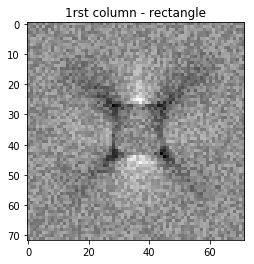

In [162]:
W, b = modelad.get_weights()
plt.figure(1)
plt.imshow(W[:,0].reshape(72,72), cmap='gray')
plt.title('1rst column - rectangle')

Text(0.5, 1.0, '2nd column - circle')

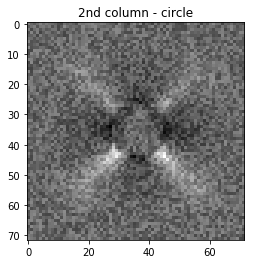

In [163]:
plt.figure(2)
plt.imshow(W[:,1].reshape(72,72), cmap='gray')
plt.title('2nd column - circle')
#plt.savefig('2ndcolumn.png', dpi=500)


Text(0.5, 1.0, '3rd column - triangle')

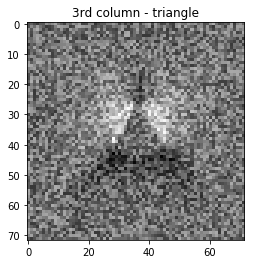

In [164]:
plt.figure(3)
plt.imshow(W[:,2].reshape(72,72), cmap='gray')
plt.title('3rd column - triangle')


Part 5 - Classification problem


In [165]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10


20
30


40


50
60


70


80
90


100
110


120
130


140
150


160
170


180
190


200
210


220
230


240
250


260
270


280
290


In [166]:
Y_train_categorical = np_utils.to_categorical(Y_train)
X_train = X_train.reshape((-1,72,72,1))

Now we build another Sequential model.


In [ ]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten
model5 = Sequential()
model5.add(Convolution2D(16, kernel_size=(5,5), input_shape=(72,72,1,)))
model5.add(MaxPooling2D(pool_size=(3,3)))
model5.add(Flatten())
model.add(Dropout(0.3))
model5.add(Dense(nb_classes, activation= 'softmax'))


In [168]:
model5.compile(loss='categorical_crossentropy', optimizer='adam',
               metrics=['acc']) 

history = model5.fit(X_train,Y_train_categorical,epochs=150,batch_size=32)

Epoch 1/150


 32/300 [==>...........................] - ETA: 12s - loss: 1.0493 - acc: 0.4062

 64/300 [=====>........................] - ETA: 5s - loss: 1.6236 - acc: 0.4531 

 96/300 [========>.....................] - ETA: 3s - loss: 1.6604 - acc: 0.4167

128/300 [===========>..................] - ETA: 2s - loss: 1.5194 - acc: 0.4375

160/300 [===============>..............] - ETA: 1s - loss: 1.5195 - acc: 0.4437

192/300 [==================>...........] - ETA: 1s - loss: 1.4993 - acc: 0.4219

224/300 [=====================>........] - ETA: 0s - loss: 1.5911 - acc: 0.4062

256/300 [========================>.....] - ETA: 0s - loss: 1.6308 - acc: 0.3789

288/300 [===========================>..] - ETA: 0s - loss: 1.5683 - acc: 0.3819

300/300 [==============================] - 2s 7ms/step - loss: 1.5491 - acc: 0.3800


Epoch 2/150


 32/300 [==>...........................] - ETA: 0s - loss: 1.1696 - acc: 0.3750

 64/300 [=====>........................] - ETA: 0s - loss: 1.2773 - acc: 0.3125

 96/300 [========>.....................] - ETA: 0s - loss: 1.2603 - acc: 0.3229

128/300 [===========>..................] - ETA: 0s - loss: 1.2155 - acc: 0.3281

160/300 [===============>..............] - ETA: 0s - loss: 1.1895 - acc: 0.3375

192/300 [==================>...........] - ETA: 0s - loss: 1.1773 - acc: 0.3333

224/300 [=====================>........] - ETA: 0s - loss: 1.1610 - acc: 0.3438

256/300 [========================>.....] - ETA: 0s - loss: 1.1474 - acc: 0.3633

288/300 [===========================>..] - ETA: 0s - loss: 1.1480 - acc: 0.3750

300/300 [==============================] - 1s 3ms/step - loss: 1.1465 - acc: 0.3700


Epoch 3/150


 32/300 [==>...........................] - ETA: 0s - loss: 1.0167 - acc: 0.5000

 64/300 [=====>........................] - ETA: 0s - loss: 1.0195 - acc: 0.4531

 96/300 [========>.....................] - ETA: 0s - loss: 1.0273 - acc: 0.4271

128/300 [===========>..................] - ETA: 0s - loss: 1.0168 - acc: 0.4766

160/300 [===============>..............]

 - ETA: 0s - loss: 1.0211 - acc: 0.4688

192/300 [==================>...........] - ETA: 0s - loss: 1.0210 - acc: 0.4583

224/300 [=====================>........] - ETA: 0s - loss: 1.0126 - acc: 0.4688

256/300 [========================>.....] - ETA: 0s - loss: 1.0092 - acc: 0.4844

288/300 [===========================>..] - ETA: 0s - loss: 1.0151 - acc: 0.4861

300/300 [==============================] - 1s 3ms/step - loss: 1.0091 - acc: 0.4900


Epoch 4/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.9779 - acc: 0.6250

 64/300 [=====>........................] - ETA: 0s - loss: 0.9923 - acc: 0.5781

 96/300 [========>.....................] - ETA: 0s - loss: 0.9777 - acc: 0.5833

128/300 [===========>..................] - ETA: 0s - loss: 0.9783 - acc: 0.5703

160/300 [===============>..............] - ETA: 0s - loss: 0.9848 - acc: 0.5375

192/300 [==================>...........] - ETA: 0s - loss: 0.9806 - acc: 0.5469

224/300 [=====================>........] - ETA: 0s - loss: 0.9812 - acc: 0.5446

256/300 [========================>.....] - ETA: 0s - loss: 0.9815 - acc: 0.5391

288/300 [===========================>..] - ETA: 0s - loss: 0.9760 - acc: 0.5694



300/300 [==============================] - 1s 3ms/step - loss: 0.9746 - acc: 0.5700


Epoch 5/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.9730 - acc: 0.5625

 64/300 [=====>........................] - ETA: 0s - loss: 0.9831 - acc: 0.5312

 96/300 [========>.....................] - ETA: 0s - loss: 0.9407 - acc: 0.6042

128/300 [===========>..................] - ETA: 0s - loss: 0.9275 - acc: 0.6250

160/300 [===============>..............] - ETA: 0s - loss: 0.9285 - acc: 0.6312

192/300 [==================>...........] - ETA: 0s - loss: 0.9290 - acc: 0.6406

224/300 [=====================>........] - ETA: 0s - loss: 0.9217 - acc: 0.6518

256/300 [========================>.....] - ETA: 0s - loss: 0.9158 - acc: 0.6680

288/300 [===========================>..] - ETA: 0s - loss: 0.9136 - acc: 0.6840



300/300 [==============================] - 1s 3ms/step - loss: 0.9144 - acc: 0.6800


Epoch 6/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.8989 - acc: 0.5938

 64/300 [=====>........................] - ETA: 0s - loss: 0.8864 - acc: 0.6094

 96/300 [========>.....................] - ETA: 0s - loss: 0.8903 - acc: 0.5833

128/300 [===========>..................] - ETA: 0s - loss: 0.8914 - acc: 0.5781

160/300 [===============>..............] - ETA: 0s - loss: 0.8911 - acc: 0.6188

192/300 [==================>...........] - ETA: 0s - loss: 0.8858 - acc: 0.6302

224/300 [=====================>........] - ETA: 0s - loss: 0.8788 - acc: 0.6562

256/300 [========================>.....] - ETA: 0s - loss: 0.8740 - acc: 0.6680

288/300 [===========================>..] - ETA: 0s - loss: 0.8732 - acc: 0.6632



300/300 [==============================] - 1s 3ms/step - loss: 0.8722 - acc: 0.6633


Epoch 7/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.8717 - acc: 0.6250

 64/300 [=====>........................] - ETA: 0s - loss: 0.8404 - acc: 0.7031

 96/300 [========>.....................] - ETA: 0s - loss: 0.8440 - acc: 0.7188

128/300 [===========>..................] - ETA: 0s - loss: 0.8286 - acc: 0.7500

160/300 [===============>..............] - ETA: 0s - loss: 0.8274 - acc: 0.7500

192/300 [==================>...........] - ETA: 0s - loss: 0.8304 - acc: 0.7292

224/300 [=====================>........] - ETA: 0s - loss: 0.8343 - acc: 0.7232

256/300 [========================>.....] - ETA: 0s - loss: 0.8332 - acc: 0.7422

288/300 [===========================>..] - ETA: 0s - loss: 0.8284 - acc: 0.7500



300/300 [==============================] - 1s 3ms/step - loss: 0.8337 - acc: 0.7467


Epoch 8/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.6768 - acc: 0.8438

 64/300 [=====>........................] - ETA: 0s - loss: 0.7771 - acc: 0.7344

 96/300 [========>.....................] - ETA: 0s - loss: 0.8016 - acc: 0.7083

128/300 [===========>..................] - ETA: 0s - loss: 0.8023 - acc: 0.6953

160/300 [===============>..............] - ETA: 0s - loss: 0.8002 - acc: 0.6937

192/300 [==================>...........] - ETA: 0s - loss: 0.8032 - acc: 0.7031

224/300 [=====================>........] - ETA: 0s - loss: 0.8013 - acc: 0.6920

256/300 [========================>.....] - ETA: 0s - loss: 0.7890 - acc: 0.6992

288/300 [===========================>..] - ETA: 0s - loss: 0.7802 - acc: 0.7083



300/300 [==============================] - 1s 3ms/step - loss: 0.8003 - acc: 0.6867


Epoch 9/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.7694 - acc: 0.7500



 64/300 [=====>........................] - ETA: 0s - loss: 0.7380 - acc: 0.8125

 96/300 [========>.....................] - ETA: 0s - loss: 0.7440 - acc: 0.7708

128/300 [===========>..................] - ETA: 0s - loss: 0.7572 - acc: 0.7344

160/300 [===============>..............] - ETA: 0s - loss: 0.7799 - acc: 0.7125

192/300 [==================>...........] - ETA: 0s - loss: 0.7810 - acc: 0.7083

224/300 [=====================>........] - ETA: 0s - loss: 0.7638 - acc: 0.7277

256/300 [========================>.....] - ETA: 0s - loss: 0.7632 - acc: 0.7188

288/300 [===========================>..] - ETA: 0s - loss: 0.7666 - acc: 0.7049

300/300 [==============================] - 1s 3ms/step - loss: 0.7718 - acc: 0.6967


Epoch 10/150
 32/300 [==>...........................] - ETA: 0s - loss: 0.7235 - acc: 0.7188



 64/300 [=====>........................] - ETA: 0s - loss: 0.7464 - acc: 0.7656

 96/300 [========>.....................] - ETA: 0s - loss: 0.7276 - acc: 0.7812

128/300 [===========>..................] - ETA: 0s - loss: 0.7138 - acc: 0.7500



160/300 [===============>..............] - ETA: 0s - loss: 0.7200 - acc: 0.7375

192/300 [==================>...........] - ETA: 0s - loss: 0.7226 - acc: 0.7083

224/300 [=====================>........] - ETA: 0s - loss: 0.7423 - acc: 0.6696

256/300 [========================>.....] - ETA: 0s - loss: 0.7334 - acc: 0.6914

288/300 [===========================>..] - ETA: 0s - loss: 0.7352 - acc: 0.6944



300/300 [==============================] - 1s 3ms/step - loss: 0.7334 - acc: 0.6967


Epoch 11/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.6861 - acc: 0.7812

 64/300 [=====>........................] - ETA: 0s - loss: 0.7166 - acc: 0.7500

 96/300 [========>.....................] - ETA: 0s - loss: 0.6847 - acc: 0.7812

128/300 [===========>..................] - ETA: 0s - loss: 0.7186 - acc: 0.7734

160/300 [===============>..............] - ETA: 0s - loss: 0.7013 - acc: 0.7875

192/300 [==================>...........] - ETA: 0s - loss: 0.7142 - acc: 0.7760

224/300 [=====================>........] - ETA: 0s - loss: 0.7152 - acc: 0.7902

256/300 [========================>.....] - ETA: 0s - loss: 0.7094 - acc: 0.7812

288/300 [===========================>..] - ETA: 0s - loss: 0.7050 - acc: 0.7778



300/300 [==============================] - 1s 3ms/step - loss: 0.7035 - acc: 0.7800


Epoch 12/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.6135 - acc: 0.8438

 64/300 [=====>........................] - ETA: 0s - loss: 0.7514 - acc: 0.7031

 96/300 [========>.....................] - ETA: 0s - loss: 0.7135 - acc: 0.7604

128/300 [===========>..................] - ETA: 0s - loss: 0.6986 - acc: 0.7578

160/300 [===============>..............] - ETA: 0s - loss: 0.6943 - acc: 0.7375

192/300 [==================>...........] - ETA: 0s - loss: 0.6779 - acc: 0.7604

224/300 [=====================>........] - ETA: 0s - loss: 0.6681 - acc: 0.7723

256/300 [========================>.....] - ETA: 0s - loss: 0.6639 - acc: 0.7734

288/300 [===========================>..] - ETA: 0s - loss: 0.6704 - acc: 0.7778

300/300 [==============================] - 1s 3ms/step - loss: 0.6725 - acc: 0.7767


Epoch 13/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.6394 - acc: 0.7500

 64/300 [=====>........................] - ETA: 0s - loss: 0.6114 - acc: 0.8125

 96/300 [========>.....................] - ETA: 0s - loss: 0.6329 - acc: 0.7917

128/300 [===========>..................] - ETA: 0s - loss: 0.6108 - acc: 0.8281

160/300 [===============>..............] - ETA: 0s - loss: 0.6199 - acc: 0.8187

192/300 [==================>...........] - ETA: 0s - loss: 0.6304 - acc: 0.8073

224/300 [=====================>........] - ETA: 0s - loss: 0.6386 - acc: 0.7991

256/300 [========================>.....] - ETA: 0s - loss: 0.6368 - acc: 0.7969

288/300 [===========================>..] - ETA: 0s - loss: 0.6364 - acc: 0.7986

300/300 [==============================] - 1s 3ms/step - loss: 0.6378 - acc: 0.7967


Epoch 14/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.7896 - acc: 0.7500



 64/300 [=====>........................] - ETA: 0s - loss: 0.7001 - acc: 0.7812

 96/300 [========>.....................] - ETA: 0s - loss: 0.6813 - acc: 0.7917

128/300 [===========>..................] - ETA: 0s - loss: 0.6435 - acc: 0.8125

160/300 [===============>..............] - ETA: 0s - loss: 0.6332 - acc: 0.8000

192/300 [==================>...........] - ETA: 0s - loss: 0.6206 - acc: 0.8125

224/300 [=====================>........] - ETA: 0s - loss: 0.6152 - acc: 0.7991

256/300 [========================>.....] - ETA: 0s - loss: 0.6141 - acc: 0.7930

288/300 [===========================>..] - ETA: 0s - loss: 0.6121 - acc: 0.7917



300/300 [==============================] - 1s 3ms/step - loss: 0.6151 - acc: 0.7867


Epoch 15/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.6120 - acc: 0.8125



 64/300 [=====>........................] - ETA: 0s - loss: 0.5819 - acc: 0.8594

 96/300 [========>.....................] - ETA: 0s - loss: 0.5653 - acc: 0.8542



128/300 [===========>..................] - ETA: 0s - loss: 0.5935 - acc: 0.8438

160/300 [===============>..............] - ETA: 0s - loss: 0.6057 - acc: 0.8438

192/300 [==================>...........] - ETA: 0s - loss: 0.6000 - acc: 0.8438

224/300 [=====================>........] - ETA: 0s - loss: 0.5896 - acc: 0.8527

256/300 [========================>.....] - ETA: 0s - loss: 0.5941 - acc: 0.8359

288/300 [===========================>..] - ETA: 0s - loss: 0.5812 - acc: 0.8472

300/300 [==============================] - 1s 3ms/step - loss: 0.5794 - acc: 0.8400


Epoch 16/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.7071 - acc: 0.6562



 64/300 [=====>........................] - ETA: 0s - loss: 0.5847 - acc: 0.7188

 96/300 [========>.....................] - ETA: 0s - loss: 0.5600 - acc: 0.7708

128/300 [===========>..................] - ETA: 0s - loss: 0.5622 - acc: 0.7891

160/300 [===============>..............] - ETA: 0s - loss: 0.5715 - acc: 0.8063

192/300 [==================>...........] - ETA: 0s - loss: 0.5717 - acc: 0.8125

224/300 [=====================>........] - ETA: 0s - loss: 0.5709 - acc: 0.8036

256/300 [========================>.....] - ETA: 0s - loss: 0.5664 - acc: 0.8125

288/300 [===========================>..] - ETA: 0s - loss: 0.5666 - acc: 0.8229



300/300 [==============================] - 1s 3ms/step - loss: 0.5686 - acc: 0.8233


Epoch 17/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.4747 - acc: 0.9062



 64/300 [=====>........................] - ETA: 0s - loss: 0.5270 - acc: 0.8125

 96/300 [========>.....................] - ETA: 0s - loss: 0.5109 - acc: 0.8333

128/300 [===========>..................] - ETA: 0s - loss: 0.5142 - acc: 0.8516

160/300 [===============>..............] - ETA: 0s - loss: 0.5020 - acc: 0.8562

192/300 [==================>...........] - ETA: 0s - loss: 0.5153 - acc: 0.8542

224/300 [=====================>........] - ETA: 0s - loss: 0.5249 - acc: 0.8482

256/300 [========================>.....] - ETA: 0s - loss: 0.5352 - acc: 0.8359

288/300 [===========================>..] - ETA: 0s - loss: 0.5397 - acc: 0.8333

300/300 [==============================] - 1s 3ms/step - loss: 0.5363 - acc: 0.8333


Epoch 18/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.6724 - acc: 0.7188



 64/300 [=====>........................] - ETA: 0s - loss: 0.6166 - acc: 0.7656

 96/300 [========>.....................] - ETA: 0s - loss: 0.5816 - acc: 0.8229

128/300 [===========>..................] - ETA: 0s - loss: 0.5276 - acc: 0.8516

160/300 [===============>..............] - ETA: 0s - loss: 0.5150 - acc: 0.8625

192/300 [==================>...........] - ETA: 0s - loss: 0.5144 - acc: 0.8594

224/300 [=====================>........] - ETA: 0s - loss: 0.5196 - acc: 0.8571

256/300 [========================>.....] - ETA: 0s - loss: 0.5186 - acc: 0.8633

288/300 [===========================>..] - ETA: 0s - loss: 0.5222 - acc: 0.8611

300/300 [==============================] - 1s 3ms/step - loss: 0.5198 - acc: 0.8567


Epoch 19/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.4256 - acc: 0.9375

 64/300 [=====>........................] - ETA: 0s - loss: 0.4393 - acc: 0.9062

 96/300 [========>.....................] - ETA: 0s - loss: 0.4956 - acc: 0.8750

128/300 [===========>..................] - ETA: 0s - loss: 0.5191 - acc: 0.8516

160/300 [===============>..............] - ETA: 0s - loss: 0.5216 - acc: 0.8625

192/300 [==================>...........] - ETA: 0s - loss: 0.5086 - acc: 0.8802

224/300 [=====================>........] - ETA: 0s - loss: 0.4910 - acc: 0.8884

256/300 [========================>.....] - ETA: 0s - loss: 0.4937 - acc: 0.8789

288/300 [===========================>..] - ETA: 0s - loss: 0.4910 - acc: 0.8750



300/300 [==============================] - 1s 3ms/step - loss: 0.4906 - acc: 0.8767


Epoch 20/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.5420 - acc: 0.8438



 64/300 [=====>........................] - ETA: 0s - loss: 0.5374 - acc: 0.7500

 96/300 [========>.....................] - ETA: 0s - loss: 0.5422 - acc: 0.7708

128/300 [===========>..................] - ETA: 0s - loss: 0.5439 - acc: 0.7734

160/300 [===============>..............] - ETA: 0s - loss: 0.5322 - acc: 0.7750

192/300 [==================>...........] - ETA: 0s - loss: 0.5112 - acc: 0.8021

224/300 [=====================>........] - ETA: 0s - loss: 0.5058 - acc: 0.8125

256/300 [========================>.....] - ETA: 0s - loss: 0.5166 - acc: 0.8086

288/300 [===========================>..] - ETA: 0s - loss: 0.5078 - acc: 0.8090

300/300 [==============================] - 1s 3ms/step - loss: 0.5041 - acc: 0.8133


Epoch 21/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.5067 - acc: 0.8438



 64/300 [=====>........................] - ETA: 0s - loss: 0.4212 - acc: 0.8750

 96/300 [========>.....................] - ETA: 0s - loss: 0.4432 - acc: 0.8542

128/300 [===========>..................] - ETA: 0s - loss: 0.5370 - acc: 0.7891

160/300 [===============>..............] - ETA: 0s - loss: 0.5422 - acc: 0.8000

192/300 [==================>...........] - ETA: 0s - loss: 0.5234 - acc: 0.8021

224/300 [=====================>........] - ETA: 0s - loss: 0.5396 - acc: 0.7902

256/300 [========================>.....] - ETA: 0s - loss: 0.5457 - acc: 0.7773

288/300 [===========================>..] - ETA: 0s - loss: 0.5435 - acc: 0.7639

300/300 [==============================] - 1s 3ms/step - loss: 0.5394 - acc: 0.7667


Epoch 22/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.4035 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.4214 - acc: 0.9219

 96/300 [========>.....................] - ETA: 0s - loss: 0.4269 - acc: 0.8958

128/300 [===========>..................] - ETA: 0s - loss: 0.4351 - acc: 0.8906

160/300 [===============>..............] - ETA: 0s - loss: 0.4592 - acc: 0.8750

192/300 [==================>...........] - ETA: 0s - loss: 0.4721 - acc: 0.8802

224/300 [=====================>........] - ETA: 0s - loss: 0.4741 - acc: 0.8839

256/300 [========================>.....] - ETA: 0s - loss: 0.4823 - acc: 0.8789

288/300 [===========================>..] - ETA: 0s - loss: 0.4807 - acc: 0.8750



300/300 [==============================] - 1s 3ms/step - loss: 0.4830 - acc: 0.8700


Epoch 23/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.4845 - acc: 0.8438

 64/300 [=====>........................] - ETA: 0s - loss: 0.5115 - acc: 0.8125

 96/300 [========>.....................] - ETA: 0s - loss: 0.4939 - acc: 0.8229

128/300 [===========>..................] - ETA: 0s - loss: 0.4718 - acc: 0.8281

160/300 [===============>..............] - ETA: 0s - loss: 0.4618 - acc: 0.8562

192/300 [==================>...........] - ETA: 0s - loss: 0.4740 - acc: 0.8542

224/300 [=====================>........] - ETA: 0s - loss: 0.4675 - acc: 0.8571

256/300 [========================>.....] - ETA: 0s - loss: 0.4867 - acc: 0.8398

288/300 [===========================>..] - ETA: 0s - loss: 0.4674 - acc: 0.8542

300/300 [==============================] - 1s 2ms/step - loss: 0.4689 - acc: 0.8567


Epoch 24/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.4558 - acc: 0.9062

 64/300 [=====>........................] - ETA: 0s - loss: 0.4165 - acc: 0.8750

 96/300 [========>.....................] - ETA: 0s - loss: 0.4360 - acc: 0.8750

128/300 [===========>..................] - ETA: 0s - loss: 0.4559 - acc: 0.8672

160/300 [===============>..............] - ETA: 0s - loss: 0.4562 - acc: 0.8625

192/300 [==================>...........] - ETA: 0s - loss: 0.4383 - acc: 0.8802

224/300 [=====================>........] - ETA: 0s - loss: 0.4647 - acc: 0.8616

256/300 [========================>.....] - ETA: 0s - loss: 0.4542 - acc: 0.8672

288/300 [===========================>..] - ETA: 0s - loss: 0.4489 - acc: 0.8681



300/300 [==============================] - 1s 2ms/step - loss: 0.4427 - acc: 0.8733


Epoch 25/150
 32/300 [==>...........................] - ETA: 0s - loss: 0.5080 - acc: 0.8125

 64/300 [=====>........................] - ETA: 0s - loss: 0.4934 - acc: 0.7812

 96/300 [========>.....................] - ETA: 0s - loss: 0.4634 - acc: 0.8021

128/300 [===========>..................] - ETA: 0s - loss: 0.4650 - acc: 0.8047

160/300 [===============>..............] - ETA: 0s - loss: 0.4318 - acc: 0.8375

192/300 [==================>...........] - ETA: 0s - loss: 0.4242 - acc: 0.8385

224/300 [=====================>........] - ETA: 0s - loss: 0.4217 - acc: 0.8438

256/300 [========================>.....] - ETA: 0s - loss: 0.4325 - acc: 0.8359

288/300 [===========================>..] - ETA: 0s - loss: 0.4278 - acc: 0.8368

300/300 [==============================] - 1s 2ms/step - loss: 0.4273 - acc: 0.8367


Epoch 26/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.4868 - acc: 0.7812



 64/300 [=====>........................] - ETA: 0s - loss: 0.4279 - acc: 0.8438

 96/300 [========>.....................] - ETA: 0s - loss: 0.4488 - acc: 0.8542

128/300 [===========>..................] - ETA: 0s - loss: 0.4180 - acc: 0.8672

160/300 [===============>..............] - ETA: 0s - loss: 0.4162 - acc: 0.8750

192/300 [==================>...........] - ETA: 0s - loss: 0.4092 - acc: 0.8802

224/300 [=====================>........] - ETA: 0s - loss: 0.4010 - acc: 0.8884

256/300 [========================>.....] - ETA: 0s - loss: 0.4126 - acc: 0.8750

288/300 [===========================>..] - ETA: 0s - loss: 0.3940 - acc: 0.8889

300/300 [==============================] - 1s 2ms/step - loss: 0.3977 - acc: 0.8867


Epoch 27/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3268 - acc: 0.9062



 64/300 [=====>........................] - ETA: 0s - loss: 0.3462 - acc: 0.9062

 96/300 [========>.....................] - ETA: 0s - loss: 0.3500 - acc: 0.9167

128/300 [===========>..................] - ETA: 0s - loss: 0.3574 - acc: 0.9219

160/300 [===============>..............] - ETA: 0s - loss: 0.3800 - acc: 0.9250

192/300 [==================>...........] - ETA: 0s - loss: 0.3884 - acc: 0.9115

224/300 [=====================>........] - ETA: 0s - loss: 0.3850 - acc: 0.9196

256/300 [========================>.....] - ETA: 0s - loss: 0.3826 - acc: 0.9180

288/300 [===========================>..] - ETA: 0s - loss: 0.3725 - acc: 0.9271



300/300 [==============================] - 1s 2ms/step - loss: 0.3762 - acc: 0.9267


Epoch 28/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3423 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.3216 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.3287 - acc: 0.9583

128/300 [===========>..................] - ETA: 0s - loss: 0.3571 - acc: 0.9375

160/300 [===============>..............] - ETA: 0s - loss: 0.3522 - acc: 0.9437

192/300 [==================>...........] - ETA: 0s - loss: 0.3557 - acc: 0.9375

224/300 [=====================>........] - ETA: 0s - loss: 0.3700 - acc: 0.9286

256/300 [========================>.....] - ETA: 0s - loss: 0.3581 - acc: 0.9297

288/300 [===========================>..] - ETA: 0s - loss: 0.3657 - acc: 0.9236



300/300 [==============================] - 1s 2ms/step - loss: 0.3651 - acc: 0.9200


Epoch 29/150
 32/300 [==>...........................] - ETA: 0s - loss: 0.3327 - acc: 0.9375

 64/300 [=====>........................] - ETA: 0s - loss: 0.3644 - acc: 0.8750

 96/300 [========>.....................] - ETA: 0s - loss: 0.3969 - acc: 0.8646

128/300 [===========>..................] - ETA: 0s - loss: 0.3925 - acc: 0.8672

160/300 [===============>..............] - ETA: 0s - loss: 0.3971 - acc: 0.8688

192/300 [==================>...........] - ETA: 0s - loss: 0.3823 - acc: 0.8854

224/300 [=====================>........] - ETA: 0s - loss: 0.3801 - acc: 0.8884

256/300 [========================>.....] - ETA: 0s - loss: 0.3673 - acc: 0.8945

288/300 [===========================>..] - ETA: 0s - loss: 0.3560 - acc: 0.9028

300/300 [==============================] - 1s 2ms/step - loss: 0.3534 - acc: 0.9067


Epoch 30/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3349 - acc: 0.9375



 64/300 [=====>........................] - ETA: 0s - loss: 0.4129 - acc: 0.8750

 96/300 [========>.....................] - ETA: 0s - loss: 0.3810 - acc: 0.8854

128/300 [===========>..................] - ETA: 0s - loss: 0.3968 - acc: 0.8906

160/300 [===============>..............] - ETA: 0s - loss: 0.3785 - acc: 0.9062

192/300 [==================>...........] - ETA: 0s - loss: 0.3611 - acc: 0.9115

224/300 [=====================>........] - ETA: 0s - loss: 0.3521 - acc: 0.9241

256/300 [========================>.....] - ETA: 0s - loss: 0.3469 - acc: 0.9219

288/300 [===========================>..] - ETA: 0s - loss: 0.3416 - acc: 0.9201



300/300 [==============================] - 1s 2ms/step - loss: 0.3462 - acc: 0.9200


Epoch 31/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3541 - acc: 0.8750



 64/300 [=====>........................] - ETA: 0s - loss: 0.4006 - acc: 0.8438



 96/300 [========>.....................] - ETA: 0s - loss: 0.3911 - acc: 0.8542

128/300 [===========>..................] - ETA: 0s - loss: 0.3654 - acc: 0.8828

160/300 [===============>..............] - ETA: 0s - loss: 0.3580 - acc: 0.8875

192/300 [==================>...........] - ETA: 0s - loss: 0.3522 - acc: 0.8958

224/300 [=====================>........] - ETA: 0s - loss: 0.3369 - acc: 0.9062

256/300 [========================>.....] - ETA: 0s - loss: 0.3392 - acc: 0.9102

288/300 [===========================>..] - ETA: 0s - loss: 0.3365 - acc: 0.9167

300/300 [==============================] - 1s 3ms/step - loss: 0.3361 - acc: 0.9200


Epoch 32/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3324 - acc: 0.8750



 64/300 [=====>........................] - ETA: 0s - loss: 0.3338 - acc: 0.8906

 96/300 [========>.....................] - ETA: 0s - loss: 0.3106 - acc: 0.9167

128/300 [===========>..................] - ETA: 0s - loss: 0.3029 - acc: 0.9297

160/300 [===============>..............] - ETA: 0s - loss: 0.3023 - acc: 0.9250

192/300 [==================>...........] - ETA: 0s - loss: 0.3172 - acc: 0.9271

224/300 [=====================>........] - ETA: 0s - loss: 0.3209 - acc: 0.9062

256/300 [========================>.....] - ETA: 0s - loss: 0.3153 - acc: 0.9062

288/300 [===========================>..] - ETA: 0s - loss: 0.3227 - acc: 0.9062

300/300 [==============================] - 1s 2ms/step - loss: 0.3207 - acc: 0.9100


Epoch 33/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3468 - acc: 0.8750



 64/300 [=====>........................] - ETA: 0s - loss: 0.2993 - acc: 0.9219

 96/300 [========>.....................] - ETA: 0s - loss: 0.3050 - acc: 0.9271

128/300 [===========>..................] - ETA: 0s - loss: 0.2868 - acc: 0.9375

160/300 [===============>..............] - ETA: 0s - loss: 0.2878 - acc: 0.9375

192/300 [==================>...........] - ETA: 0s - loss: 0.2751 - acc: 0.9479

224/300 [=====================>........] - ETA: 0s - loss: 0.2937 - acc: 0.9330

256/300 [========================>.....] - ETA: 0s - loss: 0.2939 - acc: 0.9336

288/300 [===========================>..] - ETA: 0s - loss: 0.2968 - acc: 0.9340

300/300 [==============================] - 1s 2ms/step - loss: 0.2921 - acc: 0.9367


Epoch 34/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3160 - acc: 0.8750



 64/300 [=====>........................] - ETA: 0s - loss: 0.3293 - acc: 0.8906

 96/300 [========>.....................] - ETA: 0s - loss: 0.2962 - acc: 0.9271

128/300 [===========>..................] - ETA: 0s - loss: 0.3103 - acc: 0.9062

160/300 [===============>..............] - ETA: 0s - loss: 0.3361 - acc: 0.9000

192/300 [==================>...........] - ETA: 0s - loss: 0.3323 - acc: 0.8958

224/300 [=====================>........] - ETA: 0s - loss: 0.3234 - acc: 0.9107

256/300 [========================>.....] - ETA: 0s - loss: 0.3224 - acc: 0.9062

288/300 [===========================>..] - ETA: 0s - loss: 0.3166 - acc: 0.9097

300/300 [==============================] - 1s 2ms/step - loss: 0.3115 - acc: 0.9133


Epoch 35/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3375 - acc: 0.9062



 64/300 [=====>........................] - ETA: 0s - loss: 0.2886 - acc: 0.9375

 96/300 [========>.....................] - ETA: 0s - loss: 0.3047 - acc: 0.9167

128/300 [===========>..................] - ETA: 0s - loss: 0.3079 - acc: 0.9062

160/300 [===============>..............] - ETA: 0s - loss: 0.3006 - acc: 0.9187

192/300 [==================>...........] - ETA: 0s - loss: 0.3044 - acc: 0.9167

224/300 [=====================>........] - ETA: 0s - loss: 0.3037 - acc: 0.9152

256/300 [========================>.....] - ETA: 0s - loss: 0.3008 - acc: 0.9180

288/300 [===========================>..] - ETA: 0s - loss: 0.2932 - acc: 0.9236



300/300 [==============================] - 1s 2ms/step - loss: 0.2886 - acc: 0.9267


Epoch 36/150
 32/300 [==>...........................]

 - ETA: 0s - loss: 0.2650 - acc: 0.9062

 64/300 [=====>........................] - ETA: 0s - loss: 0.3410 - acc: 0.8594

 96/300 [========>.....................] - ETA: 0s - loss: 0.3490 - acc: 0.8646

128/300 [===========>..................] - ETA: 0s - loss: 0.3144 - acc: 0.8906

160/300 [===============>..............] - ETA: 0s - loss: 0.3235 - acc: 0.8750

192/300 [==================>...........] - ETA: 0s - loss: 0.3227 - acc: 0.8594

224/300 [=====================>........] - ETA: 0s - loss: 0.3145 - acc: 0.8750

256/300 [========================>.....] - ETA: 0s - loss: 0.3237 - acc: 0.8711

288/300 [===========================>..] - ETA: 0s - loss: 0.3154 - acc: 0.8785

300/300 [==============================] - 1s 2ms/step - loss: 0.3105 - acc: 0.8800


Epoch 37/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1699 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.2233 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2413 - acc: 0.9583

128/300 [===========>..................] - ETA: 0s - loss: 0.2542 - acc: 0.9531

160/300 [===============>..............] - ETA: 0s - loss: 0.2578 - acc: 0.9563

192/300 [==================>...........] - ETA: 0s - loss: 0.2456 - acc: 0.9635

224/300 [=====================>........] - ETA: 0s - loss: 0.2434 - acc: 0.9598

256/300 [========================>.....] - ETA: 0s - loss: 0.2885 - acc: 0.9336

288/300 [===========================>..] - ETA: 0s - loss: 0.2973 - acc: 0.9236

300/300 [==============================] - 1s 2ms/step - loss: 0.2965 - acc: 0.9267


Epoch 38/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3021 - acc: 0.9062



 64/300 [=====>........................] - ETA: 0s - loss: 0.3042 - acc: 0.9062

 96/300 [========>.....................] - ETA: 0s - loss: 0.2935 - acc: 0.9375

128/300 [===========>..................] - ETA: 0s - loss: 0.2873 - acc: 0.9375

160/300 [===============>..............] - ETA: 0s - loss: 0.2584 - acc: 0.9500

192/300 [==================>...........] - ETA: 0s - loss: 0.2600 - acc: 0.9479

224/300 [=====================>........] - ETA: 0s - loss: 0.2840 - acc: 0.9375

256/300 [========================>.....] - ETA: 0s - loss: 0.2965 - acc: 0.9336

288/300 [===========================>..] - ETA: 0s - loss: 0.2874 - acc: 0.9375

300/300 [==============================] - 1s 2ms/step - loss: 0.2867 - acc: 0.9333


Epoch 39/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.5352 - acc: 0.6562

 64/300 [=====>........................] - ETA: 0s - loss: 0.4796 - acc: 0.7344

 96/300 [========>.....................] - ETA: 0s - loss: 0.4336 - acc: 0.8021

128/300 [===========>..................] - ETA: 0s - loss: 0.3793 - acc: 0.8438

160/300 [===============>..............] - ETA: 0s - loss: 0.3484 - acc: 0.8688

192/300 [==================>...........] - ETA: 0s - loss: 0.3219 - acc: 0.8906

224/300 [=====================>........] - ETA: 0s - loss: 0.3251 - acc: 0.8839

256/300 [========================>.....] - ETA: 0s - loss: 0.3307 - acc: 0.8789

288/300 [===========================>..] - ETA: 0s - loss: 0.3181 - acc: 0.8889

300/300 [==============================] - 1s 2ms/step - loss: 0.3155 - acc: 0.8933


Epoch 40/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1916 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.2128 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2384 - acc: 0.9583

128/300 [===========>..................] - ETA: 0s - loss: 0.2531 - acc: 0.9609

160/300 [===============>..............] - ETA: 0s - loss: 0.2681 - acc: 0.9437

192/300 [==================>...........] - ETA: 0s - loss: 0.2591 - acc: 0.9531

224/300 [=====================>........] - ETA: 0s - loss: 0.2615 - acc: 0.9509

256/300 [========================>.....] - ETA: 0s - loss: 0.2686 - acc: 0.9453

288/300 [===========================>..] - ETA: 0s - loss: 0.2678 - acc: 0.9444

300/300 [==============================] - 1s 2ms/step - loss: 0.2668 - acc: 0.9467


Epoch 41/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.3040 - acc: 0.9062



 64/300 [=====>........................] - ETA: 0s - loss: 0.2525 - acc: 0.9375

 96/300 [========>.....................] - ETA: 0s - loss: 0.2535 - acc: 0.9375

128/300 [===========>..................] - ETA: 0s - loss: 0.2518 - acc: 0.9375

160/300 [===============>..............] - ETA: 0s - loss: 0.2448 - acc: 0.9375

192/300 [==================>...........] - ETA: 0s - loss: 0.2395 - acc: 0.9375

224/300 [=====================>........] - ETA: 0s - loss: 0.2345 - acc: 0.9464

256/300 [========================>.....] - ETA: 0s - loss: 0.2409 - acc: 0.9453

288/300 [===========================>..] - ETA: 0s - loss: 0.2426 - acc: 0.9514

300/300 [==============================] - 1s 2ms/step - loss: 0.2422 - acc: 0.9533


Epoch 42/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2358 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.2303 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.2458 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.2299 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.2304 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.2397 - acc: 0.9635

224/300 [=====================>........] - ETA: 0s - loss: 0.2413 - acc: 0.9598

256/300 [========================>.....] - ETA: 0s - loss: 0.2385 - acc: 0.9648

288/300 [===========================>..] - ETA: 0s - loss: 0.2310 - acc: 0.9688



300/300 [==============================] - 1s 2ms/step - loss: 0.2300 - acc: 0.9700


Epoch 43/150
 32/300 [==>...........................] - ETA: 0s - loss: 0.2416 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.2450 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2315 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.2348 - acc: 0.9688



160/300 [===============>..............] - ETA: 0s - loss: 0.2262 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.2222 - acc: 0.9740

224/300 [=====================>........] - ETA: 0s - loss: 0.2172 - acc: 0.9777

256/300 [========================>.....] - ETA: 0s - loss: 0.2281 - acc: 0.9648

288/300 [===========================>..] - ETA: 0s - loss: 0.2279 - acc: 0.9653

300/300 [==============================] - 1s 3ms/step - loss: 0.2242 - acc: 0.9667


Epoch 44/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2675 - acc: 0.9375

 64/300 [=====>........................] - ETA: 0s - loss: 0.2258 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2166 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.2089 - acc: 0.9688

160/300 [===============>..............] - ETA: 0s - loss: 0.2110 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.2059 - acc: 0.9740

224/300 [=====================>........] - ETA: 0s - loss: 0.2083 - acc: 0.9732

256/300 [========================>.....] - ETA: 0s - loss: 0.2049 - acc: 0.9688

288/300 [===========================>..] - ETA: 0s - loss: 0.2112 - acc: 0.9653

300/300 [==============================] - 1s 2ms/step - loss: 0.2156 - acc: 0.9667


Epoch 45/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1981 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.2290 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2104 - acc: 0.9688

128/300 [===========>..................] - ETA: 0s - loss: 0.1961 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.1957 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.1915 - acc: 0.9688

224/300 [=====================>........] - ETA: 0s - loss: 0.1941 - acc: 0.9688

256/300 [========================>.....] - ETA: 0s - loss: 0.1995 - acc: 0.9727

288/300 [===========================>..] - ETA: 0s - loss: 0.2007 - acc: 0.9722



300/300 [==============================] - 1s 2ms/step - loss: 0.2065 - acc: 0.9667


Epoch 46/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2058 - acc: 0.9375



 64/300 [=====>........................] - ETA: 0s - loss: 0.1915 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2071 - acc: 0.9583

128/300 [===========>..................] - ETA: 0s - loss: 0.1895 - acc: 0.9688

160/300 [===============>..............] - ETA: 0s - loss: 0.1946 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.2123 - acc: 0.9531

224/300 [=====================>........] - ETA: 0s - loss: 0.2010 - acc: 0.9598

256/300 [========================>.....] - ETA: 0s - loss: 0.2027 - acc: 0.9648

288/300 [===========================>..] - ETA: 0s - loss: 0.2046 - acc: 0.9688

300/300 [==============================] - 1s 2ms/step - loss: 0.2049 - acc: 0.9700


Epoch 47/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2094 - acc: 0.9375



 64/300 [=====>........................] - ETA: 0s - loss: 0.2737 - acc: 0.9219

 96/300 [========>.....................] - ETA: 0s - loss: 0.2670 - acc: 0.9375

128/300 [===========>..................] - ETA: 0s - loss: 0.2545 - acc: 0.9297

160/300 [===============>..............] - ETA: 0s - loss: 0.2447 - acc: 0.9375

192/300 [==================>...........] - ETA: 0s - loss: 0.2380 - acc: 0.9375

224/300 [=====================>........] - ETA: 0s - loss: 0.2363 - acc: 0.9420

256/300 [========================>.....] - ETA: 0s - loss: 0.2254 - acc: 0.9492

288/300 [===========================>..] - ETA: 0s - loss: 0.2216 - acc: 0.9549

300/300 [==============================] - 1s 2ms/step - loss: 0.2189 - acc: 0.9567


Epoch 48/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1977 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.2056 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.2038 - acc: 0.9688

128/300 [===========>..................] - ETA: 0s - loss: 0.1940 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.1897 - acc: 0.9750

192/300 [==================>...........] - ETA: 0s - loss: 0.1933 - acc: 0.9792

224/300 [=====================>........] - ETA: 0s - loss: 0.1932 - acc: 0.9777

256/300 [========================>.....] - ETA: 0s - loss: 0.1916 - acc: 0.9805

288/300 [===========================>..] - ETA: 0s - loss: 0.1907 - acc: 0.9826



300/300 [==============================] - 1s 2ms/step - loss: 0.1931 - acc: 0.9800


Epoch 49/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1905 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1756 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1740 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.1681 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.1782 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.1906 - acc: 0.9740

224/300 [=====================>........] - ETA: 0s - loss: 0.1877 - acc: 0.9732

256/300 [========================>.....] - ETA: 0s - loss: 0.1895 - acc: 0.9766

288/300 [===========================>..] - ETA: 0s - loss: 0.1876 - acc: 0.9792

300/300 [==============================] - 1s 2ms/step - loss: 0.1893 - acc: 0.9767


Epoch 50/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1615 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1808 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1674 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1767 - acc: 0.9688

160/300 [===============>..............] - ETA: 0s - loss: 0.1638 - acc: 0.9750

192/300 [==================>...........] - ETA: 0s - loss: 0.1779 - acc: 0.9688

224/300 [=====================>........] - ETA: 0s - loss: 0.1776 - acc: 0.9732

256/300 [========================>.....] - ETA: 0s - loss: 0.1780 - acc: 0.9727

288/300 [===========================>..] - ETA: 0s - loss: 0.1746 - acc: 0.9757

300/300 [==============================] - 1s 2ms/step - loss: 0.1784 - acc: 0.9733


Epoch 51/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1043 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1247 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1398 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1642 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1734 - acc: 0.9750

192/300 [==================>...........] - ETA: 0s - loss: 0.1707 - acc: 0.9792

224/300 [=====================>........] - ETA: 0s - loss: 0.1705 - acc: 0.9821

256/300 [========================>.....] - ETA: 0s - loss: 0.1755 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.1730 - acc: 0.9861

300/300 [==============================] - 1s 2ms/step - loss: 0.1741 - acc: 0.9833


Epoch 52/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2341 - acc: 0.9375



 64/300 [=====>........................] - ETA: 0s - loss: 0.1882 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.1657 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.2115 - acc: 0.9688

160/300 [===============>..............] - ETA: 0s - loss: 0.1922 - acc: 0.9750

192/300 [==================>...........] - ETA: 0s - loss: 0.1800 - acc: 0.9792

224/300 [=====================>........] - ETA: 0s - loss: 0.1743 - acc: 0.9821

256/300 [========================>.....] - ETA: 0s - loss: 0.1691 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.1674 - acc: 0.9861



300/300 [==============================] - 1s 2ms/step - loss: 0.1655 - acc: 0.9867


Epoch 53/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1191 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1208 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1276 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1431 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1440 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1461 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.1508 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1490 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1556 - acc: 0.9861



300/300 [==============================] - 1s 2ms/step - loss: 0.1621 - acc: 0.9833


Epoch 54/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1622 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.1461 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.1590 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1531 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1552 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.1487 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1654 - acc: 0.9732

256/300 [========================>.....] - ETA: 0s - loss: 0.1678 - acc: 0.9688

288/300 [===========================>..] - ETA: 0s - loss: 0.1754 - acc: 0.9688



300/300 [==============================] - 1s 3ms/step - loss: 0.1730 - acc: 0.9700


Epoch 55/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1620 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1480 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1398 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.1559 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1548 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1502 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1583 - acc: 0.9821

256/300 [========================>.....] - ETA: 0s - loss: 0.1526 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.1549 - acc: 0.9826



300/300 [==============================] - 1s 2ms/step - loss: 0.1586 - acc: 0.9800


Epoch 56/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1362 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1380 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1430 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1606 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.1714 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.1662 - acc: 0.9740

224/300 [=====================>........] - ETA: 0s - loss: 0.1706 - acc: 0.9732

256/300 [========================>.....] - ETA: 0s - loss: 0.1691 - acc: 0.9727

288/300 [===========================>..] - ETA: 0s - loss: 0.1671 - acc: 0.9722



300/300 [==============================] - 1s 2ms/step - loss: 0.1655 - acc: 0.9733


Epoch 57/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1186 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1189 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1300 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1241 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1247 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1373 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1351 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1347 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1356 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.1417 - acc: 0.9867


Epoch 58/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2136 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.1883 - acc: 0.9688



 96/300 [========>.....................] - ETA: 0s - loss: 0.1676 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1532 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1429 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1650 - acc: 0.9740

224/300 [=====================>........] - ETA: 0s - loss: 0.1575 - acc: 0.9777

256/300 [========================>.....] - ETA: 0s - loss: 0.1535 - acc: 0.9805

288/300 [===========================>..] - ETA: 0s - loss: 0.1511 - acc: 0.9826

300/300 [==============================] - 1s 3ms/step - loss: 0.1528 - acc: 0.9833


Epoch 59/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2454 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.1866 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1581 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1720 - acc: 0.9688

160/300 [===============>..............] - ETA: 0s - loss: 0.1768 - acc: 0.9500

192/300 [==================>...........] - ETA: 0s - loss: 0.1803 - acc: 0.9479

224/300 [=====================>........] - ETA: 0s - loss: 0.1732 - acc: 0.9554

256/300 [========================>.....] - ETA: 0s - loss: 0.1814 - acc: 0.9414

288/300 [===========================>..] - ETA: 0s - loss: 0.1984 - acc: 0.9271



300/300 [==============================] - 1s 2ms/step - loss: 0.1945 - acc: 0.9300


Epoch 60/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1051 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1430 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1766 - acc: 0.9583

128/300 [===========>..................] - ETA: 0s - loss: 0.1704 - acc: 0.9609

160/300 [===============>..............] - ETA: 0s - loss: 0.1614 - acc: 0.9688

192/300 [==================>...........] - ETA: 0s - loss: 0.1626 - acc: 0.9635

224/300 [=====================>........] - ETA: 0s - loss: 0.1707 - acc: 0.9554

256/300 [========================>.....] - ETA: 0s - loss: 0.1754 - acc: 0.9531

288/300 [===========================>..] - ETA: 0s - loss: 0.1746 - acc: 0.9479

300/300 [==============================] - 1s 2ms/step - loss: 0.1730 - acc: 0.9500


Epoch 61/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1108 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1377 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1261 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1187 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1211 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1174 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.1305 - acc: 0.9821

256/300 [========================>.....] - ETA: 0s - loss: 0.1317 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.1346 - acc: 0.9861



300/300 [==============================] - 1s 2ms/step - loss: 0.1372 - acc: 0.9833


Epoch 62/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1233 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.1948 - acc: 0.9062

 96/300 [========>.....................] - ETA: 0s - loss: 0.1612 - acc: 0.9375

128/300 [===========>..................] - ETA: 0s - loss: 0.1551 - acc: 0.9531

160/300 [===============>..............] - ETA: 0s - loss: 0.1453 - acc: 0.9625

192/300 [==================>...........] - ETA: 0s - loss: 0.1638 - acc: 0.9531

224/300 [=====================>........] - ETA: 0s - loss: 0.1529 - acc: 0.9598

256/300 [========================>.....] - ETA: 0s - loss: 0.1506 - acc: 0.9648

288/300 [===========================>..] - ETA: 0s - loss: 0.1591 - acc: 0.9618



300/300 [==============================] - 1s 2ms/step - loss: 0.1578 - acc: 0.9633


Epoch 63/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2317 - acc: 0.9375



 64/300 [=====>........................] - ETA: 0s - loss: 0.1870 - acc: 0.9531

 96/300 [========>.....................] - ETA: 0s - loss: 0.1747 - acc: 0.9688

128/300 [===========>..................] - ETA: 0s - loss: 0.1756 - acc: 0.9609

160/300 [===============>..............] - ETA: 0s - loss: 0.1695 - acc: 0.9625

192/300 [==================>...........] - ETA: 0s - loss: 0.1593 - acc: 0.9688

224/300 [=====================>........] - ETA: 0s - loss: 0.1524 - acc: 0.9732

256/300 [========================>.....] - ETA: 0s - loss: 0.1515 - acc: 0.9727

288/300 [===========================>..] - ETA: 0s - loss: 0.1523 - acc: 0.9757

300/300 [==============================] - 1s 2ms/step - loss: 0.1507 - acc: 0.9767


Epoch 64/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2369 - acc: 0.9375



 64/300 [=====>........................] - ETA: 0s - loss: 0.1752 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.1585 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1518 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1537 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.1481 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1414 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1496 - acc: 0.9766

288/300 [===========================>..] - ETA: 0s - loss: 0.1454 - acc: 0.9792



300/300 [==============================] - 1s 2ms/step - loss: 0.1432 - acc: 0.9800


Epoch 65/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.2297 - acc: 0.9375

 64/300 [=====>........................] - ETA: 0s - loss: 0.1758 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.1487 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1495 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1426 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1438 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.1338 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.1305 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.1281 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.1264 - acc: 0.9933


Epoch 66/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1277 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1117 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1035 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.1128 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1288 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1246 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.1224 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.1347 - acc: 0.9805

288/300 [===========================>..] - ETA: 0s - loss: 0.1304 - acc: 0.9826



300/300 [==============================] - 1s 2ms/step - loss: 0.1274 - acc: 0.9833


Epoch 67/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1153 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1210 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1134 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1069 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1106 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1152 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1124 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1147 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1153 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.1199 - acc: 0.9833


Epoch 68/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1324 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.1186 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1115 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1028 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1026 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.1023 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.1126 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1206 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.1164 - acc: 0.9861



300/300 [==============================] - 1s 2ms/step - loss: 0.1155 - acc: 0.9867


Epoch 69/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1087 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1221 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1242 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1158 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1089 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.1090 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.1139 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.1185 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1166 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.1156 - acc: 0.9900


Epoch 70/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1370 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1361 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1175 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1213 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1161 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1142 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.1091 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.1082 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.1058 - acc: 0.9896

300/300 [==============================] - 1s 2ms/step - loss: 0.1038 - acc: 0.9900


Epoch 71/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1291 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.1167 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.0991 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1091 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.1018 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.0967 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1045 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1077 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1074 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.1085 - acc: 0.9900


Epoch 72/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1382 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.1081 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1139 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1084 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.1023 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1050 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1015 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1031 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1056 - acc: 0.9861



300/300 [==============================] - 1s 3ms/step - loss: 0.1035 - acc: 0.9867


Epoch 73/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1045 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0974 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0925 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0979 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0931 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0901 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.1063 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.1055 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.1021 - acc: 0.9896

300/300 [==============================] - 1s 3ms/step - loss: 0.1007 - acc: 0.9900


Epoch 74/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0918 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0911 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1047 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1016 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0953 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.1021 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.1065 - acc: 0.9821

256/300 [========================>.....] - ETA: 0s - loss: 0.1015 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.0982 - acc: 0.9861



300/300 [==============================] - 1s 3ms/step - loss: 0.0982 - acc: 0.9867


Epoch 75/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1338 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.1145 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1013 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0919 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0847 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0926 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0886 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0907 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0896 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0922 - acc: 0.9933


Epoch 76/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0707 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.1230 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1099 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1010 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0939 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.1035 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.0987 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0962 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0989 - acc: 0.9861



300/300 [==============================] - 1s 2ms/step - loss: 0.1039 - acc: 0.9833


Epoch 77/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1266 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.1212 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1152 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.1075 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.1103 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.1138 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.1211 - acc: 0.9821

256/300 [========================>.....] - ETA: 0s - loss: 0.1170 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.1134 - acc: 0.9861

300/300 [==============================] - 1s 2ms/step - loss: 0.1122 - acc: 0.9867


Epoch 78/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0783 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.1004 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.1050 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0957 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.1111 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.1062 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0993 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0957 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0935 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0929 - acc: 0.9933


Epoch 79/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0600 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0612 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0669 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0671 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0826 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0901 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0910 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0922 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0943 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0937 - acc: 0.9933


Epoch 80/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1043 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.0846 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0883 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.0794 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0773 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0820 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0812 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0815 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0798 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0785 - acc: 0.9933


Epoch 81/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1192 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.1424 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.1150 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1001 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0954 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0951 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0915 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0886 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0872 - acc: 0.9931

300/300 [==============================] - 1s 2ms/step - loss: 0.0858 - acc: 0.9933


Epoch 82/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0347 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0954 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.1107 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.1192 - acc: 0.9688

160/300 [===============>..............] - ETA: 0s - loss: 0.1106 - acc: 0.9750

192/300 [==================>...........] - ETA: 0s - loss: 0.1024 - acc: 0.9792

224/300 [=====================>........] - ETA: 0s - loss: 0.1062 - acc: 0.9777

256/300 [========================>.....] - ETA: 0s - loss: 0.1124 - acc: 0.9805

288/300 [===========================>..] - ETA: 0s - loss: 0.1106 - acc: 0.9826



300/300 [==============================] - 1s 2ms/step - loss: 0.1089 - acc: 0.9833


Epoch 83/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0818 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0765 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0921 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0950 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0871 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0889 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.0864 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0971 - acc: 0.9844

288/300 [===========================>..] - ETA: 0s - loss: 0.0931 - acc: 0.9861



300/300 [==============================] - 1s 2ms/step - loss: 0.0913 - acc: 0.9867


Epoch 84/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0792 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0696 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0790 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0952 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.0908 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.0910 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.0899 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0881 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0850 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.0838 - acc: 0.9900


Epoch 85/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0865 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.0691 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0816 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.0760 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0761 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0740 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0804 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0766 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0753 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.0770 - acc: 0.9900


Epoch 86/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0950 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.1450 - acc: 0.9531

 96/300 [========>.....................] - ETA: 0s - loss: 0.1155 - acc: 0.9688

128/300 [===========>..................] - ETA: 0s - loss: 0.1038 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.0963 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.0904 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.0860 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0822 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0793 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.0778 - acc: 0.9900


Epoch 87/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0574 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0726 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0915 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0807 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0762 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0761 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0759 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0780 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0770 - acc: 0.9931



300/300 [==============================] - 1s 3ms/step - loss: 0.0765 - acc: 0.9933


Epoch 88/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0345 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0802 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0701 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0676 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0752 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0735 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0746 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0727 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0726 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0739 - acc: 0.9933


Epoch 89/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0905 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.0924 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0791 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0795 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0747 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0705 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0694 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0673 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0668 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0665 - acc: 0.9933


Epoch 90/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0590 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0517 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0607 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0546 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0623 - acc: 0.9938



192/300 [==================>...........] - ETA: 0s - loss: 0.0603 - acc: 0.9948



224/300 [=====================>........] - ETA: 0s - loss: 0.0653 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0676 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0665 - acc: 0.9931

300/300 [==============================] - 1s 3ms/step - loss: 0.0669 - acc: 0.9933


Epoch 91/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0685 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0738 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0665 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0585 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0615 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0742 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0709 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0693 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0674 - acc: 0.9931

300/300 [==============================] - 1s 2ms/step - loss: 0.0680 - acc: 0.9933


Epoch 92/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.1225 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0814 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0707 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0726 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0692 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0712 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0685 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0664 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0685 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0674 - acc: 0.9967


Epoch 93/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0646 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0710 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0660 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0589 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0603 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0587 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0568 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0610 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0607 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0609 - acc: 0.9933


Epoch 94/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0496 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0632 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0591 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0551 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0578 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0603 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0625 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0633 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0618 - acc: 0.9931



300/300 [==============================] - 1s 3ms/step - loss: 0.0620 - acc: 0.9933


Epoch 95/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0356 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0459 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0746 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0720 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0684 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0659 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0663 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0651 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0686 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0673 - acc: 0.9967


Epoch 96/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0550 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0783 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0629 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0577 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0539 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0576 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0555 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0551 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0582 - acc: 0.9931



300/300 [==============================] - 1s 3ms/step - loss: 0.0578 - acc: 0.9933


Epoch 97/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0504 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0612 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0552 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0530 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0584 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0542 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0517 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0578 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0591 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0582 - acc: 0.9933


Epoch 98/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0904 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0705 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0641 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0571 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0606 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0577 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0579 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0541 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0587 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0594 - acc: 0.9933


Epoch 99/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0727 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.0661 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0563 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0567 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0547 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0603 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0559 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0550 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0536 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0530 - acc: 0.9933


Epoch 100/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0488 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0498 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0479 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0470 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0522 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0563 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0538 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0537 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0552 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0555 - acc: 0.9933


Epoch 101/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0442 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0439 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0894 - acc: 0.9688

128/300 [===========>..................] - ETA: 0s - loss: 0.0792 - acc: 0.9766

160/300 [===============>..............] - ETA: 0s - loss: 0.0748 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.0674 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.0654 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0641 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0607 - acc: 0.9896

300/300 [==============================] - 1s 2ms/step - loss: 0.0597 - acc: 0.9900


Epoch 102/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0730 - acc: 0.9688



 64/300 [=====>........................] - ETA: 0s - loss: 0.0654 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0608 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0538 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0542 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0518 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0519 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0498 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0486 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0499 - acc: 0.9967


Epoch 103/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0442 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0473 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0563 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0507 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0478 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0489 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0481 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0510 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0490 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0498 - acc: 0.9967


Epoch 104/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0512 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0554 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0536 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0537 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0545 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0525 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0531 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0519 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0509 - acc: 0.9965

300/300 [==============================] - 1s 3ms/step - loss: 0.0502 - acc: 0.9967


Epoch 105/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0731 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0552 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0486 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0502 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0528 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0517 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0527 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0523 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0501 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0492 - acc: 1.0000


Epoch 106/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0331 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0696 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.0660 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.0627 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0574 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0542 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0572 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0600 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0596 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0579 - acc: 0.9933


Epoch 107/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0592 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0449 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0430 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0471 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0582 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0549 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0573 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0607 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0602 - acc: 0.9896

300/300 [==============================] - 1s 3ms/step - loss: 0.0609 - acc: 0.9900


Epoch 108/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0330 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0391 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0398 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0462 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0602 - acc: 0.9812

192/300 [==================>...........] - ETA: 0s - loss: 0.0563 - acc: 0.9844

224/300 [=====================>........] - ETA: 0s - loss: 0.0547 - acc: 0.9866

256/300 [========================>.....] - ETA: 0s - loss: 0.0531 - acc: 0.9883

288/300 [===========================>..] - ETA: 0s - loss: 0.0535 - acc: 0.9896



300/300 [==============================] - 1s 2ms/step - loss: 0.0536 - acc: 0.9900


Epoch 109/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0599 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0629 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0528 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0500 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0498 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0476 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0461 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0478 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0473 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0473 - acc: 1.0000


Epoch 110/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0499 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0476 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0524 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0503 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0521 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0483 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0485 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0591 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0577 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0579 - acc: 0.9967


Epoch 111/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0263 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0344 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0447 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0482 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0503 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0518 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0515 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0512 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0523 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0508 - acc: 1.0000


Epoch 112/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0517 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0443 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0470 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0474 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0484 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0445 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0461 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0440 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0430 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0427 - acc: 0.9967


Epoch 113/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0307 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0636 - acc: 0.9688

 96/300 [========>.....................] - ETA: 0s - loss: 0.0532 - acc: 0.9792

128/300 [===========>..................] - ETA: 0s - loss: 0.0515 - acc: 0.9844

160/300 [===============>..............] - ETA: 0s - loss: 0.0470 - acc: 0.9875

192/300 [==================>...........] - ETA: 0s - loss: 0.0467 - acc: 0.9896

224/300 [=====================>........] - ETA: 0s - loss: 0.0443 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0435 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0426 - acc: 0.9931



300/300 [==============================] - 1s 2ms/step - loss: 0.0420 - acc: 0.9933


Epoch 114/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0566 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.0411 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0435 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0435 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0447 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0417 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0426 - acc: 0.9911

256/300 [========================>.....] - ETA: 0s - loss: 0.0415 - acc: 0.9922

288/300 [===========================>..] - ETA: 0s - loss: 0.0409 - acc: 0.9931

300/300 [==============================] - 1s 3ms/step - loss: 0.0402 - acc: 0.9933


Epoch 115/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0305 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0305 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0317 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0340 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0385 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0383 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0360 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0370 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0388 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0387 - acc: 0.9967


Epoch 116/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0381 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0421 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0434 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0438 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0410 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0400 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0386 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0412 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0398 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0392 - acc: 0.9967


Epoch 117/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0260 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0424 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0397 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0389 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0365 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0381 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0365 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0355 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0369 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0376 - acc: 0.9967


Epoch 118/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0495 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0439 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0446 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0428 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0406 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0392 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0404 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0389 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0379 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0371 - acc: 1.0000


Epoch 119/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0299 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0330 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0307 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0303 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0307 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0334 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0332 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0333 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0355 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0357 - acc: 0.9967


Epoch 120/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0556 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0505 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0414 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0386 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0364 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0349 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0352 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0346 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0374 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0366 - acc: 0.9967


Epoch 121/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0521 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.0400 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0361 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0373 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0380 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0376 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0361 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0348 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0357 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0352 - acc: 0.9967


Epoch 122/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0316 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0258 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0279 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0335 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0303 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0327 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0326 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0331 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0338 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0344 - acc: 1.0000


Epoch 123/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0282 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0250 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0296 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0346 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0357 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0333 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0335 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0353 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0336 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0336 - acc: 1.0000


Epoch 124/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0252 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0252 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0346 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0312 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0292 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0281 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0281 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0302 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0330 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0330 - acc: 0.9967


Epoch 125/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0467 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0552 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0538 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0464 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0475 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0433 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0436 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0448 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0422 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0419 - acc: 1.0000


Epoch 126/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0538 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0378 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0466 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0456 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0424 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0400 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0370 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0396 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0399 - acc: 0.9965

300/300 [==============================] - 1s 3ms/step - loss: 0.0391 - acc: 0.9967


Epoch 127/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0512 - acc: 0.9688

 64/300 [=====>........................] - ETA: 0s - loss: 0.0384 - acc: 0.9844

 96/300 [========>.....................] - ETA: 0s - loss: 0.0346 - acc: 0.9896

128/300 [===========>..................] - ETA: 0s - loss: 0.0370 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0356 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0343 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0351 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0340 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0335 - acc: 0.9965



300/300 [==============================] - 1s 2ms/step - loss: 0.0327 - acc: 0.9967


Epoch 128/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0318 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0268 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0250 - acc: 1.0000



128/300 [===========>..................] - ETA: 0s - loss: 0.0234 - acc: 1.0000



160/300 [===============>..............] - ETA: 0s - loss: 0.0350 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0333 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0344 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0350 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0364 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0360 - acc: 0.9967


Epoch 129/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0333 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0282 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0311 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0300 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0348 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0341 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0332 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0333 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0337 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0330 - acc: 0.9967


Epoch 130/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0240 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0241 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0305 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0269 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0257 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0269 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0279 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0289 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0281 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0289 - acc: 1.0000


Epoch 131/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0268 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0307 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0294 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0287 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0285 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0293 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0275 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0314 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0296 - acc: 0.9965

300/300 [==============================] - 1s 3ms/step - loss: 0.0292 - acc: 0.9967


Epoch 132/150
 32/300 [==>...........................] - ETA: 0s - loss: 0.0307 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0265 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0293 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0292 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0278 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0303 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0293 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0294 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0280 - acc: 1.0000

300/300 [==============================] - 1s 3ms/step - loss: 0.0274 - acc: 1.0000


Epoch 133/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0456 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0351 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0319 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0348 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0316 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0308 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0303 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0294 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0280 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0279 - acc: 1.0000


Epoch 134/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0166 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0258 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0278 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0249 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0253 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0283 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0297 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0307 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0324 - acc: 1.0000

300/300 [==============================] - 1s 3ms/step - loss: 0.0321 - acc: 1.0000


Epoch 135/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0258 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0221 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0267 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0331 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0305 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0290 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0297 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0297 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0287 - acc: 0.9965



300/300 [==============================] - 1s 3ms/step - loss: 0.0288 - acc: 0.9967


Epoch 136/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0342 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0308 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0269 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0263 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0260 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0249 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0247 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0238 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0240 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0253 - acc: 1.0000


Epoch 137/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0220 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0286 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0296 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0276 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0279 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0268 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0259 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0290 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0284 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0302 - acc: 1.0000


Epoch 138/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0270 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0342 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0394 - acc: 1.0000



128/300 [===========>..................] - ETA: 0s - loss: 0.0384 - acc: 1.0000



160/300 [===============>..............] - ETA: 0s - loss: 0.0366 - acc: 1.0000



192/300 [==================>...........] - ETA: 0s - loss: 0.0325 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0307 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0303 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0292 - acc: 1.0000

300/300 [==============================] - 1s 3ms/step - loss: 0.0287 - acc: 1.0000


Epoch 139/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0268 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0235 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0224 - acc: 1.0000



128/300 [===========>..................] - ETA: 0s - loss: 0.0245 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0273 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0294 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0273 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0261 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0262 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0261 - acc: 1.0000


Epoch 140/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0304 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0233 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0210 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0248 - acc: 0.9922

160/300 [===============>..............] - ETA: 0s - loss: 0.0265 - acc: 0.9938

192/300 [==================>...........] - ETA: 0s - loss: 0.0262 - acc: 0.9948

224/300 [=====================>........] - ETA: 0s - loss: 0.0256 - acc: 0.9955

256/300 [========================>.....] - ETA: 0s - loss: 0.0244 - acc: 0.9961

288/300 [===========================>..] - ETA: 0s - loss: 0.0252 - acc: 0.9965

300/300 [==============================] - 1s 3ms/step - loss: 0.0250 - acc: 0.9967


Epoch 141/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0344 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0254 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0252 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0232 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0234 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0225 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0221 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0212 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0209 - acc: 1.0000

300/300 [==============================] - 1s 3ms/step - loss: 0.0232 - acc: 0.9967


Epoch 142/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0230 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0211 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0259 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0228 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0232 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0226 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0258 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0248 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0242 - acc: 1.0000

300/300 [==============================] - 1s 3ms/step - loss: 0.0239 - acc: 1.0000


Epoch 143/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0210 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0215 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0297 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0285 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0277 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0302 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0294 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0285 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0281 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0283 - acc: 1.0000


Epoch 144/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0166 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0186 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0220 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0240 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0231 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0241 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0231 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0235 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0239 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0236 - acc: 1.0000


Epoch 145/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0209 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0178 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0217 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0226 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0222 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0210 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0225 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0226 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0225 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0221 - acc: 1.0000


Epoch 146/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0209 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0190 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0195 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0189 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0184 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0183 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0210 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0215 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0212 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0218 - acc: 1.0000


Epoch 147/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0315 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0321 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0287 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0283 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0260 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0237 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0279 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0284 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0277 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0275 - acc: 1.0000


Epoch 148/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0178 - acc: 1.0000



 64/300 [=====>........................] - ETA: 0s - loss: 0.0167 - acc: 1.0000



 96/300 [========>.....................] - ETA: 0s - loss: 0.0178 - acc: 1.0000



128/300 [===========>..................] - ETA: 0s - loss: 0.0198 - acc: 1.0000



160/300 [===============>..............] - ETA: 0s - loss: 0.0191 - acc: 1.0000



192/300 [==================>...........] - ETA: 0s - loss: 0.0191 - acc: 1.0000



224/300 [=====================>........] - ETA: 0s - loss: 0.0185 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0207 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0224 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0222 - acc: 1.0000


Epoch 149/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0167 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0220 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0225 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0221 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0244 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0237 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0228 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0220 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0226 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0234 - acc: 1.0000


Epoch 150/150


 32/300 [==>...........................] - ETA: 0s - loss: 0.0138 - acc: 1.0000

 64/300 [=====>........................] - ETA: 0s - loss: 0.0177 - acc: 1.0000

 96/300 [========>.....................] - ETA: 0s - loss: 0.0190 - acc: 1.0000

128/300 [===========>..................] - ETA: 0s - loss: 0.0220 - acc: 1.0000

160/300 [===============>..............] - ETA: 0s - loss: 0.0212 - acc: 1.0000

192/300 [==================>...........] - ETA: 0s - loss: 0.0203 - acc: 1.0000

224/300 [=====================>........] - ETA: 0s - loss: 0.0197 - acc: 1.0000

256/300 [========================>.....] - ETA: 0s - loss: 0.0202 - acc: 1.0000

288/300 [===========================>..] - ETA: 0s - loss: 0.0210 - acc: 1.0000



300/300 [==============================] - 1s 3ms/step - loss: 0.0207 - acc: 1.0000


The accuracy on the training set for this first model is very good.
I tried with different sizes of training dataset and realised that the more
we had, the better the accuracy score and less overfitting on test samples.

In [ ]:
[X_test, Y_test] = generate_test_set_classification()

In [170]:
X_test = X_test.reshape((-1,72,72,1))
model5.evaluate(X_test, Y_test)

 32/300 [==>...........................] - ETA: 3s

 96/300 [========>.....................] - ETA: 1s

160/300 [===============>..............] - ETA: 0s

192/300 [==================>...........] - ETA: 0s

224/300 [=====================>........] - ETA: 0s

256/300 [========================>.....] - ETA: 0s

288/300 [===========================>..] - ETA: 0s

300/300 [==============================] - 1s 4ms/step


[0.7994012308120727, 0.7833333341280619]

Part 6 - Regression



In [21]:
#Create the datasets
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

#Normalize the data using sklearn tool
normalizer = StandardScaler()
y_train_normalize = normalizer.fit_transform(Y_train)
y_test_normalize = normalizer.transform(Y_test)


Creating data:
0
10


20


30


40
50


60
70


80


90
100


110
120


130
140


150


160
170


180
190


200
210


220
230


240
250


260
270


280
290


300
310


320
330


340
350


360
370


380
390


400
410


420
430


440
450


460
470


480
490


500
510


520
530


540
550


560
570


580
590


600
610


620
630
640


650
660
670


680
690
700


710
720


730
740
750


760
770
780


790
800


810


820
830
840


850
860


870
880


890
900


910
920


930
940


950
960


970
980


990


Creating data:
0
10


20
30
40


50


60
70


80
90


100
110


120
130


140
150
160


170
180


190
200


210
220


230
240
250


260


270
280


290


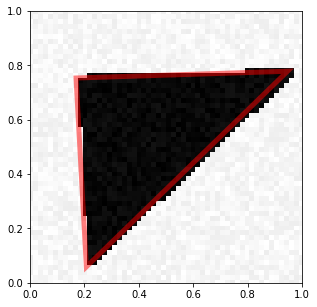

In [22]:
visualize_prediction(X_train[0], Y_train[0])
nb_of_features_output = 6

In [9]:
# Build basic linear Regression model
model = Sequential()
model.add(Dense(nb_of_features_output,input_shape=(X_train.shape[1],)))

In [10]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

history = model.fit(X_train, y_train_normalize, 
                    validation_data=(X_test, y_test_normalize), epochs=50,
                    batch_size=32)

Train on 500 samples, validate on 300 samples
Epoch 1/50


 32/500 [>.............................] - ETA: 4s - loss: 2.3888

416/500 [=======================>......] - ETA: 0s - loss: 5.0257

500/500 [==============================] - 0s 949us/step - loss: 4.6407 - val_loss: 1.8936


Epoch 2/50
 32/500 [>.............................] - ETA: 0s - loss: 2.1269



160/500 [========>.....................] - ETA: 0s - loss: 1.8560

224/500 [============>.................] - ETA: 0s - loss: 1.8043



448/500 [=========================>....] - ETA: 0s - loss: 1.6438

500/500 [==============================] - 0s 545us/step - loss: 1.5905 - val_loss: 1.2251


Epoch 3/50
 32/500 [>.............................] - ETA: 0s - loss: 1.1879

192/500 [==========>...................] - ETA: 0s - loss: 1.1771

384/500 [======================>.......] - ETA: 0s - loss: 1.1464



500/500 [==============================] - 0s 358us/step - loss: 1.1010 - val_loss: 0.9732


Epoch 4/50
 32/500 [>.............................] - ETA: 0s - loss: 1.0205

224/500 [============>.................] - ETA: 0s - loss: 0.9617

500/500 [==============================] - 0s 270us/step - loss: 0.9884 - val_loss: 0.9621


Epoch 5/50
 32/500 [>.............................] - ETA: 0s - loss: 0.9249

224/500 [============>.................] - ETA: 0s - loss: 0.9977

500/500 [==============================] - 0s 262us/step - loss: 0.9392 - val_loss: 0.9372


Epoch 6/50
 32/500 [>.............................] - ETA: 0s - loss: 0.9863



384/500 [======================>.......] - ETA: 0s - loss: 0.8970

500/500 [==============================] - 0s 210us/step - loss: 0.8946 - val_loss: 0.8941


Epoch 7/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8748

384/500 [======================>.......] - ETA: 0s - loss: 0.9132

500/500 [==============================] - 0s 230us/step - loss: 0.9433 - val_loss: 1.0356


Epoch 8/50
 32/500 [>.............................] - ETA: 0s - loss: 0.9799

320/500 [==================>...........] - ETA: 0s - loss: 0.9000

500/500 [==============================] - 0s 251us/step - loss: 0.8989 - val_loss: 0.9525


Epoch 9/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8271



320/500 [==================>...........] - ETA: 0s - loss: 0.8880

500/500 [==============================] - 0s 269us/step - loss: 0.8821 - val_loss: 0.8995


Epoch 10/50
 32/500 [>.............................] - ETA: 0s - loss: 1.0225



384/500 [======================>.......] - ETA: 0s - loss: 0.8842

500/500 [==============================] - 0s 249us/step - loss: 0.8912 - val_loss: 0.9793


Epoch 11/50
 32/500 [>.............................] - ETA: 0s - loss: 0.9731



320/500 [==================>...........] - ETA: 0s - loss: 0.8934

500/500 [==============================] - 0s 307us/step - loss: 0.9026 - val_loss: 1.0414


Epoch 12/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8977

288/500 [================>.............] - ETA: 0s - loss: 0.9202

320/500 [==================>...........] - ETA: 0s - loss: 0.9064

384/500 [======================>.......] - ETA: 0s - loss: 0.8958

416/500 [=======================>......] - ETA: 0s - loss: 0.8941



448/500 [=========================>....] - ETA: 0s - loss: 0.8922

500/500 [==============================] - 1s 1ms/step - loss: 0.8835 - val_loss: 0.9543


Epoch 13/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8541

160/500 [========>.....................] - ETA: 0s - loss: 0.8805

192/500 [==========>...................] - ETA: 0s - loss: 0.9291

320/500 [==================>...........] - ETA: 0s - loss: 0.9724



500/500 [==============================] - 0s 509us/step - loss: 0.9427 - val_loss: 0.9502


Epoch 14/50
 32/500 [>.............................] - ETA: 0s - loss: 0.9065



352/500 [====================>.........] - ETA: 0s - loss: 0.8297

500/500 [==============================] - 0s 222us/step - loss: 0.8320 - val_loss: 1.0535


Epoch 15/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8778



352/500 [====================>.........] - ETA: 0s - loss: 0.8198

500/500 [==============================] - 0s 228us/step - loss: 0.8287 - val_loss: 0.9110


Epoch 16/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8474



480/500 [===========================>..] - ETA: 0s - loss: 0.8405



500/500 [==============================] - 0s 163us/step - loss: 0.8429 - val_loss: 0.9816


Epoch 17/50
 32/500 [>.............................] - ETA: 0s - loss: 0.9291



480/500 [===========================>..] - ETA: 0s - loss: 0.8247

500/500 [==============================] - 0s 184us/step - loss: 0.8352 - val_loss: 1.0268


Epoch 18/50


 32/500 [>.............................] - ETA: 0s - loss: 0.9117

480/500 [===========================>..] - ETA: 0s - loss: 0.9193



500/500 [==============================] - 0s 171us/step - loss: 0.9176 - val_loss: 1.0062


Epoch 19/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8751

500/500 [==============================] - 0s 162us/step - loss: 0.9223 - val_loss: 0.9627


Epoch 20/50


 32/500 [>.............................] - ETA: 0s - loss: 0.6954

480/500 [===========================>..] - ETA: 0s - loss: 0.8244



500/500 [==============================] - 0s 161us/step - loss: 0.8286 - val_loss: 0.9264


Epoch 21/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6921

480/500 [===========================>..] - ETA: 0s - loss: 0.8386

500/500 [==============================] - 0s 163us/step - loss: 0.8536 - val_loss: 0.9295


Epoch 22/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7684

480/500 [===========================>..] - ETA: 0s - loss: 0.8528

500/500 [==============================] - 0s 171us/step - loss: 0.8480 - val_loss: 0.9570


Epoch 23/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8201



352/500 [====================>.........] - ETA: 0s - loss: 0.8597



500/500 [==============================] - 0s 197us/step - loss: 0.8572 - val_loss: 1.0240


Epoch 24/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8785



480/500 [===========================>..] - ETA: 0s - loss: 0.7970



500/500 [==============================] - 0s 177us/step - loss: 0.7956 - val_loss: 1.0505


Epoch 25/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8055



480/500 [===========================>..] - ETA: 0s - loss: 0.7832

500/500 [==============================] - 0s 164us/step - loss: 0.7816 - val_loss: 0.9528


Epoch 26/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7830

480/500 [===========================>..] - ETA: 0s - loss: 0.7901



500/500 [==============================] - 0s 164us/step - loss: 0.7943 - val_loss: 1.0186


Epoch 27/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7030

448/500 [=========================>....] - ETA: 0s - loss: 0.7447

500/500 [==============================] - 0s 201us/step - loss: 0.7460 - val_loss: 1.0446


Epoch 28/50


 32/500 [>.............................] - ETA: 0s - loss: 1.0188



416/500 [=======================>......] - ETA: 0s - loss: 0.8359



500/500 [==============================] - 0s 185us/step - loss: 0.8335 - val_loss: 0.9246


Epoch 29/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7712



480/500 [===========================>..] - ETA: 0s - loss: 0.7872



500/500 [==============================] - 0s 172us/step - loss: 0.7882 - val_loss: 0.8994


Epoch 30/50


 32/500 [>.............................] - ETA: 0s - loss: 0.8155



480/500 [===========================>..] - ETA: 0s - loss: 0.7989



500/500 [==============================] - 0s 168us/step - loss: 0.7979 - val_loss: 1.0552


Epoch 31/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7889

480/500 [===========================>..] - ETA: 0s - loss: 0.7928



500/500 [==============================] - 0s 172us/step - loss: 0.7903 - val_loss: 1.0158


Epoch 32/50


 32/500 [>.............................] - ETA: 0s - loss: 0.8180

448/500 [=========================>....] - ETA: 0s - loss: 0.7263

500/500 [==============================] - 0s 182us/step - loss: 0.7306 - val_loss: 1.0135


Epoch 33/50


 32/500 [>.............................] - ETA: 0s - loss: 0.8773

448/500 [=========================>....] - ETA: 0s - loss: 0.7777



500/500 [==============================] - 0s 165us/step - loss: 0.7703 - val_loss: 0.9315


Epoch 34/50
 32/500 [>.............................] - ETA: 0s - loss: 0.8300



480/500 [===========================>..] - ETA: 0s - loss: 0.7581

500/500 [==============================] - 0s 166us/step - loss: 0.7584 - val_loss: 1.1640


Epoch 35/50


 32/500 [>.............................] - ETA: 0s - loss: 0.9471

480/500 [===========================>..] - ETA: 0s - loss: 0.7865



500/500 [==============================] - 0s 168us/step - loss: 0.7858 - val_loss: 1.0446


Epoch 36/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7747

448/500 [=========================>....] - ETA: 0s - loss: 0.7741

500/500 [==============================] - 0s 175us/step - loss: 0.7787 - val_loss: 1.1783


Epoch 37/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7104

480/500 [===========================>..] - ETA: 0s - loss: 0.7080



500/500 [==============================] - 0s 157us/step - loss: 0.7124 - val_loss: 1.0248


Epoch 38/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6829



500/500 [==============================] - 0s 153us/step - loss: 0.7497 - val_loss: 0.8926


Epoch 39/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6555

480/500 [===========================>..] - ETA: 0s - loss: 0.6885



500/500 [==============================] - 0s 173us/step - loss: 0.6901 - val_loss: 0.9139


Epoch 40/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6674

500/500 [==============================] - 0s 151us/step - loss: 0.6726 - val_loss: 0.9484


Epoch 41/50
 32/500 [>.............................] - ETA: 0s - loss: 0.5643

448/500 [=========================>....] - ETA: 0s - loss: 0.7064



500/500 [==============================] - 0s 186us/step - loss: 0.7109 - val_loss: 0.9757


Epoch 42/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6990



500/500 [==============================] - 0s 153us/step - loss: 0.7084 - val_loss: 1.0696


Epoch 43/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6552

448/500 [=========================>....] - ETA: 0s - loss: 0.7252



500/500 [==============================] - 0s 166us/step - loss: 0.7230 - val_loss: 0.8962


Epoch 44/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6246

500/500 [==============================] - 0s 160us/step - loss: 0.6573 - val_loss: 0.9520


Epoch 45/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6310

384/500 [======================>.......] - ETA: 0s - loss: 0.7257

500/500 [==============================] - 0s 192us/step - loss: 0.7299 - val_loss: 0.9997


Epoch 46/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7461

448/500 [=========================>....] - ETA: 0s - loss: 0.7218

500/500 [==============================] - 0s 182us/step - loss: 0.7191 - val_loss: 1.0345


Epoch 47/50
 32/500 [>.............................] - ETA: 0s - loss: 0.7434



448/500 [=========================>....] - ETA: 0s - loss: 0.7125

500/500 [==============================] - 0s 173us/step - loss: 0.7024 - val_loss: 0.9492


Epoch 48/50


 32/500 [>.............................] - ETA: 0s - loss: 0.5833



448/500 [=========================>....] - ETA: 0s - loss: 0.6273

500/500 [==============================] - 0s 170us/step - loss: 0.6272 - val_loss: 0.9263


Epoch 49/50
 32/500 [>.............................] - ETA: 0s - loss: 0.6327



480/500 [===========================>..] - ETA: 0s - loss: 0.6619

500/500 [==============================] - 0s 163us/step - loss: 0.6683 - val_loss: 0.9295


Epoch 50/50


 32/500 [>.............................] - ETA: 0s - loss: 0.5714

448/500 [=========================>....] - ETA: 0s - loss: 0.7066

500/500 [==============================] - 0s 176us/step - loss: 0.7089 - val_loss: 1.0703


In [11]:
model.evaluate(X_test, y_test_normalize)

 32/300 [==>...........................] - ETA: 0s

300/300 [==============================] - 0s 91us/step


1.0703019587198894

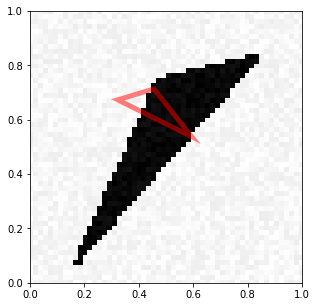

In [12]:
predictions_test = model.predict(X_test)

Y_pred = normalizer.inverse_transform(predictions_test)
visualize_prediction(X_test[100], Y_pred[100])


The previous model performs quite bad. It is underfitting the model.


In [23]:
# Let's build a more complex model
X_train = X_train.reshape((-1, 72, 72, 1))
X_test = X_test.reshape((-1, 72, 72, 1))
normalizer = StandardScaler()
y_train_normalize = normalizer.fit_transform(Y_train)
y_test_normalize = normalizer.transform(Y_test)
nb_of_features_output = 6


In [24]:
model =Sequential()

model.add(Convolution2D(40, kernel_size=(5,5), input_shape=(72,72,1,),
                        activation='relu'))
model.add(Dropout(0.3))
model.add(Convolution2D(20, kernel_size=(4,4), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(nb_of_features_output))


In [25]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

history= model.fit(X_train,y_train_normalize,validation_split=0.1,
                   epochs=50, batch_size=32)

Train on 900 samples, validate on 100 samples
Epoch 1/50


 32/900 [>.............................] - ETA: 42s - loss: 1.1648

 64/900 [=>............................] - ETA: 30s - loss: 8.3567

 96/900 [==>...........................] - ETA: 25s - loss: 6.1399

128/900 [===>..........................] - ETA: 22s - loss: 5.4406

160/900 [====>.........................] - ETA: 20s - loss: 5.0364

192/900 [=====>........................] - ETA: 19s - loss: 4.5885

224/900 [======>.......................] - ETA: 18s - loss: 4.1343

256/900 [=======>......................] - ETA: 16s - loss: 3.7503

288/900 [========>.....................] - ETA: 15s - loss: 3.4591

320/900 [=========>....................] - ETA: 14s - loss: 3.2113

352/900 [==========>...................] - ETA: 13s - loss: 3.0098

384/900 [===========>..................] - ETA: 12s - loss: 2.8535

416/900 [============>.................] - ETA: 12s - loss: 2.7205

448/900 [=============>................] - ETA: 11s - loss: 2.5962

480/900 [===============>..............] - ETA: 10s - loss: 2.4958

512/900 [================>.............] - ETA: 9s - loss: 2.3929 

544/900 [=================>............] - ETA: 8s - loss: 2.3081

576/900 [==================>...........] - ETA: 7s - loss: 2.2321

608/900 [===================>..........] - ETA: 7s - loss: 2.1627

640/900 [====================>.........] - ETA: 6s - loss: 2.1035

672/900 [=====================>........] - ETA: 5s - loss: 2.0454

704/900 [======================>.......] - ETA: 4s - loss: 1.9955

736/900 [=======================>......] - ETA: 3s - loss: 1.9425

768/900 [========================>.....] - ETA: 3s - loss: 1.9007

800/900 [=========================>....] - ETA: 2s - loss: 1.8600

832/900 [==========================>...] - ETA: 1s - loss: 1.8199

864/900 [===========================>..] - ETA: 0s - loss: 1.7860

896/900 [============================>.] - ETA: 0s - loss: 1.7438

900/900 [==============================] - 22s 25ms/step - loss: 1.7411 - val_loss: 0.5917


Epoch 2/50


 32/900 [>.............................] - ETA: 20s - loss: 0.6615

 64/900 [=>............................] - ETA: 18s - loss: 0.6614

 96/900 [==>...........................] - ETA: 17s - loss: 0.6381

128/900 [===>..........................] - ETA: 16s - loss: 0.6192

160/900 [====>.........................] - ETA: 15s - loss: 0.5975

192/900 [=====>........................] - ETA: 14s - loss: 0.6204

224/900 [======>.......................] - ETA: 14s - loss: 0.6200

256/900 [=======>......................] - ETA: 13s - loss: 0.6209

288/900 [========>.....................] - ETA: 12s - loss: 0.6217

320/900 [=========>....................] - ETA: 12s - loss: 0.6176

352/900 [==========>...................] - ETA: 11s - loss: 0.6236

384/900 [===========>..................] - ETA: 10s - loss: 0.6199

416/900 [============>.................] - ETA: 10s - loss: 0.6157

448/900 [=============>................] - ETA: 9s - loss: 0.6216 

480/900 [===============>..............] - ETA: 9s - loss: 0.6172

512/900 [================>.............] - ETA: 8s - loss: 0.6151

544/900 [=================>............] - ETA: 7s - loss: 0.6095

576/900 [==================>...........] - ETA: 7s - loss: 0.6091

608/900 [===================>..........] - ETA: 6s - loss: 0.6054

640/900 [====================>.........] - ETA: 5s - loss: 0.6020

672/900 [=====================>........] - ETA: 5s - loss: 0.6020

704/900 [======================>.......] - ETA: 4s - loss: 0.6016

736/900 [=======================>......] - ETA: 3s - loss: 0.6029

768/900 [========================>.....] - ETA: 3s - loss: 0.6034

800/900 [=========================>....] - ETA: 2s - loss: 0.5989

832/900 [==========================>...] - ETA: 1s - loss: 0.5960

864/900 [===========================>..] - ETA: 0s - loss: 0.5931

896/900 [============================>.] - ETA: 0s - loss: 0.5920

900/900 [==============================] - 24s 26ms/step - loss: 0.5911 - val_loss: 0.5326


Epoch 3/50


 32/900 [>.............................] - ETA: 28s - loss: 0.4483

 64/900 [=>............................] - ETA: 28s - loss: 0.4383

 96/900 [==>...........................] - ETA: 27s - loss: 0.4892

128/900 [===>..........................] - ETA: 26s - loss: 0.5042

160/900 [====>.........................] - ETA: 24s - loss: 0.5075

192/900 [=====>........................] - ETA: 23s - loss: 0.5250

224/900 [======>.......................] - ETA: 22s - loss: 0.5204

256/900 [=======>......................] - ETA: 21s - loss: 0.5057

288/900 [========>.....................] - ETA: 20s - loss: 0.5098

320/900 [=========>....................] - ETA: 19s - loss: 0.5056

352/900 [==========>...................] - ETA: 18s - loss: 0.4973

384/900 [===========>..................] - ETA: 17s - loss: 0.4975

416/900 [============>.................] - ETA: 16s - loss: 0.5036

448/900 [=============>................] - ETA: 15s - loss: 0.4979

480/900 [===============>..............] - ETA: 13s - loss: 0.4914

512/900 [================>.............] - ETA: 12s - loss: 0.4901

544/900 [=================>............] - ETA: 11s - loss: 0.4877

576/900 [==================>...........] - ETA: 10s - loss: 0.4891

608/900 [===================>..........] - ETA: 9s - loss: 0.4885 

640/900 [====================>.........] - ETA: 8s - loss: 0.4865

672/900 [=====================>........] - ETA: 7s - loss: 0.4814

704/900 [======================>.......] - ETA: 6s - loss: 0.4824

736/900 [=======================>......] - ETA: 5s - loss: 0.4865

768/900 [========================>.....] - ETA: 4s - loss: 0.4852

800/900 [=========================>....] - ETA: 3s - loss: 0.4819

832/900 [==========================>...] - ETA: 2s - loss: 0.4790

864/900 [===========================>..] - ETA: 1s - loss: 0.4819

896/900 [============================>.] - ETA: 0s - loss: 0.4811

900/900 [==============================] - 31s 34ms/step - loss: 0.4817 - val_loss: 0.4392


Epoch 4/50


 32/900 [>.............................] - ETA: 27s - loss: 0.4465

 64/900 [=>............................] - ETA: 22s - loss: 0.4565

 96/900 [==>...........................] - ETA: 19s - loss: 0.4355

128/900 [===>..........................] - ETA: 18s - loss: 0.4351

160/900 [====>.........................] - ETA: 17s - loss: 0.4326

192/900 [=====>........................] - ETA: 16s - loss: 0.4225

224/900 [======>.......................] - ETA: 15s - loss: 0.4188

256/900 [=======>......................] - ETA: 14s - loss: 0.4290

288/900 [========>.....................] - ETA: 13s - loss: 0.4184

320/900 [=========>....................] - ETA: 13s - loss: 0.4175

352/900 [==========>...................] - ETA: 12s - loss: 0.4126

384/900 [===========>..................] - ETA: 12s - loss: 0.4096

416/900 [============>.................] - ETA: 11s - loss: 0.4082

448/900 [=============>................] - ETA: 10s - loss: 0.4102

480/900 [===============>..............] - ETA: 10s - loss: 0.4095

512/900 [================>.............] - ETA: 9s - loss: 0.4060 

544/900 [=================>............] - ETA: 8s - loss: 0.4016

576/900 [==================>...........] - ETA: 7s - loss: 0.4029

608/900 [===================>..........] - ETA: 6s - loss: 0.4016

640/900 [====================>.........] - ETA: 6s - loss: 0.4058

672/900 [=====================>........] - ETA: 5s - loss: 0.4064

704/900 [======================>.......] - ETA: 4s - loss: 0.4034

736/900 [=======================>......] - ETA: 3s - loss: 0.3998

768/900 [========================>.....] - ETA: 3s - loss: 0.3963

800/900 [=========================>....] - ETA: 2s - loss: 0.3925

832/900 [==========================>...] - ETA: 1s - loss: 0.3911

864/900 [===========================>..] - ETA: 0s - loss: 0.3921

896/900 [============================>.] - ETA: 0s - loss: 0.3912

900/900 [==============================] - 25s 28ms/step - loss: 0.3905 - val_loss: 0.4727


Epoch 5/50


 32/900 [>.............................] - ETA: 32s - loss: 0.3652

 64/900 [=>............................] - ETA: 30s - loss: 0.3826

 96/900 [==>...........................] - ETA: 29s - loss: 0.3561

128/900 [===>..........................] - ETA: 27s - loss: 0.3611

160/900 [====>.........................] - ETA: 26s - loss: 0.3430

192/900 [=====>........................] - ETA: 25s - loss: 0.3266

224/900 [======>.......................] - ETA: 24s - loss: 0.3175

256/900 [=======>......................] - ETA: 23s - loss: 0.3139

288/900 [========>.....................] - ETA: 22s - loss: 0.3124

320/900 [=========>....................] - ETA: 21s - loss: 0.3098

352/900 [==========>...................] - ETA: 20s - loss: 0.3049

384/900 [===========>..................] - ETA: 19s - loss: 0.3042

416/900 [============>.................] - ETA: 17s - loss: 0.2978

448/900 [=============>................] - ETA: 16s - loss: 0.2977

480/900 [===============>..............] - ETA: 15s - loss: 0.2984

512/900 [================>.............] - ETA: 14s - loss: 0.3011

544/900 [=================>............] - ETA: 13s - loss: 0.3014

576/900 [==================>...........] - ETA: 11s - loss: 0.3005

608/900 [===================>..........] - ETA: 10s - loss: 0.2980

640/900 [====================>.........] - ETA: 9s - loss: 0.3012 

672/900 [=====================>........] - ETA: 8s - loss: 0.3019

704/900 [======================>.......] - ETA: 7s - loss: 0.3037

736/900 [=======================>......] - ETA: 5s - loss: 0.3033

768/900 [========================>.....] - ETA: 4s - loss: 0.3031

800/900 [=========================>....] - ETA: 3s - loss: 0.3047

832/900 [==========================>...] - ETA: 2s - loss: 0.3042

864/900 [===========================>..] - ETA: 1s - loss: 0.3075

896/900 [============================>.] - ETA: 0s - loss: 0.3097

900/900 [==============================] - 34s 38ms/step - loss: 0.3099 - val_loss: 0.4201


Epoch 6/50


 32/900 [>.............................] - ETA: 28s - loss: 0.2776

 64/900 [=>............................] - ETA: 27s - loss: 0.2736

 96/900 [==>...........................] - ETA: 26s - loss: 0.2703

128/900 [===>..........................] - ETA: 25s - loss: 0.2694

160/900 [====>.........................] - ETA: 23s - loss: 0.2516

192/900 [=====>........................] - ETA: 22s - loss: 0.2618

224/900 [======>.......................] - ETA: 21s - loss: 0.2542

256/900 [=======>......................] - ETA: 20s - loss: 0.2618

288/900 [========>.....................] - ETA: 19s - loss: 0.2576

320/900 [=========>....................] - ETA: 18s - loss: 0.2645

352/900 [==========>...................] - ETA: 17s - loss: 0.2607

384/900 [===========>..................] - ETA: 16s - loss: 0.2591

416/900 [============>.................] - ETA: 15s - loss: 0.2566

448/900 [=============>................] - ETA: 14s - loss: 0.2557

480/900 [===============>..............] - ETA: 13s - loss: 0.2566

512/900 [================>.............] - ETA: 12s - loss: 0.2581

544/900 [=================>............] - ETA: 11s - loss: 0.2604

576/900 [==================>...........] - ETA: 10s - loss: 0.2627

608/900 [===================>..........] - ETA: 9s - loss: 0.2630 

640/900 [====================>.........] - ETA: 8s - loss: 0.2621

672/900 [=====================>........] - ETA: 7s - loss: 0.2603

704/900 [======================>.......] - ETA: 6s - loss: 0.2600

736/900 [=======================>......] - ETA: 5s - loss: 0.2624

768/900 [========================>.....] - ETA: 4s - loss: 0.2636

800/900 [=========================>....] - ETA: 3s - loss: 0.2636

832/900 [==========================>...] - ETA: 2s - loss: 0.2622

864/900 [===========================>..] - ETA: 1s - loss: 0.2615

896/900 [============================>.] - ETA: 0s - loss: 0.2608

900/900 [==============================] - 31s 34ms/step - loss: 0.2610 - val_loss: 0.3998


Epoch 7/50


 32/900 [>.............................] - ETA: 28s - loss: 0.2014

 64/900 [=>............................] - ETA: 27s - loss: 0.2035

 96/900 [==>...........................] - ETA: 27s - loss: 0.2198

128/900 [===>..........................] - ETA: 25s - loss: 0.2124

160/900 [====>.........................] - ETA: 24s - loss: 0.2081

192/900 [=====>........................] - ETA: 23s - loss: 0.2160

224/900 [======>.......................] - ETA: 22s - loss: 0.2174

256/900 [=======>......................] - ETA: 21s - loss: 0.2182

288/900 [========>.....................] - ETA: 20s - loss: 0.2208

320/900 [=========>....................] - ETA: 19s - loss: 0.2196

352/900 [==========>...................] - ETA: 18s - loss: 0.2230

384/900 [===========>..................] - ETA: 16s - loss: 0.2217

416/900 [============>.................] - ETA: 15s - loss: 0.2205

448/900 [=============>................] - ETA: 14s - loss: 0.2212

480/900 [===============>..............] - ETA: 13s - loss: 0.2170

512/900 [================>.............] - ETA: 12s - loss: 0.2201

544/900 [=================>............] - ETA: 11s - loss: 0.2184

576/900 [==================>...........] - ETA: 10s - loss: 0.2154

608/900 [===================>..........] - ETA: 9s - loss: 0.2172 

640/900 [====================>.........] - ETA: 8s - loss: 0.2183

672/900 [=====================>........] - ETA: 7s - loss: 0.2191

704/900 [======================>.......] - ETA: 6s - loss: 0.2203

736/900 [=======================>......] - ETA: 5s - loss: 0.2225

768/900 [========================>.....] - ETA: 4s - loss: 0.2236

800/900 [=========================>....] - ETA: 3s - loss: 0.2255

832/900 [==========================>...] - ETA: 2s - loss: 0.2255

864/900 [===========================>..] - ETA: 1s - loss: 0.2267

896/900 [============================>.] - ETA: 0s - loss: 0.2278

900/900 [==============================] - 30s 33ms/step - loss: 0.2277 - val_loss: 0.3789


Epoch 8/50


 32/900 [>.............................] - ETA: 27s - loss: 0.1816

 64/900 [=>............................] - ETA: 25s - loss: 0.2165

 96/900 [==>...........................] - ETA: 24s - loss: 0.2175

128/900 [===>..........................] - ETA: 23s - loss: 0.2040

160/900 [====>.........................] - ETA: 22s - loss: 0.2045

192/900 [=====>........................] - ETA: 21s - loss: 0.1960

224/900 [======>.......................] - ETA: 20s - loss: 0.1953

256/900 [=======>......................] - ETA: 19s - loss: 0.1877

288/900 [========>.....................] - ETA: 19s - loss: 0.1919

320/900 [=========>....................] - ETA: 18s - loss: 0.1927

352/900 [==========>...................] - ETA: 17s - loss: 0.1965

384/900 [===========>..................] - ETA: 16s - loss: 0.1964

416/900 [============>.................] - ETA: 15s - loss: 0.1947

448/900 [=============>................] - ETA: 14s - loss: 0.1998

480/900 [===============>..............] - ETA: 13s - loss: 0.1987

512/900 [================>.............] - ETA: 12s - loss: 0.1975

544/900 [=================>............] - ETA: 11s - loss: 0.1986

576/900 [==================>...........] - ETA: 10s - loss: 0.1992

608/900 [===================>..........] - ETA: 9s - loss: 0.1971 

640/900 [====================>.........] - ETA: 8s - loss: 0.1977

672/900 [=====================>........] - ETA: 7s - loss: 0.2011

704/900 [======================>.......] - ETA: 6s - loss: 0.2018

736/900 [=======================>......] - ETA: 5s - loss: 0.2025

768/900 [========================>.....] - ETA: 4s - loss: 0.2024

800/900 [=========================>....] - ETA: 3s - loss: 0.2021

832/900 [==========================>...] - ETA: 2s - loss: 0.2033

864/900 [===========================>..] - ETA: 1s - loss: 0.2027

896/900 [============================>.] - ETA: 0s - loss: 0.2056

900/900 [==============================] - 30s 33ms/step - loss: 0.2054 - val_loss: 0.3584


Epoch 9/50


 32/900 [>.............................] - ETA: 27s - loss: 0.1724

 64/900 [=>............................] - ETA: 26s - loss: 0.1637

 96/900 [==>...........................] - ETA: 24s - loss: 0.1666

128/900 [===>..........................] - ETA: 23s - loss: 0.1903

160/900 [====>.........................] - ETA: 22s - loss: 0.1820

192/900 [=====>........................] - ETA: 21s - loss: 0.1859

224/900 [======>.......................] - ETA: 20s - loss: 0.1815

256/900 [=======>......................] - ETA: 19s - loss: 0.1818

288/900 [========>.....................] - ETA: 18s - loss: 0.1854

320/900 [=========>....................] - ETA: 17s - loss: 0.1882

352/900 [==========>...................] - ETA: 16s - loss: 0.1875

384/900 [===========>..................] - ETA: 15s - loss: 0.1817

416/900 [============>.................] - ETA: 14s - loss: 0.1816

448/900 [=============>................] - ETA: 13s - loss: 0.1829

480/900 [===============>..............] - ETA: 12s - loss: 0.1822

512/900 [================>.............] - ETA: 11s - loss: 0.1838

544/900 [=================>............] - ETA: 10s - loss: 0.1841

576/900 [==================>...........] - ETA: 9s - loss: 0.1840 

608/900 [===================>..........] - ETA: 8s - loss: 0.1829

640/900 [====================>.........] - ETA: 8s - loss: 0.1807

672/900 [=====================>........] - ETA: 7s - loss: 0.1785

704/900 [======================>.......] - ETA: 6s - loss: 0.1775

736/900 [=======================>......] - ETA: 5s - loss: 0.1778

768/900 [========================>.....] - ETA: 4s - loss: 0.1789

800/900 [=========================>....] - ETA: 3s - loss: 0.1785

832/900 [==========================>...] - ETA: 2s - loss: 0.1796

864/900 [===========================>..] - ETA: 1s - loss: 0.1801

896/900 [============================>.] - ETA: 0s - loss: 0.1798

900/900 [==============================] - 29s 32ms/step - loss: 0.1796 - val_loss: 0.3661


Epoch 10/50


 32/900 [>.............................] - ETA: 28s - loss: 0.1531

 64/900 [=>............................] - ETA: 27s - loss: 0.1361

 96/900 [==>...........................] - ETA: 26s - loss: 0.1261

128/900 [===>..........................] - ETA: 25s - loss: 0.1412

160/900 [====>.........................] - ETA: 24s - loss: 0.1359

192/900 [=====>........................] - ETA: 22s - loss: 0.1330

224/900 [======>.......................] - ETA: 21s - loss: 0.1384

256/900 [=======>......................] - ETA: 20s - loss: 0.1439

288/900 [========>.....................] - ETA: 19s - loss: 0.1491

320/900 [=========>....................] - ETA: 18s - loss: 0.1471

352/900 [==========>...................] - ETA: 17s - loss: 0.1476

384/900 [===========>..................] - ETA: 16s - loss: 0.1487

416/900 [============>.................] - ETA: 15s - loss: 0.1490

448/900 [=============>................] - ETA: 14s - loss: 0.1474

480/900 [===============>..............] - ETA: 13s - loss: 0.1524

512/900 [================>.............] - ETA: 12s - loss: 0.1541

544/900 [=================>............] - ETA: 11s - loss: 0.1515

576/900 [==================>...........] - ETA: 10s - loss: 0.1520

608/900 [===================>..........] - ETA: 9s - loss: 0.1516 

640/900 [====================>.........] - ETA: 8s - loss: 0.1519

672/900 [=====================>........] - ETA: 7s - loss: 0.1519

704/900 [======================>.......] - ETA: 6s - loss: 0.1522

736/900 [=======================>......] - ETA: 5s - loss: 0.1515

768/900 [========================>.....] - ETA: 4s - loss: 0.1535

800/900 [=========================>....] - ETA: 3s - loss: 0.1531

832/900 [==========================>...] - ETA: 2s - loss: 0.1525

864/900 [===========================>..] - ETA: 1s - loss: 0.1519

896/900 [============================>.] - ETA: 0s - loss: 0.1511

900/900 [==============================] - 29s 32ms/step - loss: 0.1510 - val_loss: 0.3712


Epoch 11/50


 32/900 [>.............................] - ETA: 27s - loss: 0.1382

 64/900 [=>............................] - ETA: 25s - loss: 0.1231

 96/900 [==>...........................] - ETA: 25s - loss: 0.1267

128/900 [===>..........................] - ETA: 24s - loss: 0.1260

160/900 [====>.........................] - ETA: 23s - loss: 0.1378

192/900 [=====>........................] - ETA: 22s - loss: 0.1423

224/900 [======>.......................] - ETA: 21s - loss: 0.1390

256/900 [=======>......................] - ETA: 20s - loss: 0.1376

288/900 [========>.....................] - ETA: 19s - loss: 0.1384

320/900 [=========>....................] - ETA: 18s - loss: 0.1372

352/900 [==========>...................] - ETA: 17s - loss: 0.1376

384/900 [===========>..................] - ETA: 16s - loss: 0.1370

416/900 [============>.................] - ETA: 15s - loss: 0.1358

448/900 [=============>................] - ETA: 14s - loss: 0.1359

480/900 [===============>..............] - ETA: 13s - loss: 0.1367

512/900 [================>.............] - ETA: 12s - loss: 0.1360

544/900 [=================>............] - ETA: 11s - loss: 0.1347

576/900 [==================>...........] - ETA: 10s - loss: 0.1346

608/900 [===================>..........] - ETA: 9s - loss: 0.1342 

640/900 [====================>.........] - ETA: 8s - loss: 0.1369

672/900 [=====================>........] - ETA: 7s - loss: 0.1385

704/900 [======================>.......] - ETA: 6s - loss: 0.1391

736/900 [=======================>......] - ETA: 5s - loss: 0.1406

768/900 [========================>.....] - ETA: 4s - loss: 0.1402

800/900 [=========================>....] - ETA: 3s - loss: 0.1404

832/900 [==========================>...] - ETA: 2s - loss: 0.1401

864/900 [===========================>..] - ETA: 1s - loss: 0.1403

896/900 [============================>.] - ETA: 0s - loss: 0.1395

900/900 [==============================] - 30s 33ms/step - loss: 0.1393 - val_loss: 0.3498


Epoch 12/50


 32/900 [>.............................] - ETA: 28s - loss: 0.1259

 64/900 [=>............................] - ETA: 27s - loss: 0.1081

 96/900 [==>...........................] - ETA: 25s - loss: 0.1234

128/900 [===>..........................] - ETA: 24s - loss: 0.1219

160/900 [====>.........................] - ETA: 23s - loss: 0.1390

192/900 [=====>........................] - ETA: 22s - loss: 0.1438

224/900 [======>.......................] - ETA: 21s - loss: 0.1399

256/900 [=======>......................] - ETA: 20s - loss: 0.1396

288/900 [========>.....................] - ETA: 19s - loss: 0.1397

320/900 [=========>....................] - ETA: 18s - loss: 0.1424

352/900 [==========>...................] - ETA: 17s - loss: 0.1413

384/900 [===========>..................] - ETA: 16s - loss: 0.1421

416/900 [============>.................] - ETA: 15s - loss: 0.1431

448/900 [=============>................] - ETA: 14s - loss: 0.1432

480/900 [===============>..............] - ETA: 13s - loss: 0.1422

512/900 [================>.............] - ETA: 12s - loss: 0.1423

544/900 [=================>............] - ETA: 11s - loss: 0.1411

576/900 [==================>...........] - ETA: 10s - loss: 0.1393

608/900 [===================>..........] - ETA: 9s - loss: 0.1380 

640/900 [====================>.........] - ETA: 8s - loss: 0.1368

672/900 [=====================>........] - ETA: 7s - loss: 0.1350

704/900 [======================>.......] - ETA: 6s - loss: 0.1346

736/900 [=======================>......] - ETA: 5s - loss: 0.1355

768/900 [========================>.....] - ETA: 4s - loss: 0.1350

800/900 [=========================>....] - ETA: 3s - loss: 0.1345

832/900 [==========================>...] - ETA: 2s - loss: 0.1351

864/900 [===========================>..] - ETA: 1s - loss: 0.1350

896/900 [============================>.] - ETA: 0s - loss: 0.1340

900/900 [==============================] - 30s 33ms/step - loss: 0.1338 - val_loss: 0.3400


Epoch 13/50


 32/900 [>.............................] - ETA: 23s - loss: 0.1235

 64/900 [=>............................] - ETA: 23s - loss: 0.1131

 96/900 [==>...........................] - ETA: 23s - loss: 0.1054

128/900 [===>..........................] - ETA: 22s - loss: 0.1054

160/900 [====>.........................] - ETA: 21s - loss: 0.1083

192/900 [=====>........................] - ETA: 20s - loss: 0.1051

224/900 [======>.......................] - ETA: 20s - loss: 0.1030

256/900 [=======>......................] - ETA: 19s - loss: 0.1052

288/900 [========>.....................] - ETA: 18s - loss: 0.1084

320/900 [=========>....................] - ETA: 17s - loss: 0.1099

352/900 [==========>...................] - ETA: 16s - loss: 0.1109

384/900 [===========>..................] - ETA: 15s - loss: 0.1120

416/900 [============>.................] - ETA: 14s - loss: 0.1165

448/900 [=============>................] - ETA: 13s - loss: 0.1175

480/900 [===============>..............] - ETA: 12s - loss: 0.1170

512/900 [================>.............] - ETA: 11s - loss: 0.1162

544/900 [=================>............] - ETA: 10s - loss: 0.1154

576/900 [==================>...........] - ETA: 9s - loss: 0.1163 

608/900 [===================>..........] - ETA: 9s - loss: 0.1181

640/900 [====================>.........] - ETA: 8s - loss: 0.1195

672/900 [=====================>........] - ETA: 7s - loss: 0.1192

704/900 [======================>.......] - ETA: 6s - loss: 0.1199

736/900 [=======================>......] - ETA: 5s - loss: 0.1206

768/900 [========================>.....] - ETA: 4s - loss: 0.1217

800/900 [=========================>....] - ETA: 3s - loss: 0.1217

832/900 [==========================>...] - ETA: 2s - loss: 0.1209

864/900 [===========================>..] - ETA: 1s - loss: 0.1226

896/900 [============================>.] - ETA: 0s - loss: 0.1221

900/900 [==============================] - 29s 32ms/step - loss: 0.1225 - val_loss: 0.3306


Epoch 14/50


 32/900 [>.............................] - ETA: 25s - loss: 0.0736

 64/900 [=>............................] - ETA: 24s - loss: 0.0780

 96/900 [==>...........................] - ETA: 24s - loss: 0.1004

128/900 [===>..........................] - ETA: 22s - loss: 0.1049

160/900 [====>.........................] - ETA: 22s - loss: 0.0997

192/900 [=====>........................] - ETA: 21s - loss: 0.0955

224/900 [======>.......................] - ETA: 20s - loss: 0.0998

256/900 [=======>......................] - ETA: 19s - loss: 0.0999

288/900 [========>.....................] - ETA: 18s - loss: 0.0987

320/900 [=========>....................] - ETA: 17s - loss: 0.1001

352/900 [==========>...................] - ETA: 16s - loss: 0.1007

384/900 [===========>..................] - ETA: 15s - loss: 0.1001

416/900 [============>.................] - ETA: 14s - loss: 0.1013

448/900 [=============>................] - ETA: 14s - loss: 0.1005

480/900 [===============>..............] - ETA: 13s - loss: 0.1019

512/900 [================>.............] - ETA: 12s - loss: 0.1033

544/900 [=================>............] - ETA: 11s - loss: 0.1024

576/900 [==================>...........] - ETA: 10s - loss: 0.1024

608/900 [===================>..........] - ETA: 9s - loss: 0.1026 

640/900 [====================>.........] - ETA: 8s - loss: 0.1032

672/900 [=====================>........] - ETA: 7s - loss: 0.1028

704/900 [======================>.......] - ETA: 6s - loss: 0.1027

736/900 [=======================>......] - ETA: 5s - loss: 0.1025

768/900 [========================>.....] - ETA: 4s - loss: 0.1030

800/900 [=========================>....] - ETA: 3s - loss: 0.1043

832/900 [==========================>...] - ETA: 2s - loss: 0.1041

864/900 [===========================>..] - ETA: 1s - loss: 0.1037

896/900 [============================>.] - ETA: 0s - loss: 0.1040

900/900 [==============================] - 30s 33ms/step - loss: 0.1040 - val_loss: 0.3119


Epoch 15/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0973

 64/900 [=>............................] - ETA: 27s - loss: 0.0917

 96/900 [==>...........................] - ETA: 26s - loss: 0.1244

128/900 [===>..........................] - ETA: 25s - loss: 0.1136

160/900 [====>.........................] - ETA: 24s - loss: 0.1071

192/900 [=====>........................] - ETA: 23s - loss: 0.1039

224/900 [======>.......................] - ETA: 22s - loss: 0.1040

256/900 [=======>......................] - ETA: 21s - loss: 0.1072

288/900 [========>.....................] - ETA: 20s - loss: 0.1085

320/900 [=========>....................] - ETA: 19s - loss: 0.1082

352/900 [==========>...................] - ETA: 18s - loss: 0.1070

384/900 [===========>..................] - ETA: 17s - loss: 0.1046

416/900 [============>.................] - ETA: 16s - loss: 0.1036

448/900 [=============>................] - ETA: 14s - loss: 0.1024

480/900 [===============>..............] - ETA: 13s - loss: 0.1018

512/900 [================>.............] - ETA: 12s - loss: 0.1015

544/900 [=================>............] - ETA: 11s - loss: 0.1010

576/900 [==================>...........] - ETA: 10s - loss: 0.1010

608/900 [===================>..........] - ETA: 9s - loss: 0.1011 

640/900 [====================>.........] - ETA: 8s - loss: 0.1002

672/900 [=====================>........] - ETA: 7s - loss: 0.0995

704/900 [======================>.......] - ETA: 6s - loss: 0.0992

736/900 [=======================>......] - ETA: 5s - loss: 0.1001

768/900 [========================>.....] - ETA: 4s - loss: 0.0998

800/900 [=========================>....] - ETA: 3s - loss: 0.0999

832/900 [==========================>...] - ETA: 2s - loss: 0.0991

864/900 [===========================>..] - ETA: 1s - loss: 0.0997

896/900 [============================>.] - ETA: 0s - loss: 0.0989

900/900 [==============================] - 30s 33ms/step - loss: 0.0988 - val_loss: 0.2986


Epoch 16/50


 32/900 [>.............................] - ETA: 25s - loss: 0.1056

 64/900 [=>............................] - ETA: 23s - loss: 0.0870

 96/900 [==>...........................] - ETA: 23s - loss: 0.0853

128/900 [===>..........................] - ETA: 22s - loss: 0.0957

160/900 [====>.........................] - ETA: 22s - loss: 0.0939

192/900 [=====>........................] - ETA: 21s - loss: 0.0922

224/900 [======>.......................] - ETA: 20s - loss: 0.0938

256/900 [=======>......................] - ETA: 19s - loss: 0.0917

288/900 [========>.....................] - ETA: 18s - loss: 0.0888

320/900 [=========>....................] - ETA: 17s - loss: 0.0896

352/900 [==========>...................] - ETA: 16s - loss: 0.0904

384/900 [===========>..................] - ETA: 15s - loss: 0.0907

416/900 [============>.................] - ETA: 14s - loss: 0.0892

448/900 [=============>................] - ETA: 13s - loss: 0.0895

480/900 [===============>..............] - ETA: 12s - loss: 0.0914

512/900 [================>.............] - ETA: 11s - loss: 0.0915

544/900 [=================>............] - ETA: 10s - loss: 0.0936

576/900 [==================>...........] - ETA: 9s - loss: 0.0923 

608/900 [===================>..........] - ETA: 8s - loss: 0.0911

640/900 [====================>.........] - ETA: 7s - loss: 0.0919

672/900 [=====================>........] - ETA: 6s - loss: 0.0916

704/900 [======================>.......] - ETA: 5s - loss: 0.0913

736/900 [=======================>......] - ETA: 4s - loss: 0.0906

768/900 [========================>.....] - ETA: 4s - loss: 0.0909

800/900 [=========================>....] - ETA: 3s - loss: 0.0902

832/900 [==========================>...] - ETA: 2s - loss: 0.0904

864/900 [===========================>..] - ETA: 1s - loss: 0.0911

896/900 [============================>.] - ETA: 0s - loss: 0.0912

900/900 [==============================] - 29s 32ms/step - loss: 0.0911 - val_loss: 0.3044


Epoch 17/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0881

 64/900 [=>............................] - ETA: 27s - loss: 0.0862

 96/900 [==>...........................] - ETA: 26s - loss: 0.0791

128/900 [===>..........................] - ETA: 24s - loss: 0.0799

160/900 [====>.........................] - ETA: 23s - loss: 0.0758

192/900 [=====>........................] - ETA: 22s - loss: 0.0771

224/900 [======>.......................] - ETA: 21s - loss: 0.0783

256/900 [=======>......................] - ETA: 20s - loss: 0.0784

288/900 [========>.....................] - ETA: 19s - loss: 0.0790

320/900 [=========>....................] - ETA: 18s - loss: 0.0817

352/900 [==========>...................] - ETA: 17s - loss: 0.0814

384/900 [===========>..................] - ETA: 16s - loss: 0.0836

416/900 [============>.................] - ETA: 15s - loss: 0.0826

448/900 [=============>................] - ETA: 14s - loss: 0.0829

480/900 [===============>..............] - ETA: 13s - loss: 0.0826

512/900 [================>.............] - ETA: 11s - loss: 0.0832

544/900 [=================>............] - ETA: 10s - loss: 0.0858

576/900 [==================>...........] - ETA: 9s - loss: 0.0857 

608/900 [===================>..........] - ETA: 8s - loss: 0.0864

640/900 [====================>.........] - ETA: 8s - loss: 0.0866

672/900 [=====================>........] - ETA: 7s - loss: 0.0864

704/900 [======================>.......] - ETA: 6s - loss: 0.0859

736/900 [=======================>......] - ETA: 5s - loss: 0.0856

768/900 [========================>.....] - ETA: 4s - loss: 0.0856

800/900 [=========================>....] - ETA: 3s - loss: 0.0856

832/900 [==========================>...] - ETA: 2s - loss: 0.0849

864/900 [===========================>..] - ETA: 1s - loss: 0.0857

896/900 [============================>.] - ETA: 0s - loss: 0.0858

900/900 [==============================] - 29s 32ms/step - loss: 0.0859 - val_loss: 0.3153


Epoch 18/50


 32/900 [>.............................] - ETA: 25s - loss: 0.0753

 64/900 [=>............................] - ETA: 25s - loss: 0.0856

 96/900 [==>...........................] - ETA: 24s - loss: 0.0876

128/900 [===>..........................] - ETA: 23s - loss: 0.0852

160/900 [====>.........................] - ETA: 22s - loss: 0.0850

192/900 [=====>........................] - ETA: 21s - loss: 0.0818

224/900 [======>.......................] - ETA: 20s - loss: 0.0774

256/900 [=======>......................] - ETA: 19s - loss: 0.0798

288/900 [========>.....................] - ETA: 18s - loss: 0.0788

320/900 [=========>....................] - ETA: 17s - loss: 0.0782

352/900 [==========>...................] - ETA: 16s - loss: 0.0783

384/900 [===========>..................] - ETA: 15s - loss: 0.0773

416/900 [============>.................] - ETA: 14s - loss: 0.0779

448/900 [=============>................] - ETA: 13s - loss: 0.0782

480/900 [===============>..............] - ETA: 12s - loss: 0.0800

512/900 [================>.............] - ETA: 11s - loss: 0.0794

544/900 [=================>............] - ETA: 10s - loss: 0.0796

576/900 [==================>...........] - ETA: 9s - loss: 0.0797 

608/900 [===================>..........] - ETA: 8s - loss: 0.0793

640/900 [====================>.........] - ETA: 7s - loss: 0.0784

672/900 [=====================>........] - ETA: 6s - loss: 0.0787

704/900 [======================>.......] - ETA: 5s - loss: 0.0785

736/900 [=======================>......] - ETA: 4s - loss: 0.0783

768/900 [========================>.....] - ETA: 3s - loss: 0.0794

800/900 [=========================>....] - ETA: 3s - loss: 0.0788

832/900 [==========================>...] - ETA: 2s - loss: 0.0790

864/900 [===========================>..] - ETA: 1s - loss: 0.0795

896/900 [============================>.] - ETA: 0s - loss: 0.0794

900/900 [==============================] - 28s 32ms/step - loss: 0.0793 - val_loss: 0.3110


Epoch 19/50


 32/900 [>.............................] - ETA: 26s - loss: 0.0794

 64/900 [=>............................] - ETA: 27s - loss: 0.0837

 96/900 [==>...........................] - ETA: 26s - loss: 0.0817

128/900 [===>..........................] - ETA: 25s - loss: 0.0783

160/900 [====>.........................] - ETA: 23s - loss: 0.0762

192/900 [=====>........................] - ETA: 22s - loss: 0.0791

224/900 [======>.......................] - ETA: 21s - loss: 0.0792

256/900 [=======>......................] - ETA: 20s - loss: 0.0776

288/900 [========>.....................] - ETA: 19s - loss: 0.0790

320/900 [=========>....................] - ETA: 18s - loss: 0.0789

352/900 [==========>...................] - ETA: 17s - loss: 0.0793

384/900 [===========>..................] - ETA: 16s - loss: 0.0791

416/900 [============>.................] - ETA: 15s - loss: 0.0798

448/900 [=============>................] - ETA: 14s - loss: 0.0809

480/900 [===============>..............] - ETA: 13s - loss: 0.0812

512/900 [================>.............] - ETA: 12s - loss: 0.0810

544/900 [=================>............] - ETA: 11s - loss: 0.0808

576/900 [==================>...........] - ETA: 10s - loss: 0.0801

608/900 [===================>..........] - ETA: 9s - loss: 0.0800 

640/900 [====================>.........] - ETA: 8s - loss: 0.0804

672/900 [=====================>........] - ETA: 7s - loss: 0.0804

704/900 [======================>.......] - ETA: 6s - loss: 0.0799

736/900 [=======================>......] - ETA: 5s - loss: 0.0794

768/900 [========================>.....] - ETA: 4s - loss: 0.0795

800/900 [=========================>....] - ETA: 3s - loss: 0.0800

832/900 [==========================>...] - ETA: 2s - loss: 0.0796

864/900 [===========================>..] - ETA: 1s - loss: 0.0793

896/900 [============================>.] - ETA: 0s - loss: 0.0791

900/900 [==============================] - 29s 33ms/step - loss: 0.0789 - val_loss: 0.2940


Epoch 20/50


 32/900 [>.............................] - ETA: 26s - loss: 0.0852

 64/900 [=>............................] - ETA: 26s - loss: 0.0752

 96/900 [==>...........................] - ETA: 25s - loss: 0.0786

128/900 [===>..........................] - ETA: 24s - loss: 0.0760

160/900 [====>.........................] - ETA: 24s - loss: 0.0784

192/900 [=====>........................] - ETA: 23s - loss: 0.0781

224/900 [======>.......................] - ETA: 22s - loss: 0.0760

256/900 [=======>......................] - ETA: 21s - loss: 0.0758

288/900 [========>.....................] - ETA: 19s - loss: 0.0795

320/900 [=========>....................] - ETA: 18s - loss: 0.0782

352/900 [==========>...................] - ETA: 17s - loss: 0.0790

384/900 [===========>..................] - ETA: 16s - loss: 0.0790

416/900 [============>.................] - ETA: 15s - loss: 0.0796

448/900 [=============>................] - ETA: 14s - loss: 0.0788

480/900 [===============>..............] - ETA: 13s - loss: 0.0779

512/900 [================>.............] - ETA: 12s - loss: 0.0794

544/900 [=================>............] - ETA: 11s - loss: 0.0796

576/900 [==================>...........] - ETA: 10s - loss: 0.0781

608/900 [===================>..........] - ETA: 9s - loss: 0.0788 

640/900 [====================>.........] - ETA: 8s - loss: 0.0777

672/900 [=====================>........] - ETA: 7s - loss: 0.0767

704/900 [======================>.......] - ETA: 6s - loss: 0.0772

736/900 [=======================>......] - ETA: 5s - loss: 0.0772

768/900 [========================>.....] - ETA: 4s - loss: 0.0768

800/900 [=========================>....] - ETA: 3s - loss: 0.0771

832/900 [==========================>...] - ETA: 2s - loss: 0.0773

864/900 [===========================>..] - ETA: 1s - loss: 0.0775

896/900 [============================>.] - ETA: 0s - loss: 0.0783

900/900 [==============================] - 31s 34ms/step - loss: 0.0781 - val_loss: 0.2858


Epoch 21/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0694

 64/900 [=>............................] - ETA: 27s - loss: 0.0669

 96/900 [==>...........................] - ETA: 26s - loss: 0.0697

128/900 [===>..........................] - ETA: 25s - loss: 0.0706

160/900 [====>.........................] - ETA: 24s - loss: 0.0724

192/900 [=====>........................] - ETA: 23s - loss: 0.0709

224/900 [======>.......................] - ETA: 22s - loss: 0.0697

256/900 [=======>......................] - ETA: 21s - loss: 0.0696

288/900 [========>.....................] - ETA: 20s - loss: 0.0683

320/900 [=========>....................] - ETA: 18s - loss: 0.0683

352/900 [==========>...................] - ETA: 17s - loss: 0.0681

384/900 [===========>..................] - ETA: 16s - loss: 0.0681

416/900 [============>.................] - ETA: 15s - loss: 0.0681

448/900 [=============>................] - ETA: 14s - loss: 0.0696

480/900 [===============>..............] - ETA: 13s - loss: 0.0690

512/900 [================>.............] - ETA: 12s - loss: 0.0700

544/900 [=================>............] - ETA: 11s - loss: 0.0697

576/900 [==================>...........] - ETA: 10s - loss: 0.0693

608/900 [===================>..........] - ETA: 9s - loss: 0.0691 

640/900 [====================>.........] - ETA: 8s - loss: 0.0699

672/900 [=====================>........] - ETA: 7s - loss: 0.0697

704/900 [======================>.......] - ETA: 6s - loss: 0.0698

736/900 [=======================>......] - ETA: 5s - loss: 0.0698

768/900 [========================>.....] - ETA: 4s - loss: 0.0696

800/900 [=========================>....] - ETA: 3s - loss: 0.0692

832/900 [==========================>...] - ETA: 2s - loss: 0.0689

864/900 [===========================>..] - ETA: 1s - loss: 0.0685

896/900 [============================>.] - ETA: 0s - loss: 0.0682

900/900 [==============================] - 30s 33ms/step - loss: 0.0691 - val_loss: 0.3143


Epoch 22/50


 32/900 [>.............................] - ETA: 33s - loss: 0.0675

 64/900 [=>............................] - ETA: 29s - loss: 0.0717

 96/900 [==>...........................] - ETA: 28s - loss: 0.0644

128/900 [===>..........................] - ETA: 26s - loss: 0.0630

160/900 [====>.........................] - ETA: 25s - loss: 0.0616

192/900 [=====>........................] - ETA: 24s - loss: 0.0618

224/900 [======>.......................] - ETA: 23s - loss: 0.0618

256/900 [=======>......................] - ETA: 22s - loss: 0.0621

288/900 [========>.....................] - ETA: 21s - loss: 0.0639

320/900 [=========>....................] - ETA: 20s - loss: 0.0630

352/900 [==========>...................] - ETA: 19s - loss: 0.0643

384/900 [===========>..................] - ETA: 18s - loss: 0.0642

416/900 [============>.................] - ETA: 16s - loss: 0.0646

448/900 [=============>................] - ETA: 15s - loss: 0.0650

480/900 [===============>..............] - ETA: 14s - loss: 0.0650

512/900 [================>.............] - ETA: 13s - loss: 0.0646

544/900 [=================>............] - ETA: 12s - loss: 0.0646

576/900 [==================>...........] - ETA: 11s - loss: 0.0645

608/900 [===================>..........] - ETA: 10s - loss: 0.0657

640/900 [====================>.........] - ETA: 9s - loss: 0.0649 

672/900 [=====================>........] - ETA: 8s - loss: 0.0653

704/900 [======================>.......] - ETA: 6s - loss: 0.0662

736/900 [=======================>......] - ETA: 5s - loss: 0.0658

768/900 [========================>.....] - ETA: 4s - loss: 0.0657

800/900 [=========================>....] - ETA: 3s - loss: 0.0651

832/900 [==========================>...] - ETA: 2s - loss: 0.0646

864/900 [===========================>..] - ETA: 1s - loss: 0.0645

896/900 [============================>.] - ETA: 0s - loss: 0.0643

900/900 [==============================] - 33s 36ms/step - loss: 0.0642 - val_loss: 0.2951


Epoch 23/50


 32/900 [>.............................] - ETA: 31s - loss: 0.0642

 64/900 [=>............................] - ETA: 29s - loss: 0.0541

 96/900 [==>...........................] - ETA: 28s - loss: 0.0585

128/900 [===>..........................] - ETA: 27s - loss: 0.0573

160/900 [====>.........................] - ETA: 25s - loss: 0.0575

192/900 [=====>........................] - ETA: 24s - loss: 0.0598

224/900 [======>.......................] - ETA: 23s - loss: 0.0595

256/900 [=======>......................] - ETA: 22s - loss: 0.0601

288/900 [========>.....................] - ETA: 21s - loss: 0.0597

320/900 [=========>....................] - ETA: 20s - loss: 0.0587

352/900 [==========>...................] - ETA: 18s - loss: 0.0587

384/900 [===========>..................] - ETA: 17s - loss: 0.0596

416/900 [============>.................] - ETA: 16s - loss: 0.0604

448/900 [=============>................] - ETA: 15s - loss: 0.0611

480/900 [===============>..............] - ETA: 14s - loss: 0.0607

512/900 [================>.............] - ETA: 13s - loss: 0.0606

544/900 [=================>............] - ETA: 11s - loss: 0.0611

576/900 [==================>...........] - ETA: 10s - loss: 0.0602

608/900 [===================>..........] - ETA: 9s - loss: 0.0599 

640/900 [====================>.........] - ETA: 8s - loss: 0.0600

672/900 [=====================>........] - ETA: 7s - loss: 0.0603

704/900 [======================>.......] - ETA: 6s - loss: 0.0609

736/900 [=======================>......] - ETA: 5s - loss: 0.0604

768/900 [========================>.....] - ETA: 4s - loss: 0.0605

800/900 [=========================>....] - ETA: 3s - loss: 0.0620

832/900 [==========================>...] - ETA: 2s - loss: 0.0620

864/900 [===========================>..] - ETA: 1s - loss: 0.0618

896/900 [============================>.] - ETA: 0s - loss: 0.0626

900/900 [==============================] - 31s 34ms/step - loss: 0.0625 - val_loss: 0.2957


Epoch 24/50


 32/900 [>.............................] - ETA: 27s - loss: 0.0501

 64/900 [=>............................] - ETA: 26s - loss: 0.0509

 96/900 [==>...........................] - ETA: 25s - loss: 0.0512

128/900 [===>..........................] - ETA: 24s - loss: 0.0557

160/900 [====>.........................] - ETA: 23s - loss: 0.0550

192/900 [=====>........................] - ETA: 22s - loss: 0.0593

224/900 [======>.......................] - ETA: 21s - loss: 0.0578

256/900 [=======>......................] - ETA: 20s - loss: 0.0573

288/900 [========>.....................] - ETA: 19s - loss: 0.0578

320/900 [=========>....................] - ETA: 18s - loss: 0.0587

352/900 [==========>...................] - ETA: 17s - loss: 0.0581

384/900 [===========>..................] - ETA: 16s - loss: 0.0574

416/900 [============>.................] - ETA: 15s - loss: 0.0576

448/900 [=============>................] - ETA: 14s - loss: 0.0578

480/900 [===============>..............] - ETA: 13s - loss: 0.0582

512/900 [================>.............] - ETA: 12s - loss: 0.0584

544/900 [=================>............] - ETA: 11s - loss: 0.0579

576/900 [==================>...........] - ETA: 10s - loss: 0.0581

608/900 [===================>..........] - ETA: 9s - loss: 0.0584 

640/900 [====================>.........] - ETA: 8s - loss: 0.0576

672/900 [=====================>........] - ETA: 7s - loss: 0.0574

704/900 [======================>.......] - ETA: 6s - loss: 0.0577

736/900 [=======================>......] - ETA: 5s - loss: 0.0574

768/900 [========================>.....] - ETA: 4s - loss: 0.0572

800/900 [=========================>....] - ETA: 3s - loss: 0.0570

832/900 [==========================>...] - ETA: 2s - loss: 0.0578

864/900 [===========================>..] - ETA: 1s - loss: 0.0582

896/900 [============================>.] - ETA: 0s - loss: 0.0585

900/900 [==============================] - 30s 33ms/step - loss: 0.0584 - val_loss: 0.3077


Epoch 25/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0627

 64/900 [=>............................] - ETA: 26s - loss: 0.0582

 96/900 [==>...........................] - ETA: 25s - loss: 0.0539

128/900 [===>..........................] - ETA: 24s - loss: 0.0534

160/900 [====>.........................] - ETA: 24s - loss: 0.0527

192/900 [=====>........................] - ETA: 23s - loss: 0.0536

224/900 [======>.......................] - ETA: 21s - loss: 0.0535

256/900 [=======>......................] - ETA: 20s - loss: 0.0536

288/900 [========>.....................] - ETA: 19s - loss: 0.0528

320/900 [=========>....................] - ETA: 18s - loss: 0.0537

352/900 [==========>...................] - ETA: 17s - loss: 0.0540

384/900 [===========>..................] - ETA: 16s - loss: 0.0546

416/900 [============>.................] - ETA: 15s - loss: 0.0545

448/900 [=============>................] - ETA: 14s - loss: 0.0551

480/900 [===============>..............] - ETA: 13s - loss: 0.0548

512/900 [================>.............] - ETA: 12s - loss: 0.0541

544/900 [=================>............] - ETA: 11s - loss: 0.0546

576/900 [==================>...........] - ETA: 10s - loss: 0.0547

608/900 [===================>..........] - ETA: 9s - loss: 0.0553 

640/900 [====================>.........] - ETA: 8s - loss: 0.0551

672/900 [=====================>........] - ETA: 7s - loss: 0.0552

704/900 [======================>.......] - ETA: 6s - loss: 0.0558

736/900 [=======================>......] - ETA: 5s - loss: 0.0559

768/900 [========================>.....] - ETA: 4s - loss: 0.0556

800/900 [=========================>....] - ETA: 3s - loss: 0.0566

832/900 [==========================>...] - ETA: 2s - loss: 0.0565

864/900 [===========================>..] - ETA: 1s - loss: 0.0569

896/900 [============================>.] - ETA: 0s - loss: 0.0576

900/900 [==============================] - 30s 34ms/step - loss: 0.0576 - val_loss: 0.3160


Epoch 26/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0696

 64/900 [=>............................] - ETA: 27s - loss: 0.0650

 96/900 [==>...........................] - ETA: 26s - loss: 0.0622

128/900 [===>..........................] - ETA: 25s - loss: 0.0650

160/900 [====>.........................] - ETA: 23s - loss: 0.0635

192/900 [=====>........................] - ETA: 22s - loss: 0.0609

224/900 [======>.......................] - ETA: 22s - loss: 0.0611

256/900 [=======>......................] - ETA: 20s - loss: 0.0593

288/900 [========>.....................] - ETA: 19s - loss: 0.0585

320/900 [=========>....................] - ETA: 18s - loss: 0.0590

352/900 [==========>...................] - ETA: 17s - loss: 0.0592

384/900 [===========>..................] - ETA: 16s - loss: 0.0591

416/900 [============>.................] - ETA: 15s - loss: 0.0604

448/900 [=============>................] - ETA: 14s - loss: 0.0611

480/900 [===============>..............] - ETA: 13s - loss: 0.0601

512/900 [================>.............] - ETA: 12s - loss: 0.0595

544/900 [=================>............] - ETA: 11s - loss: 0.0593

576/900 [==================>...........] - ETA: 10s - loss: 0.0597

608/900 [===================>..........] - ETA: 9s - loss: 0.0595 

640/900 [====================>.........] - ETA: 8s - loss: 0.0595

672/900 [=====================>........] - ETA: 7s - loss: 0.0597

704/900 [======================>.......] - ETA: 6s - loss: 0.0591

736/900 [=======================>......] - ETA: 5s - loss: 0.0593

768/900 [========================>.....] - ETA: 4s - loss: 0.0594

800/900 [=========================>....] - ETA: 3s - loss: 0.0593

832/900 [==========================>...] - ETA: 2s - loss: 0.0591

864/900 [===========================>..] - ETA: 1s - loss: 0.0587

896/900 [============================>.] - ETA: 0s - loss: 0.0587

900/900 [==============================] - 31s 34ms/step - loss: 0.0587 - val_loss: 0.3037


Epoch 27/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0800

 64/900 [=>............................] - ETA: 26s - loss: 0.0631

 96/900 [==>...........................] - ETA: 25s - loss: 0.0619

128/900 [===>..........................] - ETA: 25s - loss: 0.0603

160/900 [====>.........................] - ETA: 24s - loss: 0.0615

192/900 [=====>........................] - ETA: 22s - loss: 0.0617

224/900 [======>.......................] - ETA: 21s - loss: 0.0628

256/900 [=======>......................] - ETA: 20s - loss: 0.0613

288/900 [========>.....................] - ETA: 19s - loss: 0.0606

320/900 [=========>....................] - ETA: 18s - loss: 0.0590

352/900 [==========>...................] - ETA: 17s - loss: 0.0576

384/900 [===========>..................] - ETA: 16s - loss: 0.0573

416/900 [============>.................] - ETA: 15s - loss: 0.0573

448/900 [=============>................] - ETA: 14s - loss: 0.0580

480/900 [===============>..............] - ETA: 13s - loss: 0.0582

512/900 [================>.............] - ETA: 12s - loss: 0.0590

544/900 [=================>............] - ETA: 11s - loss: 0.0588

576/900 [==================>...........] - ETA: 10s - loss: 0.0584

608/900 [===================>..........] - ETA: 9s - loss: 0.0580 

640/900 [====================>.........] - ETA: 8s - loss: 0.0574

672/900 [=====================>........] - ETA: 7s - loss: 0.0572

704/900 [======================>.......] - ETA: 6s - loss: 0.0572

736/900 [=======================>......] - ETA: 5s - loss: 0.0567

768/900 [========================>.....] - ETA: 4s - loss: 0.0564

800/900 [=========================>....] - ETA: 3s - loss: 0.0562

832/900 [==========================>...] - ETA: 2s - loss: 0.0560

864/900 [===========================>..] - ETA: 1s - loss: 0.0572

896/900 [============================>.] - ETA: 0s - loss: 0.0568

900/900 [==============================] - 30s 33ms/step - loss: 0.0567 - val_loss: 0.2909


Epoch 28/50


 32/900 [>.............................] - ETA: 27s - loss: 0.0551

 64/900 [=>............................] - ETA: 26s - loss: 0.0500

 96/900 [==>...........................] - ETA: 25s - loss: 0.0481

128/900 [===>..........................] - ETA: 23s - loss: 0.0489

160/900 [====>.........................] - ETA: 22s - loss: 0.0509

192/900 [=====>........................] - ETA: 21s - loss: 0.0510

224/900 [======>.......................] - ETA: 20s - loss: 0.0516

256/900 [=======>......................] - ETA: 19s - loss: 0.0509

288/900 [========>.....................] - ETA: 19s - loss: 0.0511

320/900 [=========>....................] - ETA: 18s - loss: 0.0530

352/900 [==========>...................] - ETA: 17s - loss: 0.0540

384/900 [===========>..................] - ETA: 16s - loss: 0.0544

416/900 [============>.................] - ETA: 15s - loss: 0.0558

448/900 [=============>................] - ETA: 14s - loss: 0.0558

480/900 [===============>..............] - ETA: 13s - loss: 0.0551

512/900 [================>.............] - ETA: 12s - loss: 0.0547

544/900 [=================>............] - ETA: 11s - loss: 0.0544

576/900 [==================>...........] - ETA: 10s - loss: 0.0544

608/900 [===================>..........] - ETA: 9s - loss: 0.0555 

640/900 [====================>.........] - ETA: 8s - loss: 0.0555

672/900 [=====================>........] - ETA: 7s - loss: 0.0553

704/900 [======================>.......] - ETA: 6s - loss: 0.0560

736/900 [=======================>......] - ETA: 5s - loss: 0.0560

768/900 [========================>.....] - ETA: 4s - loss: 0.0562

800/900 [=========================>....] - ETA: 3s - loss: 0.0566

832/900 [==========================>...] - ETA: 2s - loss: 0.0567

864/900 [===========================>..] - ETA: 1s - loss: 0.0568

896/900 [============================>.] - ETA: 0s - loss: 0.0574

900/900 [==============================] - 30s 33ms/step - loss: 0.0575 - val_loss: 0.2886


Epoch 29/50


 32/900 [>.............................] - ETA: 26s - loss: 0.0496

 64/900 [=>............................] - ETA: 25s - loss: 0.0469

 96/900 [==>...........................] - ETA: 25s - loss: 0.0497

128/900 [===>..........................] - ETA: 24s - loss: 0.0522

160/900 [====>.........................] - ETA: 23s - loss: 0.0545

192/900 [=====>........................] - ETA: 22s - loss: 0.0569

224/900 [======>.......................] - ETA: 21s - loss: 0.0568

256/900 [=======>......................] - ETA: 20s - loss: 0.0576

288/900 [========>.....................] - ETA: 19s - loss: 0.0577

320/900 [=========>....................] - ETA: 18s - loss: 0.0566

352/900 [==========>...................] - ETA: 17s - loss: 0.0571

384/900 [===========>..................] - ETA: 16s - loss: 0.0575

416/900 [============>.................] - ETA: 15s - loss: 0.0583

448/900 [=============>................] - ETA: 14s - loss: 0.0587

480/900 [===============>..............] - ETA: 13s - loss: 0.0586

512/900 [================>.............] - ETA: 12s - loss: 0.0590

544/900 [=================>............] - ETA: 11s - loss: 0.0591

576/900 [==================>...........] - ETA: 10s - loss: 0.0591

608/900 [===================>..........] - ETA: 9s - loss: 0.0588 

640/900 [====================>.........] - ETA: 8s - loss: 0.0589

672/900 [=====================>........] - ETA: 7s - loss: 0.0593

704/900 [======================>.......] - ETA: 6s - loss: 0.0591

736/900 [=======================>......] - ETA: 5s - loss: 0.0589

768/900 [========================>.....] - ETA: 4s - loss: 0.0591

800/900 [=========================>....] - ETA: 3s - loss: 0.0596

832/900 [==========================>...] - ETA: 2s - loss: 0.0595

864/900 [===========================>..] - ETA: 1s - loss: 0.0596

896/900 [============================>.] - ETA: 0s - loss: 0.0594

900/900 [==============================] - 30s 33ms/step - loss: 0.0593 - val_loss: 0.2787


Epoch 30/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0590

 64/900 [=>............................] - ETA: 26s - loss: 0.0566

 96/900 [==>...........................] - ETA: 26s - loss: 0.0553

128/900 [===>..........................] - ETA: 25s - loss: 0.0543

160/900 [====>.........................] - ETA: 23s - loss: 0.0564

192/900 [=====>........................] - ETA: 22s - loss: 0.0544

224/900 [======>.......................] - ETA: 21s - loss: 0.0538

256/900 [=======>......................] - ETA: 20s - loss: 0.0522

288/900 [========>.....................] - ETA: 19s - loss: 0.0514

320/900 [=========>....................] - ETA: 18s - loss: 0.0521

352/900 [==========>...................] - ETA: 17s - loss: 0.0519

384/900 [===========>..................] - ETA: 16s - loss: 0.0514

416/900 [============>.................] - ETA: 15s - loss: 0.0519

448/900 [=============>................] - ETA: 14s - loss: 0.0516

480/900 [===============>..............] - ETA: 13s - loss: 0.0512

512/900 [================>.............] - ETA: 12s - loss: 0.0516

544/900 [=================>............] - ETA: 11s - loss: 0.0514

576/900 [==================>...........] - ETA: 10s - loss: 0.0514

608/900 [===================>..........] - ETA: 9s - loss: 0.0513 

640/900 [====================>.........] - ETA: 8s - loss: 0.0513

672/900 [=====================>........] - ETA: 7s - loss: 0.0520

704/900 [======================>.......] - ETA: 6s - loss: 0.0518

736/900 [=======================>......] - ETA: 5s - loss: 0.0525

768/900 [========================>.....] - ETA: 4s - loss: 0.0522

800/900 [=========================>....] - ETA: 3s - loss: 0.0527

832/900 [==========================>...] - ETA: 2s - loss: 0.0530

864/900 [===========================>..] - ETA: 1s - loss: 0.0530

896/900 [============================>.] - ETA: 0s - loss: 0.0530

900/900 [==============================] - 30s 33ms/step - loss: 0.0529 - val_loss: 0.2954


Epoch 31/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0404

 64/900 [=>............................] - ETA: 27s - loss: 0.0463

 96/900 [==>...........................] - ETA: 25s - loss: 0.0448

128/900 [===>..........................] - ETA: 24s - loss: 0.0461

160/900 [====>.........................] - ETA: 23s - loss: 0.0480

192/900 [=====>........................] - ETA: 22s - loss: 0.0471

224/900 [======>.......................] - ETA: 21s - loss: 0.0471

256/900 [=======>......................] - ETA: 19s - loss: 0.0472

288/900 [========>.....................] - ETA: 18s - loss: 0.0471

320/900 [=========>....................] - ETA: 17s - loss: 0.0469

352/900 [==========>...................] - ETA: 17s - loss: 0.0477

384/900 [===========>..................] - ETA: 16s - loss: 0.0477

416/900 [============>.................] - ETA: 15s - loss: 0.0473

448/900 [=============>................] - ETA: 14s - loss: 0.0479

480/900 [===============>..............] - ETA: 13s - loss: 0.0481

512/900 [================>.............] - ETA: 12s - loss: 0.0483

544/900 [=================>............] - ETA: 11s - loss: 0.0490

576/900 [==================>...........] - ETA: 10s - loss: 0.0501

608/900 [===================>..........] - ETA: 9s - loss: 0.0498 

640/900 [====================>.........] - ETA: 8s - loss: 0.0499

672/900 [=====================>........] - ETA: 7s - loss: 0.0495

704/900 [======================>.......] - ETA: 6s - loss: 0.0497

736/900 [=======================>......] - ETA: 5s - loss: 0.0499

768/900 [========================>.....] - ETA: 4s - loss: 0.0497

800/900 [=========================>....] - ETA: 3s - loss: 0.0496

832/900 [==========================>...] - ETA: 2s - loss: 0.0495

864/900 [===========================>..] - ETA: 1s - loss: 0.0498

896/900 [============================>.] - ETA: 0s - loss: 0.0496

900/900 [==============================] - 29s 33ms/step - loss: 0.0495 - val_loss: 0.2994


Epoch 32/50


 32/900 [>.............................] - ETA: 27s - loss: 0.0561

 64/900 [=>............................] - ETA: 25s - loss: 0.0623

 96/900 [==>...........................] - ETA: 24s - loss: 0.0589

128/900 [===>..........................] - ETA: 23s - loss: 0.0561

160/900 [====>.........................] - ETA: 22s - loss: 0.0583

192/900 [=====>........................] - ETA: 21s - loss: 0.0594

224/900 [======>.......................] - ETA: 20s - loss: 0.0576

256/900 [=======>......................] - ETA: 20s - loss: 0.0572

288/900 [========>.....................] - ETA: 19s - loss: 0.0575

320/900 [=========>....................] - ETA: 18s - loss: 0.0584

352/900 [==========>...................] - ETA: 17s - loss: 0.0577

384/900 [===========>..................] - ETA: 16s - loss: 0.0567

416/900 [============>.................] - ETA: 15s - loss: 0.0562

448/900 [=============>................] - ETA: 14s - loss: 0.0574

480/900 [===============>..............] - ETA: 13s - loss: 0.0575

512/900 [================>.............] - ETA: 12s - loss: 0.0579

544/900 [=================>............] - ETA: 11s - loss: 0.0574

576/900 [==================>...........] - ETA: 10s - loss: 0.0567

608/900 [===================>..........] - ETA: 9s - loss: 0.0572 

640/900 [====================>.........] - ETA: 8s - loss: 0.0566

672/900 [=====================>........] - ETA: 7s - loss: 0.0564

704/900 [======================>.......] - ETA: 6s - loss: 0.0562

736/900 [=======================>......] - ETA: 5s - loss: 0.0560

768/900 [========================>.....] - ETA: 4s - loss: 0.0554

800/900 [=========================>....] - ETA: 3s - loss: 0.0554

832/900 [==========================>...] - ETA: 2s - loss: 0.0555

864/900 [===========================>..] - ETA: 1s - loss: 0.0553

896/900 [============================>.] - ETA: 0s - loss: 0.0548

900/900 [==============================] - 30s 33ms/step - loss: 0.0548 - val_loss: 0.2848


Epoch 33/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0730

 64/900 [=>............................] - ETA: 27s - loss: 0.0588

 96/900 [==>...........................] - ETA: 26s - loss: 0.0566

128/900 [===>..........................] - ETA: 25s - loss: 0.0537

160/900 [====>.........................] - ETA: 24s - loss: 0.0553

192/900 [=====>........................] - ETA: 23s - loss: 0.0545

224/900 [======>.......................] - ETA: 21s - loss: 0.0537

256/900 [=======>......................] - ETA: 20s - loss: 0.0531

288/900 [========>.....................] - ETA: 19s - loss: 0.0530

320/900 [=========>....................] - ETA: 18s - loss: 0.0530

352/900 [==========>...................] - ETA: 17s - loss: 0.0541

384/900 [===========>..................] - ETA: 16s - loss: 0.0532

416/900 [============>.................] - ETA: 15s - loss: 0.0533

448/900 [=============>................] - ETA: 14s - loss: 0.0549

480/900 [===============>..............] - ETA: 13s - loss: 0.0541

512/900 [================>.............] - ETA: 12s - loss: 0.0542

544/900 [=================>............] - ETA: 11s - loss: 0.0538

576/900 [==================>...........] - ETA: 10s - loss: 0.0538

608/900 [===================>..........] - ETA: 8s - loss: 0.0536 

640/900 [====================>.........] - ETA: 7s - loss: 0.0541

672/900 [=====================>........] - ETA: 6s - loss: 0.0541

704/900 [======================>.......] - ETA: 5s - loss: 0.0538

736/900 [=======================>......] - ETA: 4s - loss: 0.0536

768/900 [========================>.....] - ETA: 3s - loss: 0.0531

800/900 [=========================>....] - ETA: 2s - loss: 0.0528

832/900 [==========================>...] - ETA: 1s - loss: 0.0527

864/900 [===========================>..] - ETA: 0s - loss: 0.0531

896/900 [============================>.] - ETA: 0s - loss: 0.0525

900/900 [==============================] - 25s 28ms/step - loss: 0.0525 - val_loss: 0.2791


Epoch 34/50


 32/900 [>.............................] - ETA: 18s - loss: 0.0435

 64/900 [=>............................] - ETA: 18s - loss: 0.0485

 96/900 [==>...........................] - ETA: 17s - loss: 0.0467

128/900 [===>..........................] - ETA: 16s - loss: 0.0460

160/900 [====>.........................] - ETA: 15s - loss: 0.0463

192/900 [=====>........................] - ETA: 15s - loss: 0.0480

224/900 [======>.......................] - ETA: 15s - loss: 0.0473

256/900 [=======>......................] - ETA: 14s - loss: 0.0476

288/900 [========>.....................] - ETA: 13s - loss: 0.0482

320/900 [=========>....................] - ETA: 13s - loss: 0.0492

352/900 [==========>...................] - ETA: 12s - loss: 0.0504

384/900 [===========>..................] - ETA: 11s - loss: 0.0510

416/900 [============>.................] - ETA: 11s - loss: 0.0504

448/900 [=============>................] - ETA: 10s - loss: 0.0508

480/900 [===============>..............] - ETA: 10s - loss: 0.0512

512/900 [================>.............] - ETA: 10s - loss: 0.0507

544/900 [=================>............] - ETA: 9s - loss: 0.0507 

576/900 [==================>...........] - ETA: 8s - loss: 0.0512

608/900 [===================>..........] - ETA: 8s - loss: 0.0513

640/900 [====================>.........] - ETA: 7s - loss: 0.0516

672/900 [=====================>........] - ETA: 6s - loss: 0.0522

704/900 [======================>.......] - ETA: 5s - loss: 0.0524

736/900 [=======================>......] - ETA: 4s - loss: 0.0524

768/900 [========================>.....] - ETA: 3s - loss: 0.0525

800/900 [=========================>....] - ETA: 2s - loss: 0.0520

832/900 [==========================>...] - ETA: 1s - loss: 0.0516

864/900 [===========================>..] - ETA: 1s - loss: 0.0515

896/900 [============================>.] - ETA: 0s - loss: 0.0511

900/900 [==============================] - 28s 31ms/step - loss: 0.0513 - val_loss: 0.2770


Epoch 35/50


 32/900 [>.............................] - ETA: 29s - loss: 0.0476

 64/900 [=>............................] - ETA: 28s - loss: 0.0422

 96/900 [==>...........................] - ETA: 27s - loss: 0.0436

128/900 [===>..........................] - ETA: 26s - loss: 0.0446

160/900 [====>.........................] - ETA: 26s - loss: 0.0443

192/900 [=====>........................] - ETA: 24s - loss: 0.0455

224/900 [======>.......................] - ETA: 23s - loss: 0.0452

256/900 [=======>......................] - ETA: 22s - loss: 0.0455

288/900 [========>.....................] - ETA: 21s - loss: 0.0441

320/900 [=========>....................] - ETA: 20s - loss: 0.0460

352/900 [==========>...................] - ETA: 19s - loss: 0.0461

384/900 [===========>..................] - ETA: 18s - loss: 0.0472

416/900 [============>.................] - ETA: 17s - loss: 0.0479

448/900 [=============>................] - ETA: 15s - loss: 0.0473

480/900 [===============>..............] - ETA: 14s - loss: 0.0480

512/900 [================>.............] - ETA: 13s - loss: 0.0478

544/900 [=================>............] - ETA: 12s - loss: 0.0477

576/900 [==================>...........] - ETA: 11s - loss: 0.0475

608/900 [===================>..........] - ETA: 10s - loss: 0.0479

640/900 [====================>.........] - ETA: 9s - loss: 0.0479 

672/900 [=====================>........] - ETA: 8s - loss: 0.0481

704/900 [======================>.......] - ETA: 6s - loss: 0.0477

736/900 [=======================>......] - ETA: 5s - loss: 0.0475

768/900 [========================>.....] - ETA: 4s - loss: 0.0474

800/900 [=========================>....] - ETA: 3s - loss: 0.0474

832/900 [==========================>...] - ETA: 2s - loss: 0.0472

864/900 [===========================>..] - ETA: 1s - loss: 0.0469

896/900 [============================>.] - ETA: 0s - loss: 0.0469

900/900 [==============================] - 32s 36ms/step - loss: 0.0470 - val_loss: 0.2783


Epoch 36/50


 32/900 [>.............................] - ETA: 27s - loss: 0.0493

 64/900 [=>............................] - ETA: 25s - loss: 0.0507

 96/900 [==>...........................] - ETA: 24s - loss: 0.0495

128/900 [===>..........................] - ETA: 23s - loss: 0.0471

160/900 [====>.........................] - ETA: 22s - loss: 0.0469

192/900 [=====>........................] - ETA: 21s - loss: 0.0474

224/900 [======>.......................] - ETA: 20s - loss: 0.0458

256/900 [=======>......................] - ETA: 19s - loss: 0.0461

288/900 [========>.....................] - ETA: 18s - loss: 0.0460

320/900 [=========>....................] - ETA: 17s - loss: 0.0471

352/900 [==========>...................] - ETA: 16s - loss: 0.0472

384/900 [===========>..................] - ETA: 15s - loss: 0.0469

416/900 [============>.................] - ETA: 14s - loss: 0.0478

448/900 [=============>................] - ETA: 13s - loss: 0.0481

480/900 [===============>..............] - ETA: 12s - loss: 0.0479

512/900 [================>.............] - ETA: 12s - loss: 0.0489

544/900 [=================>............] - ETA: 11s - loss: 0.0493

576/900 [==================>...........] - ETA: 10s - loss: 0.0495

608/900 [===================>..........] - ETA: 9s - loss: 0.0499 

640/900 [====================>.........] - ETA: 8s - loss: 0.0500

672/900 [=====================>........] - ETA: 7s - loss: 0.0496

704/900 [======================>.......] - ETA: 6s - loss: 0.0495

736/900 [=======================>......] - ETA: 5s - loss: 0.0492

768/900 [========================>.....] - ETA: 4s - loss: 0.0490

800/900 [=========================>....] - ETA: 3s - loss: 0.0489

832/900 [==========================>...] - ETA: 2s - loss: 0.0487

864/900 [===========================>..] - ETA: 1s - loss: 0.0497

896/900 [============================>.] - ETA: 0s - loss: 0.0495

900/900 [==============================] - 30s 33ms/step - loss: 0.0495 - val_loss: 0.2841


Epoch 37/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0414

 64/900 [=>............................] - ETA: 27s - loss: 0.0429

 96/900 [==>...........................] - ETA: 25s - loss: 0.0441

128/900 [===>..........................] - ETA: 25s - loss: 0.0432

160/900 [====>.........................] - ETA: 24s - loss: 0.0430

192/900 [=====>........................] - ETA: 23s - loss: 0.0429

224/900 [======>.......................] - ETA: 22s - loss: 0.0442

256/900 [=======>......................] - ETA: 21s - loss: 0.0453

288/900 [========>.....................] - ETA: 20s - loss: 0.0449

320/900 [=========>....................] - ETA: 19s - loss: 0.0447

352/900 [==========>...................] - ETA: 18s - loss: 0.0453

384/900 [===========>..................] - ETA: 17s - loss: 0.0445

416/900 [============>.................] - ETA: 16s - loss: 0.0452

448/900 [=============>................] - ETA: 14s - loss: 0.0455

480/900 [===============>..............] - ETA: 13s - loss: 0.0455

512/900 [================>.............] - ETA: 12s - loss: 0.0466

544/900 [=================>............] - ETA: 11s - loss: 0.0473

576/900 [==================>...........] - ETA: 10s - loss: 0.0469

608/900 [===================>..........] - ETA: 9s - loss: 0.0473 

640/900 [====================>.........] - ETA: 8s - loss: 0.0476

672/900 [=====================>........] - ETA: 7s - loss: 0.0482

704/900 [======================>.......] - ETA: 6s - loss: 0.0480

736/900 [=======================>......] - ETA: 5s - loss: 0.0475

768/900 [========================>.....] - ETA: 4s - loss: 0.0474

800/900 [=========================>....] - ETA: 3s - loss: 0.0470

832/900 [==========================>...] - ETA: 2s - loss: 0.0472

864/900 [===========================>..] - ETA: 1s - loss: 0.0472

896/900 [============================>.] - ETA: 0s - loss: 0.0473

900/900 [==============================] - 30s 34ms/step - loss: 0.0473 - val_loss: 0.2737


Epoch 38/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0594

 64/900 [=>............................] - ETA: 27s - loss: 0.0496

 96/900 [==>...........................] - ETA: 25s - loss: 0.0463

128/900 [===>..........................] - ETA: 25s - loss: 0.0491

160/900 [====>.........................] - ETA: 24s - loss: 0.0504

192/900 [=====>........................] - ETA: 22s - loss: 0.0483

224/900 [======>.......................] - ETA: 21s - loss: 0.0460

256/900 [=======>......................] - ETA: 20s - loss: 0.0455

288/900 [========>.....................] - ETA: 19s - loss: 0.0457

320/900 [=========>....................] - ETA: 18s - loss: 0.0448

352/900 [==========>...................] - ETA: 17s - loss: 0.0447

384/900 [===========>..................] - ETA: 16s - loss: 0.0461

416/900 [============>.................] - ETA: 15s - loss: 0.0463

448/900 [=============>................] - ETA: 14s - loss: 0.0464

480/900 [===============>..............] - ETA: 13s - loss: 0.0470

512/900 [================>.............] - ETA: 12s - loss: 0.0464

544/900 [=================>............] - ETA: 11s - loss: 0.0463

576/900 [==================>...........] - ETA: 10s - loss: 0.0466

608/900 [===================>..........] - ETA: 9s - loss: 0.0461 

640/900 [====================>.........] - ETA: 8s - loss: 0.0460

672/900 [=====================>........] - ETA: 7s - loss: 0.0455

704/900 [======================>.......] - ETA: 6s - loss: 0.0457

736/900 [=======================>......] - ETA: 5s - loss: 0.0455

768/900 [========================>.....] - ETA: 4s - loss: 0.0457

800/900 [=========================>....] - ETA: 3s - loss: 0.0457

832/900 [==========================>...] - ETA: 2s - loss: 0.0460

864/900 [===========================>..] - ETA: 1s - loss: 0.0460

896/900 [============================>.] - ETA: 0s - loss: 0.0459

900/900 [==============================] - 30s 33ms/step - loss: 0.0460 - val_loss: 0.2806


Epoch 39/50


 32/900 [>.............................] - ETA: 29s - loss: 0.0437

 64/900 [=>............................] - ETA: 27s - loss: 0.0370

 96/900 [==>...........................] - ETA: 27s - loss: 0.0378

128/900 [===>..........................] - ETA: 25s - loss: 0.0396

160/900 [====>.........................] - ETA: 24s - loss: 0.0401

192/900 [=====>........................] - ETA: 22s - loss: 0.0402

224/900 [======>.......................] - ETA: 21s - loss: 0.0413

256/900 [=======>......................] - ETA: 20s - loss: 0.0430

288/900 [========>.....................] - ETA: 19s - loss: 0.0429

320/900 [=========>....................] - ETA: 18s - loss: 0.0446

352/900 [==========>...................] - ETA: 17s - loss: 0.0446

384/900 [===========>..................] - ETA: 16s - loss: 0.0439

416/900 [============>.................] - ETA: 15s - loss: 0.0447

448/900 [=============>................] - ETA: 14s - loss: 0.0449

480/900 [===============>..............] - ETA: 13s - loss: 0.0448

512/900 [================>.............] - ETA: 12s - loss: 0.0448

544/900 [=================>............] - ETA: 11s - loss: 0.0445

576/900 [==================>...........] - ETA: 10s - loss: 0.0445

608/900 [===================>..........] - ETA: 9s - loss: 0.0443 

640/900 [====================>.........] - ETA: 8s - loss: 0.0447

672/900 [=====================>........] - ETA: 7s - loss: 0.0446

704/900 [======================>.......] - ETA: 6s - loss: 0.0446

736/900 [=======================>......] - ETA: 5s - loss: 0.0448

768/900 [========================>.....] - ETA: 4s - loss: 0.0444

800/900 [=========================>....] - ETA: 3s - loss: 0.0443

832/900 [==========================>...] - ETA: 2s - loss: 0.0444

864/900 [===========================>..] - ETA: 1s - loss: 0.0443

896/900 [============================>.] - ETA: 0s - loss: 0.0444

900/900 [==============================] - 30s 33ms/step - loss: 0.0444 - val_loss: 0.2805


Epoch 40/50


 32/900 [>.............................] - ETA: 25s - loss: 0.0361

 64/900 [=>............................] - ETA: 25s - loss: 0.0336

 96/900 [==>...........................] - ETA: 25s - loss: 0.0353

128/900 [===>..........................] - ETA: 24s - loss: 0.0358

160/900 [====>.........................] - ETA: 23s - loss: 0.0363

192/900 [=====>........................] - ETA: 22s - loss: 0.0363

224/900 [======>.......................] - ETA: 21s - loss: 0.0370

256/900 [=======>......................] - ETA: 20s - loss: 0.0370

288/900 [========>.....................] - ETA: 19s - loss: 0.0375

320/900 [=========>....................] - ETA: 18s - loss: 0.0381

352/900 [==========>...................] - ETA: 17s - loss: 0.0378

384/900 [===========>..................] - ETA: 16s - loss: 0.0405

416/900 [============>.................] - ETA: 15s - loss: 0.0397

448/900 [=============>................] - ETA: 14s - loss: 0.0402

480/900 [===============>..............] - ETA: 13s - loss: 0.0405

512/900 [================>.............] - ETA: 12s - loss: 0.0415

544/900 [=================>............] - ETA: 11s - loss: 0.0414

576/900 [==================>...........] - ETA: 10s - loss: 0.0415

608/900 [===================>..........] - ETA: 9s - loss: 0.0413 

640/900 [====================>.........] - ETA: 8s - loss: 0.0419

672/900 [=====================>........] - ETA: 7s - loss: 0.0419

704/900 [======================>.......] - ETA: 6s - loss: 0.0418

736/900 [=======================>......] - ETA: 5s - loss: 0.0424

768/900 [========================>.....] - ETA: 4s - loss: 0.0420

800/900 [=========================>....] - ETA: 3s - loss: 0.0418

832/900 [==========================>...] - ETA: 2s - loss: 0.0414

864/900 [===========================>..] - ETA: 1s - loss: 0.0415

896/900 [============================>.] - ETA: 0s - loss: 0.0416

900/900 [==============================] - 30s 34ms/step - loss: 0.0417 - val_loss: 0.2711


Epoch 41/50


 32/900 [>.............................] - ETA: 28s - loss: 0.0632

 64/900 [=>............................] - ETA: 27s - loss: 0.0549

 96/900 [==>...........................] - ETA: 27s - loss: 0.0496

128/900 [===>..........................] - ETA: 25s - loss: 0.0456

160/900 [====>.........................] - ETA: 24s - loss: 0.0468

192/900 [=====>........................] - ETA: 23s - loss: 0.0471

224/900 [======>.......................] - ETA: 22s - loss: 0.0465

256/900 [=======>......................] - ETA: 21s - loss: 0.0456

288/900 [========>.....................] - ETA: 19s - loss: 0.0447

320/900 [=========>....................] - ETA: 18s - loss: 0.0446

352/900 [==========>...................] - ETA: 17s - loss: 0.0448

384/900 [===========>..................] - ETA: 16s - loss: 0.0446

416/900 [============>.................] - ETA: 15s - loss: 0.0453

448/900 [=============>................] - ETA: 14s - loss: 0.0451

480/900 [===============>..............] - ETA: 13s - loss: 0.0452

512/900 [================>.............] - ETA: 12s - loss: 0.0459

544/900 [=================>............] - ETA: 11s - loss: 0.0464

576/900 [==================>...........] - ETA: 10s - loss: 0.0460

608/900 [===================>..........] - ETA: 9s - loss: 0.0459 

640/900 [====================>.........] - ETA: 8s - loss: 0.0451

672/900 [=====================>........] - ETA: 7s - loss: 0.0454

704/900 [======================>.......] - ETA: 6s - loss: 0.0448

736/900 [=======================>......] - ETA: 5s - loss: 0.0448

768/900 [========================>.....] - ETA: 4s - loss: 0.0445

800/900 [=========================>....] - ETA: 3s - loss: 0.0440

832/900 [==========================>...] - ETA: 2s - loss: 0.0440

864/900 [===========================>..] - ETA: 1s - loss: 0.0439

896/900 [============================>.] - ETA: 0s - loss: 0.0439

900/900 [==============================] - 31s 34ms/step - loss: 0.0438 - val_loss: 0.2692


Epoch 42/50


 32/900 [>.............................] - ETA: 30s - loss: 0.0381

 64/900 [=>............................] - ETA: 28s - loss: 0.0448

 96/900 [==>...........................] - ETA: 27s - loss: 0.0425

128/900 [===>..........................] - ETA: 24s - loss: 0.0424

160/900 [====>.........................] - ETA: 21s - loss: 0.0447

192/900 [=====>........................] - ETA: 20s - loss: 0.0423

224/900 [======>.......................] - ETA: 18s - loss: 0.0421

256/900 [=======>......................] - ETA: 17s - loss: 0.0426

288/900 [========>.....................] - ETA: 15s - loss: 0.0439

320/900 [=========>....................] - ETA: 14s - loss: 0.0430

352/900 [==========>...................] - ETA: 13s - loss: 0.0447

384/900 [===========>..................] - ETA: 12s - loss: 0.0453

416/900 [============>.................] - ETA: 11s - loss: 0.0454

448/900 [=============>................] - ETA: 11s - loss: 0.0450

480/900 [===============>..............] - ETA: 10s - loss: 0.0451

512/900 [================>.............] - ETA: 9s - loss: 0.0452 

544/900 [=================>............] - ETA: 8s - loss: 0.0448

576/900 [==================>...........] - ETA: 7s - loss: 0.0446

608/900 [===================>..........] - ETA: 6s - loss: 0.0443

640/900 [====================>.........] - ETA: 6s - loss: 0.0443

672/900 [=====================>........] - ETA: 5s - loss: 0.0441

704/900 [======================>.......] - ETA: 4s - loss: 0.0436

736/900 [=======================>......] - ETA: 3s - loss: 0.0432

768/900 [========================>.....] - ETA: 3s - loss: 0.0432

800/900 [=========================>....] - ETA: 2s - loss: 0.0429

832/900 [==========================>...] - ETA: 1s - loss: 0.0433

864/900 [===========================>..] - ETA: 0s - loss: 0.0430

896/900 [============================>.] - ETA: 0s - loss: 0.0428

900/900 [==============================] - 21s 23ms/step - loss: 0.0427 - val_loss: 0.2648


Epoch 43/50


 32/900 [>.............................] - ETA: 18s - loss: 0.0370

 64/900 [=>............................] - ETA: 17s - loss: 0.0381

 96/900 [==>...........................] - ETA: 17s - loss: 0.0380

128/900 [===>..........................] - ETA: 16s - loss: 0.0397

160/900 [====>.........................] - ETA: 15s - loss: 0.0408

192/900 [=====>........................] - ETA: 14s - loss: 0.0413

224/900 [======>.......................] - ETA: 14s - loss: 0.0414

256/900 [=======>......................] - ETA: 13s - loss: 0.0421

288/900 [========>.....................] - ETA: 12s - loss: 0.0416

320/900 [=========>....................] - ETA: 12s - loss: 0.0414

352/900 [==========>...................] - ETA: 11s - loss: 0.0413

384/900 [===========>..................] - ETA: 10s - loss: 0.0403

416/900 [============>.................] - ETA: 10s - loss: 0.0398

448/900 [=============>................] - ETA: 9s - loss: 0.0401 

480/900 [===============>..............] - ETA: 8s - loss: 0.0405

512/900 [================>.............] - ETA: 8s - loss: 0.0402

544/900 [=================>............] - ETA: 7s - loss: 0.0407

576/900 [==================>...........] - ETA: 6s - loss: 0.0408

608/900 [===================>..........] - ETA: 6s - loss: 0.0410

640/900 [====================>.........] - ETA: 5s - loss: 0.0414

672/900 [=====================>........] - ETA: 5s - loss: 0.0411

704/900 [======================>.......] - ETA: 4s - loss: 0.0409

736/900 [=======================>......] - ETA: 3s - loss: 0.0406

768/900 [========================>.....] - ETA: 2s - loss: 0.0408

800/900 [=========================>....] - ETA: 2s - loss: 0.0406

832/900 [==========================>...] - ETA: 1s - loss: 0.0407

864/900 [===========================>..] - ETA: 0s - loss: 0.0406

896/900 [============================>.] - ETA: 0s - loss: 0.0407

900/900 [==============================] - 22s 24ms/step - loss: 0.0407 - val_loss: 0.2714


Epoch 44/50


 32/900 [>.............................] - ETA: 22s - loss: 0.0420

 64/900 [=>............................] - ETA: 24s - loss: 0.0435

 96/900 [==>...........................] - ETA: 25s - loss: 0.0438

128/900 [===>..........................] - ETA: 24s - loss: 0.0440

160/900 [====>.........................] - ETA: 24s - loss: 0.0431

192/900 [=====>........................] - ETA: 23s - loss: 0.0456

224/900 [======>.......................] - ETA: 22s - loss: 0.0481

256/900 [=======>......................] - ETA: 21s - loss: 0.0468

288/900 [========>.....................] - ETA: 20s - loss: 0.0449

320/900 [=========>....................] - ETA: 19s - loss: 0.0439

352/900 [==========>...................] - ETA: 18s - loss: 0.0447

384/900 [===========>..................] - ETA: 18s - loss: 0.0449

416/900 [============>.................] - ETA: 16s - loss: 0.0443

448/900 [=============>................] - ETA: 15s - loss: 0.0440

480/900 [===============>..............] - ETA: 14s - loss: 0.0438

512/900 [================>.............] - ETA: 13s - loss: 0.0437

544/900 [=================>............] - ETA: 12s - loss: 0.0436

576/900 [==================>...........] - ETA: 11s - loss: 0.0434

608/900 [===================>..........] - ETA: 10s - loss: 0.0432

640/900 [====================>.........] - ETA: 9s - loss: 0.0437 

672/900 [=====================>........] - ETA: 7s - loss: 0.0435

704/900 [======================>.......] - ETA: 6s - loss: 0.0435

736/900 [=======================>......] - ETA: 5s - loss: 0.0433

768/900 [========================>.....] - ETA: 4s - loss: 0.0434

800/900 [=========================>....] - ETA: 3s - loss: 0.0434

832/900 [==========================>...] - ETA: 2s - loss: 0.0437

864/900 [===========================>..] - ETA: 1s - loss: 0.0437

896/900 [============================>.] - ETA: 0s - loss: 0.0435

900/900 [==============================] - 32s 36ms/step - loss: 0.0435 - val_loss: 0.2720


Epoch 45/50


 32/900 [>.............................] - ETA: 29s - loss: 0.0457

 64/900 [=>............................] - ETA: 26s - loss: 0.0464

 96/900 [==>...........................] - ETA: 23s - loss: 0.0446

128/900 [===>..........................] - ETA: 21s - loss: 0.0440

160/900 [====>.........................] - ETA: 19s - loss: 0.0422

192/900 [=====>........................] - ETA: 18s - loss: 0.0418

224/900 [======>.......................] - ETA: 17s - loss: 0.0420

256/900 [=======>......................] - ETA: 16s - loss: 0.0423

288/900 [========>.....................] - ETA: 15s - loss: 0.0414

320/900 [=========>....................] - ETA: 14s - loss: 0.0406

352/900 [==========>...................] - ETA: 13s - loss: 0.0410

384/900 [===========>..................] - ETA: 12s - loss: 0.0406

416/900 [============>.................] - ETA: 11s - loss: 0.0402

448/900 [=============>................] - ETA: 11s - loss: 0.0406

480/900 [===============>..............] - ETA: 10s - loss: 0.0403

512/900 [================>.............] - ETA: 9s - loss: 0.0402 

544/900 [=================>............] - ETA: 8s - loss: 0.0413

576/900 [==================>...........] - ETA: 7s - loss: 0.0409

608/900 [===================>..........] - ETA: 6s - loss: 0.0412

640/900 [====================>.........] - ETA: 6s - loss: 0.0413

672/900 [=====================>........] - ETA: 5s - loss: 0.0413

704/900 [======================>.......] - ETA: 4s - loss: 0.0409

736/900 [=======================>......] - ETA: 3s - loss: 0.0410

768/900 [========================>.....] - ETA: 3s - loss: 0.0411

800/900 [=========================>....] - ETA: 2s - loss: 0.0414

832/900 [==========================>...] - ETA: 1s - loss: 0.0411

864/900 [===========================>..] - ETA: 0s - loss: 0.0411

896/900 [============================>.] - ETA: 0s - loss: 0.0408

900/900 [==============================] - 21s 23ms/step - loss: 0.0410 - val_loss: 0.2651


Epoch 46/50


 32/900 [>.............................] - ETA: 18s - loss: 0.0531

 64/900 [=>............................] - ETA: 17s - loss: 0.0465

 96/900 [==>...........................] - ETA: 16s - loss: 0.0431

128/900 [===>..........................] - ETA: 16s - loss: 0.0419

160/900 [====>.........................] - ETA: 15s - loss: 0.0412

192/900 [=====>........................] - ETA: 14s - loss: 0.0412

224/900 [======>.......................] - ETA: 14s - loss: 0.0424

256/900 [=======>......................] - ETA: 13s - loss: 0.0422

288/900 [========>.....................] - ETA: 12s - loss: 0.0432

320/900 [=========>....................] - ETA: 12s - loss: 0.0430

352/900 [==========>...................] - ETA: 11s - loss: 0.0439

384/900 [===========>..................] - ETA: 10s - loss: 0.0437

416/900 [============>.................] - ETA: 10s - loss: 0.0433

448/900 [=============>................] - ETA: 9s - loss: 0.0443 

480/900 [===============>..............] - ETA: 8s - loss: 0.0443

512/900 [================>.............] - ETA: 8s - loss: 0.0443

544/900 [=================>............] - ETA: 7s - loss: 0.0441

576/900 [==================>...........] - ETA: 6s - loss: 0.0442

608/900 [===================>..........] - ETA: 6s - loss: 0.0440

640/900 [====================>.........] - ETA: 5s - loss: 0.0439

672/900 [=====================>........] - ETA: 4s - loss: 0.0436

704/900 [======================>.......] - ETA: 4s - loss: 0.0430

736/900 [=======================>......] - ETA: 3s - loss: 0.0426

768/900 [========================>.....] - ETA: 2s - loss: 0.0421

800/900 [=========================>....] - ETA: 2s - loss: 0.0421

832/900 [==========================>...] - ETA: 1s - loss: 0.0422

864/900 [===========================>..] - ETA: 0s - loss: 0.0421

896/900 [============================>.] - ETA: 0s - loss: 0.0422

900/900 [==============================] - 19s 22ms/step - loss: 0.0421 - val_loss: 0.2708


Epoch 47/50


 32/900 [>.............................] - ETA: 18s - loss: 0.0433

 64/900 [=>............................] - ETA: 17s - loss: 0.0403

 96/900 [==>...........................] - ETA: 16s - loss: 0.0375

128/900 [===>..........................] - ETA: 16s - loss: 0.0366

160/900 [====>.........................] - ETA: 15s - loss: 0.0366

192/900 [=====>........................] - ETA: 14s - loss: 0.0360

224/900 [======>.......................] - ETA: 14s - loss: 0.0369

256/900 [=======>......................] - ETA: 13s - loss: 0.0368

288/900 [========>.....................] - ETA: 12s - loss: 0.0370

320/900 [=========>....................] - ETA: 12s - loss: 0.0365

352/900 [==========>...................] - ETA: 11s - loss: 0.0370

384/900 [===========>..................] - ETA: 10s - loss: 0.0372

416/900 [============>.................] - ETA: 10s - loss: 0.0375

448/900 [=============>................] - ETA: 9s - loss: 0.0369 

480/900 [===============>..............] - ETA: 8s - loss: 0.0372

512/900 [================>.............] - ETA: 8s - loss: 0.0371

544/900 [=================>............] - ETA: 7s - loss: 0.0381

576/900 [==================>...........] - ETA: 7s - loss: 0.0383

608/900 [===================>..........] - ETA: 6s - loss: 0.0382

640/900 [====================>.........] - ETA: 5s - loss: 0.0381

672/900 [=====================>........] - ETA: 5s - loss: 0.0382

704/900 [======================>.......] - ETA: 4s - loss: 0.0382

736/900 [=======================>......] - ETA: 3s - loss: 0.0383

768/900 [========================>.....] - ETA: 3s - loss: 0.0381

800/900 [=========================>....] - ETA: 2s - loss: 0.0381

832/900 [==========================>...] - ETA: 1s - loss: 0.0384

864/900 [===========================>..] - ETA: 0s - loss: 0.0384

896/900 [============================>.] - ETA: 0s - loss: 0.0384

900/900 [==============================] - 23s 26ms/step - loss: 0.0383 - val_loss: 0.2641


Epoch 48/50


 32/900 [>.............................] - ETA: 32s - loss: 0.0304

 64/900 [=>............................] - ETA: 29s - loss: 0.0303

 96/900 [==>...........................] - ETA: 27s - loss: 0.0312

128/900 [===>..........................] - ETA: 26s - loss: 0.0327

160/900 [====>.........................] - ETA: 25s - loss: 0.0331

192/900 [=====>........................] - ETA: 23s - loss: 0.0342

224/900 [======>.......................] - ETA: 23s - loss: 0.0357

256/900 [=======>......................] - ETA: 22s - loss: 0.0353

288/900 [========>.....................] - ETA: 21s - loss: 0.0359

320/900 [=========>....................] - ETA: 20s - loss: 0.0364

352/900 [==========>...................] - ETA: 19s - loss: 0.0360

384/900 [===========>..................] - ETA: 18s - loss: 0.0358

416/900 [============>.................] - ETA: 16s - loss: 0.0366

448/900 [=============>................] - ETA: 15s - loss: 0.0367

480/900 [===============>..............] - ETA: 14s - loss: 0.0373

512/900 [================>.............] - ETA: 13s - loss: 0.0377

544/900 [=================>............] - ETA: 12s - loss: 0.0375

576/900 [==================>...........] - ETA: 11s - loss: 0.0371

608/900 [===================>..........] - ETA: 10s - loss: 0.0365

640/900 [====================>.........] - ETA: 9s - loss: 0.0365 

672/900 [=====================>........] - ETA: 8s - loss: 0.0361

704/900 [======================>.......] - ETA: 6s - loss: 0.0357

736/900 [=======================>......] - ETA: 5s - loss: 0.0359

768/900 [========================>.....] - ETA: 4s - loss: 0.0363

800/900 [=========================>....] - ETA: 3s - loss: 0.0370

832/900 [==========================>...] - ETA: 2s - loss: 0.0369

864/900 [===========================>..] - ETA: 1s - loss: 0.0371

896/900 [============================>.] - ETA: 0s - loss: 0.0368

900/900 [==============================] - 33s 37ms/step - loss: 0.0368 - val_loss: 0.2736


Epoch 49/50


 32/900 [>.............................] - ETA: 32s - loss: 0.0265

 64/900 [=>............................] - ETA: 31s - loss: 0.0327

 96/900 [==>...........................] - ETA: 29s - loss: 0.0372

128/900 [===>..........................] - ETA: 28s - loss: 0.0373

160/900 [====>.........................] - ETA: 26s - loss: 0.0370

192/900 [=====>........................] - ETA: 25s - loss: 0.0384

224/900 [======>.......................] - ETA: 23s - loss: 0.0379

256/900 [=======>......................] - ETA: 22s - loss: 0.0369

288/900 [========>.....................] - ETA: 21s - loss: 0.0364

320/900 [=========>....................] - ETA: 20s - loss: 0.0373

352/900 [==========>...................] - ETA: 19s - loss: 0.0379

384/900 [===========>..................] - ETA: 18s - loss: 0.0380

416/900 [============>.................] - ETA: 17s - loss: 0.0378

448/900 [=============>................] - ETA: 15s - loss: 0.0381

480/900 [===============>..............] - ETA: 14s - loss: 0.0385

512/900 [================>.............] - ETA: 13s - loss: 0.0385

544/900 [=================>............] - ETA: 12s - loss: 0.0392

576/900 [==================>...........] - ETA: 11s - loss: 0.0388

608/900 [===================>..........] - ETA: 10s - loss: 0.0390

640/900 [====================>.........] - ETA: 9s - loss: 0.0392 

672/900 [=====================>........] - ETA: 7s - loss: 0.0394

704/900 [======================>.......] - ETA: 6s - loss: 0.0393

736/900 [=======================>......] - ETA: 5s - loss: 0.0394

768/900 [========================>.....] - ETA: 4s - loss: 0.0392

800/900 [=========================>....] - ETA: 3s - loss: 0.0391

832/900 [==========================>...] - ETA: 2s - loss: 0.0393

864/900 [===========================>..] - ETA: 1s - loss: 0.0392

896/900 [============================>.] - ETA: 0s - loss: 0.0391

900/900 [==============================] - 32s 35ms/step - loss: 0.0392 - val_loss: 0.2657


Epoch 50/50


 32/900 [>.............................] - ETA: 29s - loss: 0.0401

 64/900 [=>............................] - ETA: 27s - loss: 0.0442

 96/900 [==>...........................] - ETA: 24s - loss: 0.0440

128/900 [===>..........................] - ETA: 21s - loss: 0.0417

160/900 [====>.........................] - ETA: 19s - loss: 0.0408

192/900 [=====>........................] - ETA: 18s - loss: 0.0410

224/900 [======>.......................] - ETA: 17s - loss: 0.0405

256/900 [=======>......................] - ETA: 16s - loss: 0.0404

288/900 [========>.....................] - ETA: 15s - loss: 0.0412

320/900 [=========>....................] - ETA: 14s - loss: 0.0411

352/900 [==========>...................] - ETA: 13s - loss: 0.0405

384/900 [===========>..................] - ETA: 12s - loss: 0.0397

416/900 [============>.................] - ETA: 11s - loss: 0.0390

448/900 [=============>................] - ETA: 10s - loss: 0.0388

480/900 [===============>..............] - ETA: 9s - loss: 0.0388 

512/900 [================>.............] - ETA: 9s - loss: 0.0392

544/900 [=================>............] - ETA: 8s - loss: 0.0397

576/900 [==================>...........] - ETA: 7s - loss: 0.0397

608/900 [===================>..........] - ETA: 6s - loss: 0.0393

640/900 [====================>.........] - ETA: 6s - loss: 0.0394

672/900 [=====================>........] - ETA: 5s - loss: 0.0393

704/900 [======================>.......] - ETA: 4s - loss: 0.0393

736/900 [=======================>......] - ETA: 3s - loss: 0.0392

768/900 [========================>.....] - ETA: 3s - loss: 0.0395

800/900 [=========================>....] - ETA: 2s - loss: 0.0390

832/900 [==========================>...] - ETA: 1s - loss: 0.0392

864/900 [===========================>..] - ETA: 0s - loss: 0.0390

896/900 [============================>.] - ETA: 0s - loss: 0.0388

900/900 [==============================] - 24s 27ms/step - loss: 0.0388 - val_loss: 0.2719


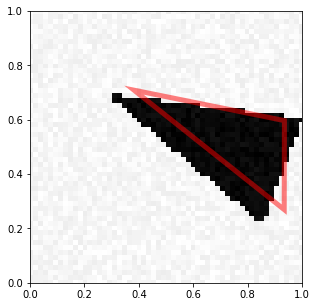

 32/300 [==>...........................] - ETA: 1s

 64/300 [=====>........................] - ETA: 1s

 96/300 [========>.....................] - ETA: 1s

128/300 [===========>..................] - ETA: 1s

160/300 [===============>..............] - ETA: 1s

192/300 [==================>...........] - ETA: 0s

224/300 [=====================>........] - ETA: 0s

256/300 [========================>.....] - ETA: 0s

288/300 [===========================>..] - ETA: 0s

300/300 [==============================] - 2s 8ms/step


0.379938428401947

In [27]:
predictions_test = model.predict(X_test)

Y_pred = normalizer.inverse_transform(predictions_test)
visualize_prediction(X_test[10], Y_pred[10])

model.evaluate(X_test, y_test_normalize)


I have tried with different structures of the model but none were producing
much better results than others. 
One of the reason I ended up finding, is that the three vertices are given to the model in an 
arbitrary order. So the model trains and produce output. But we ask our model to predict them in their exact order so this is why it seems struggling.

An idea to overcome this problem would be to sort the vertices by one of its
coordinates. Below is the modified function to generate a triangle with sorted vertices.
And the figure above was obtained with this modified function. The result is much more satisfying.

In [20]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3).reshape((1,-1))
        V = np.random.random(3).reshape((1,-1))
        
        ##sort vertices by increasing x in order to improve the regression outcomes
        vertices = np.concatenate((U,V),axis=0)
        vertices = vertices[:,vertices[0,:].argsort()]
        U = vertices[0]
        V = vertices[1]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

Part 7 - Image Denoising



At first we define new functions to generate data with noise. We set the noise amplitude between
10 and 20


In [1]:
def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    im_size = (generate_a_rectangle()[0]).shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.randint(10,20)
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i],Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i],Y[i] = generate_a_disk(noise, free_location)
        else:
            triangle = generate_a_triangle(noise, free_location)
            #X[i],Y[i] = triangle[0]
            [X[i], V] = [triangle[0][0]]+triangle[1:]
#    X = (X+noise) / (255 + 2 * noise)
#    Y = (Y+ noise )/(255 + 2 * noise)
    X = X / 255
    Y = Y / 255
    return [X, Y]


def generate_test_set_noise():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_noise(300)
    return [X_test, Y_test] 


In [15]:
X_train_noise, Y_train_noise = generate_dataset_noise(600) 
X_test_noise, Y_test_noise = generate_test_set_noise() 

Creating data:
0


10


20


30


40
50


60


70


80


90


100


110


120


130
140


150


160
170


180


190
200


210
220


230
240


250
260


270
280


290
300


310
320


330
340


350
360


370
380


390
400


410
420


430
440


450
460


470
480


490
500


510
520


530
540


550
560


570
580


590


Creating data:
0
10


20


30
40


50
60


70
80


90
100


110
120


130
140


150
160


170
180


190
200


210


220
230


240
250


260
270


280
290


We plot the figures of an example from the training dataset. The first image is the image 
with noise and the second is the image without noise.
The model will try to produce an image without noise from an image with noise.


In [ ]:
plt.imshow(X_train_noise[0].reshape(72,72), cmap='gray')
plt.title('Input train denoising')


Text(0.5, 1.0, 'Output train denoising')

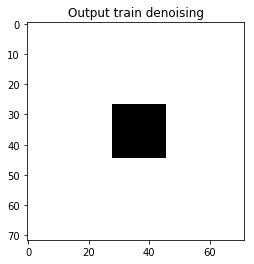

In [9]:
plt.imshow(Y_train_noise[0].reshape(72,72), cmap='gray')
plt.title('Output train denoising')

We reshape both the training and testing data to fit the model we built.

In [16]:
X_train_noise = X_train_noise.reshape((-1,72,72,1))
Y_train_noise = Y_train_noise.reshape((-1,72,72,1))

X_test_noise = X_test_noise.reshape((-1,72,72,1))
Y_test_noise = Y_test_noise.reshape((-1,72,72,1))

To solve the denoising image problem, I saw it as a regression task, we want to find the original
pixel value.

In [ ]:
# Build the model
model = Sequential()

model.add(Convolution2D(60,kernel_size=(3,3),input_shape=(72,72,1,),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Convolution2D(40,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(1,kernel_size=(3,3)))


Since it is a regression task, we use the mean squared error for the loss.


In [18]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

history = model.fit(X_train_noise, Y_train_noise, validation_split=0.1, epochs=50,
                    batch_size=100)

Train on 540 samples, validate on 60 samples
Epoch 1/50


100/540 [====>.........................] - ETA: 1:09 - loss: 1.1289

200/540 [==========>...................] - ETA: 49s - loss: 0.8436 

300/540 [===============>..............] - ETA: 33s - loss: 0.7091

400/540 [=====================>........] - ETA: 19s - loss: 0.6257

500/540 [==========================>...] - ETA: 5s - loss: 0.5674 

540/540 [==============================] - 75s 139ms/step - loss: 0.5478 - val_loss: 0.6008


Epoch 2/50


100/540 [====>.........................] - ETA: 55s - loss: 0.2736

200/540 [==========>...................] - ETA: 43s - loss: 0.2633

300/540 [===============>..............] - ETA: 30s - loss: 0.2598

400/540 [=====================>........] - ETA: 17s - loss: 0.2526

500/540 [==========================>...] - ETA: 5s - loss: 0.2443 

540/540 [==============================] - 71s 131ms/step - loss: 0.2420 - val_loss: 0.4411


Epoch 3/50


100/540 [====>.........................] - ETA: 1:05 - loss: 0.2113

200/540 [==========>...................] - ETA: 50s - loss: 0.1994 

300/540 [===============>..............] - ETA: 36s - loss: 0.1943

400/540 [=====================>........] - ETA: 21s - loss: 0.1947

500/540 [==========================>...] - ETA: 6s - loss: 0.1939 

540/540 [==============================] - 86s 160ms/step - loss: 0.1933 - val_loss: 0.4180


Epoch 4/50


100/540 [====>.........................] - ETA: 1:07 - loss: 0.1733

200/540 [==========>...................] - ETA: 51s - loss: 0.1774 

300/540 [===============>..............] - ETA: 36s - loss: 0.1727

400/540 [=====================>........] - ETA: 21s - loss: 0.1753

500/540 [==========================>...] - ETA: 6s - loss: 0.1733 

540/540 [==============================] - 84s 156ms/step - loss: 0.1724 - val_loss: 0.3091


Epoch 5/50


100/540 [====>.........................] - ETA: 57s - loss: 0.1627

200/540 [==========>...................] - ETA: 43s - loss: 0.1627

300/540 [===============>..............] - ETA: 30s - loss: 0.1649

400/540 [=====================>........] - ETA: 17s - loss: 0.1616

500/540 [==========================>...] - ETA: 5s - loss: 0.1618 

540/540 [==============================] - 70s 130ms/step - loss: 0.1602 - val_loss: 0.2537


Epoch 6/50


100/540 [====>.........................] - ETA: 55s - loss: 0.1598

200/540 [==========>...................] - ETA: 43s - loss: 0.1549

300/540 [===============>..............] - ETA: 30s - loss: 0.1556

400/540 [=====================>........] - ETA: 17s - loss: 0.1516

500/540 [==========================>...] - ETA: 5s - loss: 0.1515 

540/540 [==============================] - 70s 130ms/step - loss: 0.1515 - val_loss: 0.2207


Epoch 7/50


100/540 [====>.........................] - ETA: 56s - loss: 0.1306

200/540 [==========>...................] - ETA: 43s - loss: 0.1475

300/540 [===============>..............] - ETA: 30s - loss: 0.1448

400/540 [=====================>........] - ETA: 17s - loss: 0.1479

500/540 [==========================>...] - ETA: 5s - loss: 0.1467 

540/540 [==============================] - 70s 130ms/step - loss: 0.1464 - val_loss: 0.1952


Epoch 8/50


100/540 [====>.........................] - ETA: 55s - loss: 0.1334

200/540 [==========>...................] - ETA: 42s - loss: 0.1391

300/540 [===============>..............] - ETA: 30s - loss: 0.1393

400/540 [=====================>........] - ETA: 17s - loss: 0.1378

500/540 [==========================>...] - ETA: 5s - loss: 0.1386 

540/540 [==============================] - 70s 129ms/step - loss: 0.1397 - val_loss: 0.1910


Epoch 9/50


100/540 [====>.........................] - ETA: 56s - loss: 0.1293

200/540 [==========>...................] - ETA: 43s - loss: 0.1328

300/540 [===============>..............] - ETA: 30s - loss: 0.1331

400/540 [=====================>........] - ETA: 17s - loss: 0.1359

500/540 [==========================>...] - ETA: 5s - loss: 0.1361 

540/540 [==============================] - 70s 129ms/step - loss: 0.1355 - val_loss: 0.1768


Epoch 10/50


100/540 [====>.........................] - ETA: 55s - loss: 0.1251

200/540 [==========>...................] - ETA: 43s - loss: 0.1261

300/540 [===============>..............] - ETA: 30s - loss: 0.1300

400/540 [=====================>........] - ETA: 18s - loss: 0.1291

500/540 [==========================>...] - ETA: 5s - loss: 0.1306 

540/540 [==============================] - 74s 138ms/step - loss: 0.1313 - val_loss: 0.1656


Epoch 11/50


100/540 [====>.........................] - ETA: 59s - loss: 0.1235

200/540 [==========>...................] - ETA: 46s - loss: 0.1219

300/540 [===============>..............] - ETA: 35s - loss: 0.1292

400/540 [=====================>........] - ETA: 20s - loss: 0.1280

500/540 [==========================>...] - ETA: 5s - loss: 0.1267 

540/540 [==============================] - 83s 154ms/step - loss: 0.1276 - val_loss: 0.1650


Epoch 12/50


100/540 [====>.........................] - ETA: 1:07 - loss: 0.1335

200/540 [==========>...................] - ETA: 52s - loss: 0.1250 

300/540 [===============>..............] - ETA: 38s - loss: 0.1252

400/540 [=====================>........] - ETA: 22s - loss: 0.1244

500/540 [==========================>...] - ETA: 6s - loss: 0.1252 

540/540 [==============================] - 88s 163ms/step - loss: 0.1246 - val_loss: 0.1661


Epoch 13/50


100/540 [====>.........................] - ETA: 1:14 - loss: 0.1258

200/540 [==========>...................] - ETA: 53s - loss: 0.1239 

300/540 [===============>..............] - ETA: 39s - loss: 0.1273

400/540 [=====================>........] - ETA: 24s - loss: 0.1243

500/540 [==========================>...] - ETA: 7s - loss: 0.1226 

540/540 [==============================] - 97s 179ms/step - loss: 0.1222 - val_loss: 0.1554


Epoch 14/50


100/540 [====>.........................] - ETA: 56s - loss: 0.1178

200/540 [==========>...................] - ETA: 43s - loss: 0.1141

300/540 [===============>..............] - ETA: 31s - loss: 0.1179

400/540 [=====================>........] - ETA: 20s - loss: 0.1186

500/540 [==========================>...] - ETA: 6s - loss: 0.1183 

540/540 [==============================] - 90s 167ms/step - loss: 0.1181 - val_loss: 0.1618


Epoch 15/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.1100

200/540 [==========>...................] - ETA: 1:04 - loss: 0.1135

300/540 [===============>..............] - ETA: 46s - loss: 0.1153 

400/540 [=====================>........] - ETA: 27s - loss: 0.1151

500/540 [==========================>...] - ETA: 7s - loss: 0.1150 

540/540 [==============================] - 109s 201ms/step - loss: 0.1149 - val_loss: 0.1660


Epoch 16/50


100/540 [====>.........................] - ETA: 1:24 - loss: 0.1157

200/540 [==========>...................] - ETA: 1:05 - loss: 0.1116

300/540 [===============>..............] - ETA: 46s - loss: 0.1099 

400/540 [=====================>........] - ETA: 27s - loss: 0.1131

500/540 [==========================>...] - ETA: 7s - loss: 0.1130 

540/540 [==============================] - 108s 200ms/step - loss: 0.1131 - val_loss: 0.1660


Epoch 17/50


100/540 [====>.........................] - ETA: 1:24 - loss: 0.1136

200/540 [==========>...................] - ETA: 1:05 - loss: 0.1109

300/540 [===============>..............] - ETA: 46s - loss: 0.1134 

400/540 [=====================>........] - ETA: 27s - loss: 0.1119

500/540 [==========================>...] - ETA: 7s - loss: 0.1115 

540/540 [==============================] - 107s 198ms/step - loss: 0.1111 - val_loss: 0.1686


Epoch 18/50


100/540 [====>.........................] - ETA: 1:21 - loss: 0.1095

200/540 [==========>...................] - ETA: 1:02 - loss: 0.1105

300/540 [===============>..............] - ETA: 45s - loss: 0.1118 

400/540 [=====================>........] - ETA: 26s - loss: 0.1094

500/540 [==========================>...] - ETA: 7s - loss: 0.1086 

540/540 [==============================] - 102s 188ms/step - loss: 0.1079 - val_loss: 0.1431


Epoch 19/50


100/540 [====>.........................] - ETA: 57s - loss: 0.1151

200/540 [==========>...................] - ETA: 45s - loss: 0.1105

300/540 [===============>..............] - ETA: 37s - loss: 0.1058

400/540 [=====================>........] - ETA: 23s - loss: 0.1082

500/540 [==========================>...] - ETA: 6s - loss: 0.1070 

540/540 [==============================] - 97s 180ms/step - loss: 0.1063 - val_loss: 0.1411


Epoch 20/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.1000

200/540 [==========>...................] - ETA: 1:06 - loss: 0.0987

300/540 [===============>..............] - ETA: 46s - loss: 0.1019 

400/540 [=====================>........] - ETA: 27s - loss: 0.1021

500/540 [==========================>...] - ETA: 7s - loss: 0.1039 

540/540 [==============================] - 108s 200ms/step - loss: 0.1036 - val_loss: 0.1484


Epoch 21/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.1025

200/540 [==========>...................] - ETA: 1:05 - loss: 0.1056

300/540 [===============>..............] - ETA: 46s - loss: 0.1031 

400/540 [=====================>........] - ETA: 27s - loss: 0.1024

500/540 [==========================>...] - ETA: 7s - loss: 0.1012 

540/540 [==============================] - 108s 199ms/step - loss: 0.1016 - val_loss: 0.1556


Epoch 22/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.1015

200/540 [==========>...................] - ETA: 1:05 - loss: 0.1034

300/540 [===============>..............] - ETA: 46s - loss: 0.1016 

400/540 [=====================>........] - ETA: 27s - loss: 0.1013

500/540 [==========================>...] - ETA: 7s - loss: 0.1019 

540/540 [==============================] - 108s 199ms/step - loss: 0.1012 - val_loss: 0.1284


Epoch 23/50


100/540 [====>.........................] - ETA: 1:26 - loss: 0.1045

200/540 [==========>...................] - ETA: 1:05 - loss: 0.1026

300/540 [===============>..............] - ETA: 41s - loss: 0.1013 

400/540 [=====================>........] - ETA: 22s - loss: 0.1023

500/540 [==========================>...] - ETA: 6s - loss: 0.1031 

540/540 [==============================] - 92s 170ms/step - loss: 0.1022 - val_loss: 0.1182


Epoch 24/50


100/540 [====>.........................] - ETA: 1:29 - loss: 0.1086

200/540 [==========>...................] - ETA: 1:06 - loss: 0.1016

300/540 [===============>..............] - ETA: 46s - loss: 0.0988 

400/540 [=====================>........] - ETA: 26s - loss: 0.0985

500/540 [==========================>...] - ETA: 7s - loss: 0.0987 

540/540 [==============================] - 107s 198ms/step - loss: 0.1000 - val_loss: 0.1196


Epoch 25/50


100/540 [====>.........................] - ETA: 1:22 - loss: 0.1028

200/540 [==========>...................] - ETA: 1:03 - loss: 0.0972

300/540 [===============>..............] - ETA: 45s - loss: 0.0963 

400/540 [=====================>........] - ETA: 26s - loss: 0.0967

500/540 [==========================>...] - ETA: 7s - loss: 0.0965 

540/540 [==============================] - 106s 196ms/step - loss: 0.0975 - val_loss: 0.1145


Epoch 26/50


100/540 [====>.........................] - ETA: 1:28 - loss: 0.0938

200/540 [==========>...................] - ETA: 1:07 - loss: 0.0961

300/540 [===============>..............] - ETA: 48s - loss: 0.0944 

400/540 [=====================>........] - ETA: 27s - loss: 0.0929

500/540 [==========================>...] - ETA: 7s - loss: 0.0954 

540/540 [==============================] - 108s 200ms/step - loss: 0.0960 - val_loss: 0.1236


Epoch 27/50


100/540 [====>.........................] - ETA: 56s - loss: 0.0927

200/540 [==========>...................] - ETA: 47s - loss: 0.0915

300/540 [===============>..............] - ETA: 38s - loss: 0.0917

400/540 [=====================>........] - ETA: 23s - loss: 0.0926

500/540 [==========================>...] - ETA: 7s - loss: 0.0930 

540/540 [==============================] - 98s 182ms/step - loss: 0.0931 - val_loss: 0.1128


Epoch 28/50


100/540 [====>.........................] - ETA: 1:20 - loss: 0.0885

200/540 [==========>...................] - ETA: 1:02 - loss: 0.0913

300/540 [===============>..............] - ETA: 44s - loss: 0.0911 

400/540 [=====================>........] - ETA: 26s - loss: 0.0914

500/540 [==========================>...] - ETA: 7s - loss: 0.0920 

540/540 [==============================] - 104s 193ms/step - loss: 0.0922 - val_loss: 0.1204


Epoch 29/50


100/540 [====>.........................] - ETA: 1:23 - loss: 0.0885

200/540 [==========>...................] - ETA: 1:04 - loss: 0.0953

300/540 [===============>..............] - ETA: 45s - loss: 0.0951 

400/540 [=====================>........] - ETA: 26s - loss: 0.0931

500/540 [==========================>...] - ETA: 7s - loss: 0.0919 

540/540 [==============================] - 106s 196ms/step - loss: 0.0920 - val_loss: 0.1250


Epoch 30/50


100/540 [====>.........................] - ETA: 1:23 - loss: 0.0938

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0919

300/540 [===============>..............] - ETA: 44s - loss: 0.0900 

400/540 [=====================>........] - ETA: 24s - loss: 0.0897

500/540 [==========================>...] - ETA: 6s - loss: 0.0917 

540/540 [==============================] - 90s 167ms/step - loss: 0.0920 - val_loss: 0.1130


Epoch 31/50


100/540 [====>.........................] - ETA: 56s - loss: 0.0935

200/540 [==========>...................] - ETA: 43s - loss: 0.0909

300/540 [===============>..............] - ETA: 30s - loss: 0.0928

400/540 [=====================>........] - ETA: 18s - loss: 0.0904

500/540 [==========================>...] - ETA: 5s - loss: 0.0906 

540/540 [==============================] - 84s 155ms/step - loss: 0.0909 - val_loss: 0.1277


Epoch 32/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0862

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0929

300/540 [===============>..............] - ETA: 46s - loss: 0.0924 

400/540 [=====================>........] - ETA: 27s - loss: 0.0918

500/540 [==========================>...] - ETA: 7s - loss: 0.0924 

540/540 [==============================] - 107s 198ms/step - loss: 0.0914 - val_loss: 0.1166


Epoch 33/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0886

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0886

300/540 [===============>..............] - ETA: 46s - loss: 0.0866 

400/540 [=====================>........] - ETA: 27s - loss: 0.0873

500/540 [==========================>...] - ETA: 7s - loss: 0.0867 

540/540 [==============================] - 107s 199ms/step - loss: 0.0871 - val_loss: 0.1060


Epoch 34/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0915

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0920

300/540 [===============>..............] - ETA: 46s - loss: 0.0886 

400/540 [=====================>........] - ETA: 25s - loss: 0.0878

500/540 [==========================>...] - ETA: 6s - loss: 0.0887 

540/540 [==============================] - 91s 169ms/step - loss: 0.0889 - val_loss: 0.1051


Epoch 35/50


100/540 [====>.........................] - ETA: 56s - loss: 0.0933

200/540 [==========>...................] - ETA: 43s - loss: 0.0885

300/540 [===============>..............] - ETA: 30s - loss: 0.0869

400/540 [=====================>........] - ETA: 17s - loss: 0.0861

500/540 [==========================>...] - ETA: 5s - loss: 0.0855 

540/540 [==============================] - 70s 130ms/step - loss: 0.0866 - val_loss: 0.1047


Epoch 36/50


100/540 [====>.........................] - ETA: 55s - loss: 0.0874

200/540 [==========>...................] - ETA: 42s - loss: 0.0881

300/540 [===============>..............] - ETA: 30s - loss: 0.0865

400/540 [=====================>........] - ETA: 17s - loss: 0.0861

500/540 [==========================>...] - ETA: 5s - loss: 0.0866 

540/540 [==============================] - 80s 149ms/step - loss: 0.0881 - val_loss: 0.0983


Epoch 37/50


100/540 [====>.........................] - ETA: 1:24 - loss: 0.0839

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0851

300/540 [===============>..............] - ETA: 45s - loss: 0.0863 

400/540 [=====================>........] - ETA: 26s - loss: 0.0864

500/540 [==========================>...] - ETA: 7s - loss: 0.0858 

540/540 [==============================] - 104s 193ms/step - loss: 0.0860 - val_loss: 0.0898


Epoch 38/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0873

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0917

300/540 [===============>..............] - ETA: 45s - loss: 0.0878 

400/540 [=====================>........] - ETA: 26s - loss: 0.0868

500/540 [==========================>...] - ETA: 7s - loss: 0.0886 

540/540 [==============================] - 103s 191ms/step - loss: 0.0886 - val_loss: 0.0964


Epoch 39/50


100/540 [====>.........................] - ETA: 1:26 - loss: 0.0835

200/540 [==========>...................] - ETA: 1:01 - loss: 0.0872

300/540 [===============>..............] - ETA: 41s - loss: 0.0853 

400/540 [=====================>........] - ETA: 25s - loss: 0.0865

500/540 [==========================>...] - ETA: 7s - loss: 0.0873 

540/540 [==============================] - 103s 190ms/step - loss: 0.0876 - val_loss: 0.0873


Epoch 40/50


100/540 [====>.........................] - ETA: 1:23 - loss: 0.0906

200/540 [==========>...................] - ETA: 1:04 - loss: 0.0852

300/540 [===============>..............] - ETA: 45s - loss: 0.0853 

400/540 [=====================>........] - ETA: 26s - loss: 0.0848

500/540 [==========================>...] - ETA: 7s - loss: 0.0861 

540/540 [==============================] - 105s 195ms/step - loss: 0.0851 - val_loss: 0.0957


Epoch 41/50


100/540 [====>.........................] - ETA: 1:23 - loss: 0.0775

200/540 [==========>...................] - ETA: 1:04 - loss: 0.0844

300/540 [===============>..............] - ETA: 45s - loss: 0.0843 

400/540 [=====================>........] - ETA: 26s - loss: 0.0852

500/540 [==========================>...] - ETA: 7s - loss: 0.0840 

540/540 [==============================] - 105s 195ms/step - loss: 0.0848 - val_loss: 0.1085


Epoch 42/50


100/540 [====>.........................] - ETA: 1:22 - loss: 0.0905

200/540 [==========>...................] - ETA: 53s - loss: 0.0875 

300/540 [===============>..............] - ETA: 35s - loss: 0.0865

400/540 [=====================>........] - ETA: 19s - loss: 0.0837

500/540 [==========================>...] - ETA: 5s - loss: 0.0833 

540/540 [==============================] - 76s 141ms/step - loss: 0.0827 - val_loss: 0.0931


Epoch 43/50


100/540 [====>.........................] - ETA: 55s - loss: 0.0727

200/540 [==========>...................] - ETA: 42s - loss: 0.0799

300/540 [===============>..............] - ETA: 30s - loss: 0.0876

400/540 [=====================>........] - ETA: 17s - loss: 0.0876

500/540 [==========================>...] - ETA: 5s - loss: 0.0862 

540/540 [==============================] - 70s 129ms/step - loss: 0.0856 - val_loss: 0.0997


Epoch 44/50


100/540 [====>.........................] - ETA: 56s - loss: 0.0822

200/540 [==========>...................] - ETA: 43s - loss: 0.0813

300/540 [===============>..............] - ETA: 30s - loss: 0.0844

400/540 [=====================>........] - ETA: 17s - loss: 0.0828

500/540 [==========================>...] - ETA: 5s - loss: 0.0833 

540/540 [==============================] - 70s 129ms/step - loss: 0.0843 - val_loss: 0.0949


Epoch 45/50


100/540 [====>.........................] - ETA: 55s - loss: 0.0815

200/540 [==========>...................] - ETA: 42s - loss: 0.0828

300/540 [===============>..............] - ETA: 30s - loss: 0.0837

400/540 [=====================>........] - ETA: 18s - loss: 0.0809

500/540 [==========================>...] - ETA: 5s - loss: 0.0828 

540/540 [==============================] - 83s 153ms/step - loss: 0.0828 - val_loss: 0.0825


Epoch 46/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0774

200/540 [==========>...................] - ETA: 1:05 - loss: 0.0804

300/540 [===============>..............] - ETA: 46s - loss: 0.0811 

400/540 [=====================>........] - ETA: 27s - loss: 0.0805

500/540 [==========================>...] - ETA: 7s - loss: 0.0802 

540/540 [==============================] - 108s 200ms/step - loss: 0.0815 - val_loss: 0.0792


Epoch 47/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0756

200/540 [==========>...................] - ETA: 1:06 - loss: 0.0757

300/540 [===============>..............] - ETA: 45s - loss: 0.0808 

400/540 [=====================>........] - ETA: 26s - loss: 0.0784

500/540 [==========================>...] - ETA: 7s - loss: 0.0791 

540/540 [==============================] - 106s 197ms/step - loss: 0.0800 - val_loss: 0.1088


Epoch 48/50


100/540 [====>.........................] - ETA: 1:25 - loss: 0.0787

200/540 [==========>...................] - ETA: 1:06 - loss: 0.0805

300/540 [===============>..............] - ETA: 46s - loss: 0.0797 

400/540 [=====================>........] - ETA: 27s - loss: 0.0805

500/540 [==========================>...] - ETA: 7s - loss: 0.0797 

540/540 [==============================] - 105s 194ms/step - loss: 0.0804 - val_loss: 0.0774


Epoch 49/50


100/540 [====>.........................] - ETA: 56s - loss: 0.0834

200/540 [==========>...................] - ETA: 42s - loss: 0.0828

300/540 [===============>..............] - ETA: 30s - loss: 0.0854

400/540 [=====================>........] - ETA: 17s - loss: 0.0846

500/540 [==========================>...] - ETA: 5s - loss: 0.0837 

540/540 [==============================] - 70s 129ms/step - loss: 0.0831 - val_loss: 0.0729


Epoch 50/50


100/540 [====>.........................] - ETA: 55s - loss: 0.0764

200/540 [==========>...................] - ETA: 43s - loss: 0.0799

300/540 [===============>..............] - ETA: 30s - loss: 0.0844

400/540 [=====================>........] - ETA: 17s - loss: 0.0815

500/540 [==========================>...] - ETA: 5s - loss: 0.0819 

540/540 [==============================] - 70s 129ms/step - loss: 0.0828 - val_loss: 0.1407


In [19]:
print('Model outcome regression:',model.evaluate(X_test_noise,Y_test_noise))

 32/300 [==>...........................] - ETA: 8s

 64/300 [=====>........................] - ETA: 9s

 96/300 [========>.....................] - ETA: 7s

128/300 [===========>..................] - ETA: 6s

160/300 [===============>..............] - ETA: 5s

192/300 [==================>...........] - ETA: 3s

224/300 [=====================>........] - ETA: 2s

256/300 [========================>.....] - ETA: 1s

288/300 [===========================>..] - ETA: 0s

300/300 [==============================] - 10s 34ms/step


Model outcome regression: 0.13567137996355694


In [20]:
Y_pred_without_noise = model.predict(X_test_noise)

Text(0.5, 1.0, 'Input test denoising')

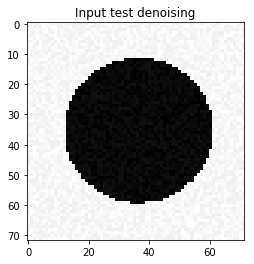

In [27]:
plt.imshow(X_test_noise[150].reshape(72,72), cmap='gray')
plt.title('Input test denoising')

Text(0.5, 1.0, 'Predicted Output test denoising')

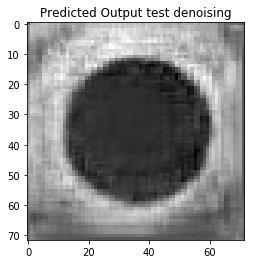

In [28]:
plt.imshow(Y_pred_without_noise[150].reshape(72,72), cmap='gray')
plt.title('Predicted Output test denoising')

Although the loss function is pretty low, the result isn't entirely satis'